In [1]:
import ncempy.io as nio
import joblib
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from IPython.display import Image  
# from sklearn.externals.six import StringIO  
from scipy.signal import savgol_filter
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from pymatgen.analysis.local_env import get_neighbors_of_site_with_index
from pymatgen.analysis.bond_valence import calculate_bv_sum
from pymatgen.core.bonds import CovalentBond, get_bond_length
from scipy import interpolate
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
from pretty_confusion_matrix import pp_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import PercentFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn import svm
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from matplotlib.cm import ScalarMappable
import glob
# import ncempy.io as nio
from scipy.stats import pearsonr as ps
from scipy.interpolate import interp1d
from scipy.stats import spearmanr
from scipy import optimize
from scipy.special import voigt_profile as voigt
from IPython.display import clear_output
import os
import shutil
import sys
from pathlib import Path
# from mp_api.client import MPRester
import os
from lightshow import Database
# from lightshow import FEFFParameters, VASPParameters
# from lightshow.defaults import VASP_INCAR_DEFAULT_COREHOLE_POTENTIAL
import shutil
# from lightshow.pymatgen_utils import get_inequivalent_site_info
# from scipy.special import voigt_profile as voigt
# from scipy.signal import savgol_filter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
# from Analysis_objects_and_functions import *
%load_ext autoreload
%autoreload 2
from pymatgen.analysis.bond_valence import BVAnalyzer

No module named 'phonopy'
No module named 'phonopy'


In [2]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
def get_inequivalent_site_info(structure):
    """Gets the symmetrically inequivalent sites as found by the
    SpacegroupAnalyzer class from Pymatgen.

    Parameters
    ----------
    structure : pymatgen.core.structure.Structure
        The Pymatgen structure of interest.

    Returns
    -------
    dict
        A dictionary containing three lists, one of the inequivalent sites, one
        for the atom types they correspond to and the last for the multiplicity.
    """

    # Get the symmetrically inequivalent indexes
    inequivalent_sites = (
        SpacegroupAnalyzer(structure)
        .get_symmetrized_structure()
        .equivalent_indices
    )

    # Equivalent indexes must all share the same atom type
    multiplicities = [len(xx) for xx in inequivalent_sites]
    inequivalent_sites = [xx[0] for xx in inequivalent_sites]
    species = [str(structure[xx].specie) for xx in inequivalent_sites]

    return {
        "sites": inequivalent_sites,
        "species": species,
        "multiplicities": multiplicities,}

In [3]:
# best (and most sensible) combo still appears to be drop 3s and greater, keep the randomly dropped materials and align by 
# 0.5 intervals with the originally extracted data. Mixtures especially look really good 

# removing greater than or equal to 2.5 made prediction of cu 0 a little worse overall, which is the component of this that 
# can least affort getting worse 

In [4]:
class Site_spectum:
    def __init__(
        self,
        xin,
        yin,
        VASP_out = [float, float, float],
        weight = 1.0,
        
    ):
        """
        The spectrum information of a each site
        Args:
            xin, yin: simulated spectrum for each site
            VASP_out: total energy of the final state with core hole, fermi energy of the final state, 
            and total energy of the initial state without core hole
            weight: the site weight in the crystal 
        """
        
        self.xin = xin
        self.yin = yin
        self.vasp_out = VASP_out
        self.Weight = weight
        
    @property
    def spectrum(self):
        return self.xin, self.yin
    
    @property
    def weight(self):
        return self.Weight
    
    @property
    def VASP_out(self):
        return self.vasp_out
    
class Autobroaden:
    def __init__(
        self,
        broaden_paras: [float, float],
        CHlifetime : float,
        core_state : float,
        EXPshift = None
    ):
        """
        Args:
            broaden_paras: Broadening parameters, sigma of Gaussian and lorentz dividor 
            CHlifetime: Core hole life time, Zn K-edge: 1.67, Ti K-edge: 0.89, 
              taken from Campbell, J. and T. Papp, Widths of the atomic K–N7 levels. Atomic Data and Nuclear Data Tables, 2001. 77(1): p. 1-56.
            core_state: Core state, e.g., 1s state energy for K-edge
            EXPshift: Empirical constant shift to match theory to experiment
        """
      
        if EXPshift is None:
            self.opt_shift = True
        else:
            self.opt_shift = False
        
        self.broaden_paras = broaden_paras
        self.CHlifetime = CHlifetime
        self.core_state = core_state
        self.EXPshift = EXPshift
        
        
        print("broaden_paras")
        print(broaden_paras)
        
    @property
    def sigma(self):
        return self.broaden_paras[0]

    @property
    def lorentz_divider(self):
        return self.broaden_paras[1]
    
    @property
    def empirical_shift(self):
        return self.EXPshift 
    
  
    @staticmethod
    def deriv(x,y):
    
        yout = []

        for i in range(len(x)-1):
            yout.append((y[i+1]-y[i])/(x[i+1]-x[i]))

        yout.append(0)
        #yout = np.array(yout)
        
        return yout
    
    @staticmethod
    def gradient(vec_diff,hei_diff):
        return hei_diff/vec_diff

    @staticmethod
    def voigt_broaden(x,xin,yin,sigma,ld,lt,ef):
        yout = np.zeros_like(x)
        
        num=len(xin)
        for i in range(num):
            gamma=lt/2
            if xin[i] > ef:
                gamma=gamma+(xin[i]-ef)/ld/2
            yout=yout+yin[i]*voigt(x-xin[i],sigma,gamma)/num   
        return yout 
    

    def crystal_spectrum_broaden(self, x, site_spectra, sigma,ld , cross_sec = True):
        
        yout = np.zeros_like(x)
        
        weight = 0
        
        for site_spectrum in site_spectra:
            xin, yin = site_spectrum.spectrum
            
            # xin = xin + self.EXPshift+site_spectrum.VASP_out[0]-site_spectrum.VASP_out[1]-site_spectrum.VASP_out[2]+self.core_state
            # if cross_sec:
                # yin = yin * xin

            ef = self.EXPshift  + site_spectrum.VASP_out[0] -  site_spectrum.VASP_out[2] 
            yout=yout*weight + self.voigt_broaden(x,xin,yin,sigma,ld,self.CHlifetime,ef)*site_spectrum.weight
            
            weight = weight + site_spectrum.weight

        return yout/weight 
    
    
    def broaden_score(self,broaden_paras,x, site_spectra ,exp,dmu = True ,cross_sec = True, opt_shift = True, *args):
        
        
        if opt_shift is True:
            self.EXPshift = broaden_paras[2]- site_spectra[0].VASP_out[0] +  site_spectra[0].VASP_out[1] +  site_spectra[0].VASP_out[2] - self.core_state
        elif self.EXPshift is None:
            print("Please provide empirical shift!")
            
        spec = self.crystal_spectrum_broaden(x,site_spectra ,broaden_paras[0],broaden_paras[1], cross_sec)
        if dmu:
            exp=self.deriv(x,exp) 
            spec=self.deriv(x,spec) 


        return -ps(spec,exp)[0]
    
    
    def broaden(self, x, site_spectra , shift = None, volume = 1.0, cross_sec = True):
          
     
        isreturn = True 
        if shift is not None:
            print("********Empirical shift initialized********")
            self.EXPshift= shift - site_spectra[0].VASP_out[0]+site_spectra[0].VASP_out[1]+site_spectra[0].VASP_out[2]-self.core_state
    
        elif self.EXPshift is None:
            print("Please optimize the parameters or provide empirical peak shift!")
            isreturn = False

        if isreturn:
            return self.crystal_spectrum_broaden(x,site_spectra,self.broaden_paras[0], self.broaden_paras[1], cross_sec)*volume

    
    def paras_optimize(
        self,
        x,
        site_spectra,
        exp,
        shift = None,
        init_paras = None,
        init_diff = None,
        learn_rate = 10.0,
        n_iter=500, 
        bounds=None,
        tolerance=1e-05,
        dmu=False,
        cross_sec = True
    ):
        
        """
        Using known experimental spectrum to optimize the broadening parameters with gradient descent method
        
        Args:
        x: output energy grid or experimental energy grid
        xin: simulation energy grid
        yin: unbroadened sinulation spectrum
        exp: experimental spectum for broadening parameters optimization
        shift: main peak diference between experimental spectrum and simulation 
        init_paras: initial broaden parameters
        init_diff: initial optimization step
        learn_rate : gradient descent rate
        background : substrate backgroud
        n_iter : maximum interation number 
        bounds: bounds for braodening parameters
        tolerance : convergence condition
        dmu : using spectrum derivative
        cross_sec : comparing cross section spectrum

        """
        
        if init_paras is None:
            init_paras = self.broaden_paras
         
        if init_diff is None:
            init_diff = [x / 20.0 for x in init_paras]

        if shift is None:
            if self.EXPshift is None:
                self.EXPshift = - self.core_state
                yin = crystal_spectrum_broaden(x, site_spectra, init_paras[0],init_paras[1] , cross_sec)
                shift = x[list(exp).index(max(exp))]-x[list(yin).index(max(yin))]
                
                self.EXPshift = shift - site_spectra[0].VASP_out[0]+site_spectra[0].VASP_out[1]+site_spectra[0].VASP_out[2]-site_spectra[0].core_state
            
                print("Find peak shift value = " + str(shift))
        else:
            self.EXPshift = shift - site_spectra[0].VASP_out[0]+site_spectra[0].VASP_out[1]+site_spectra[0].VASP_out[2]-self.core_state
            
            
        init_score=0
        vec=np.array(init_paras)
        print(vec[1])
        vdiff=np.array(init_diff)
        spec=np.zeros_like(x)

        
        if dmu:
            print("Dmu considered")
            exp=self.deriv(x,exp)       


        isconverged=False
        for i in range(n_iter):
            hei_diff=[]
            
            print("========== Iteration "+str(i)+"  ===================================")
            print("Parameters: "+str(vec))
            print("Fitting score:"+str(init_score))
            
            spec=self.crystal_spectrum_broaden(x,site_spectra,abs(vec[0]),vec[1],cross_sec)

            spt1=self.crystal_spectrum_broaden(x,site_spectra,abs(vec[0]+vdiff[0]),vec[1],cross_sec)
            spt2=self.crystal_spectrum_broaden(x,site_spectra,abs(vec[0]),vec[1]+vdiff[1],cross_sec)
            

            if dmu:

                spec=self.deriv(x,spec)
                spt1=self.deriv(x,spt1)
                spt2=self.deriv(x,spt2)

          
            init_score=ps(spec,exp)[0]
            #spt1=spt1/np.linalg.norm(spt1)
            #spt2=spt2/np.linalg.norm(spt2)
            hei_diff.append(ps(spt1,exp)[0]-init_score)
            hei_diff.append(ps(spt2,exp)[0]-init_score)
            
            
            vec= vec+vdiff
            
            if bounds is not None:
                if vec[0] < bounds[0][0]:
                    vec[0] = bounds[0][0]
                if vec[0] > bounds[0][1]:
                    vec[0] = bounds[0][1]
                if vec[1] < bounds[1][0]:
                    vec[1] = bounds[1][0]
                if vec[1] > bounds[1][1]:
                    vec[1] = bounds[1][1]                
                
            vdiff= learn_rate*self.gradient(vdiff,np.array(hei_diff))
            print(vdiff)
            for i in range(len(vdiff)):
                if vdiff[i] == 0:
                    vdiff[i] = (random.random()-0.5)/1000


            if np.all(np.abs(hei_diff) <= tolerance):
                print("Converged!")
                isconverged = True
                break
        if not isconverged:
            print(str(n_iter)+" iterations finished without convergence")
        
        self.broaden_paras = list(vec) 

        return vec
    
    
    def paras_optimize_scipy(
        self,
        x,
        site_spectra,
        exp,
        opt_shift = None,
        bounds= None,
        dmu=True,
        cross_sec = True
    ):
        """
        Using known experimental spectrum to optimize the broadening parameters 
        with simplicial homology global optimization method by scipy package
        
        
        """
        
        if opt_shift is None:
            opt_shift = self.opt_shift
                   
        result=optimize.shgo(self.broaden_score,bounds,args=(x,site_spectra,exp,dmu,cross_sec,opt_shift))

        self.broaden_paras = list(result.x) [0:2]
        if opt_shift is True:
            self.EXPshift = result.x[2] - site_spectra[0].VASP_out[0]+ site_spectra[0].VASP_out[1] + site_spectra[0].VASP_out[2] - self.core_state

        return result 

In [5]:
def determine_broadening_params(Fe_core_state, Fe_core_hole_fermi_energy, Fe_core_hole_total_energy, Fe_SCF_total_energy,
                               reference_filepath, theory_filepath, reference_type = 'TEAM I', spectra_df = None, 
                                zlp_offset = False, zlp_val = None, fit_range = None, manually_align_to_l3 = False, 
                                l3_range_simulations = None, l3_range_experiments = None, energy_col = 'Scaled Energy (eV)',
                               intens_col =  'Scaled Intensity', smooth_exp = True, exp_smoothing = [51,3]):
    Fe_core_hole_lifetime = 1

    Fe_vasp_out = [Fe_core_hole_total_energy,
                Fe_core_hole_fermi_energy,
                Fe_SCF_total_energy]

    # Collect exprimental and simulation data
    if reference_type == 'TEAM I':
        output = nio.dm.dmReader(reference_filepath)
        intens = output['data']/max(output['data'])
        energies = output['coords'][0]
        if zlp_offset:
            energies = align_eels(zlp_val, energies)
            
        intens = savgol_filter(intens, 51, 3)
        intens = intens/max(intens)
            
    if reference_type == 'csv':
        output = pd.read_csv(reference_filepath)
        intens_temp = output['Intensity'] - min(output['Intensity'])
        intens = intens_temp/max(intens_temp)
        energies = output['Energy (eV)']
        energies_interp = np.arange(round(min(energies)+0.05, 1), round(max(energies)-0.05, 1), 0.1)
        energies_interp_use = []
        for i in energies_interp:
            energies_interp_use.append(round(i,1))
            # print(round(i,1))
        f = interp1d(energies, intens)
        interp_intens = f(energies_interp)
        
        intens = interp_intens-min(interp_intens)
        intens = intens/max(intens)
        energies = energies_interp

    exp = []
    for i in range(0, len(intens)):
        exp.append([energies[i], intens[i]])
    exp = np.asarray(exp)
    
    if type(theory_filepath) == str:
        unbroaden_spect_temp = np.loadtxt(theory_filepath)
        unbroaden_spect = [unbroaden_spect_temp.T[0], unbroaden_spect_temp.T[1]]
        unbroaden_spect = np.asarray(unbroaden_spect).T
    if type(theory_filepath) == int:
        row = spectra_df.iloc[theory_filepath]
        row_energies = row[energy_col]
        print(row_energies)
        # print(row_energies)
        row_intensities = row[intens_col]
        unbroaden_spect = [row_energies, row_intensities]
        unbroaden_spect = np.asarray(unbroaden_spect).T
    
    
    plt.figure(figsize = (8,6))
    plt.xlabel('Energy (eV)', fontsize = 20)
    plt.ylabel('Normalized Inensity', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.plot(exp.T[0],exp.T[1], label = 'Cu EXP', linewidth = 2)
    plt.legend(fontsize = 16)
    
    
    if manually_align_to_l3 == False: 
        y_max = max(exp.T[1])
        y_max_index = list(exp.T[1]).index(y_max)
        x_peak_loc = exp.T[0][y_max_index]
        
    else:
        energies_temp = []
        temp = list(exp.T[0])
        for i in temp:
            energies_temp.append(round(i,1))
        x_loc_min = energies_temp.index(l3_range_experiments[0])
        x_loc_max = energies_temp.index(l3_range_experiments[1])
        
        y_max = max(exp.T[1][x_loc_min:x_loc_max])
        y_max_index = list(exp.T[1]).index(y_max)
        x_peak_loc = exp.T[0][y_max_index]
    
    plt.scatter(x_peak_loc, 1, color ='k')
    plt.show()
    
    # print(unbroaden_spect)

    #Create site spectrum object for broadening
    xin = unbroaden_spect.T[0] # choosing smaller range can make the optimization processs faster
    yin = unbroaden_spect.T[1]
    
    # print(yin)
    # print(xin)

    plt.figure(figsize = (8,6))
    plt.xlabel('Energy (eV)', fontsize = 20)
    plt.ylabel('Normalized Inensity', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.plot(exp.T[0],exp.T[1], label = 'Cu EXP', linewidth = 2)
    plt.plot(xin, yin/max(yin), label = 'Raw FEFF', linewidth = 2)
    # plt.xlim([450,490])
    plt.legend(fontsize = 16)
    plt.rcParams['pdf.fonttype'] = 'truetype'
    plt.savefig('Pre Alignment.pdf', bbox_inches='tight', transparent=True)
    plt.show()

    xin = xin + (Fe_core_state - Fe_core_hole_fermi_energy) + (Fe_core_hole_total_energy - Fe_SCF_total_energy)
    # xin = xin + 1168.75
    plt.figure(figsize = (8,6))
    plt.xlabel('Energy (eV)', fontsize = 20)
    plt.ylabel('Normalized Inensity', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.plot(xin,yin/max(yin), label = 'Cu unbroaden simulation', linewidth = 2)
    plt.legend(fontsize = 16)
    plt.xlim([925,945])
    
    if manually_align_to_l3 == False: 
        yin_max = max(yin)
        yin_max_index = list(yin).index(yin_max)
        xin_peak_loc = xin[yin_max_index]
        
    else:
        energies_temp = []
        temp = list(xin)
        for i in temp:
            energies_temp.append(round(i,5))
            # energies_temp.append(i)
        # print(energies_temp)
        x_loc_min = energies_temp.index(round(l3_range_simulations[0] + (Fe_core_state - Fe_core_hole_fermi_energy) + (Fe_core_hole_total_energy - Fe_SCF_total_energy), 5))
        x_loc_max = energies_temp.index(round(l3_range_simulations[1] + (Fe_core_state - Fe_core_hole_fermi_energy) + (Fe_core_hole_total_energy - Fe_SCF_total_energy), 5))
        y_max = max(yin[x_loc_min:x_loc_max])
        y_max_index = list(yin).index(y_max)
        xin_peak_loc = xin[y_max_index]
    
    plt.scatter(xin_peak_loc, 1, color ='r')
    plt.show()
    

    
    predicted_shift = x_peak_loc - xin_peak_loc
    
    print('predicted shift = ' + str(predicted_shift))
    
    xin = xin + predicted_shift
    print('sim peak = ' +str(xin[y_max_index]))
    print('exp peak = ' + str(x_peak_loc))

    plt.figure(figsize = (8,6))
    plt.xlabel('Energy (eV)', fontsize = 20)
    plt.ylabel('Normalized Inensity', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.plot(exp.T[0],exp.T[1], label = 'Cu EXP', linewidth = 2)
    plt.legend()
    plt.plot(xin,yin/max(yin), label = 'Cu simulation aligned', linewidth = 2)
    plt.legend(fontsize = 16)
    plt.rcParams['pdf.fonttype'] = 'truetype'
    plt.savefig('Post Alignment.pdf', bbox_inches='tight', transparent=True)
    plt.show()
    
    xz=fit_range
    
    brd = Autobroaden(broaden_paras = [0.1,  50],
                      CHlifetime = Fe_core_hole_lifetime,
                      core_state = Fe_core_state)
    fe = Site_spectum(xin,yin, VASP_out = Fe_vasp_out , weight = 1.0)
    # print(xz)
    spect=brd.broaden(xz,[fe], shift = 0)
    
    plt.figure(figsize = (8,6))
    plt.xlabel('Energy (eV)', fontsize = 20)
    plt.ylabel('Normalized Inensity', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.plot(xz, spect/max(spect), label = 'Broaden test', linewidth = 2)
    plt.plot(exp.T[0],exp.T[1], label = 'Cu EXP', linewidth = 2)
    plt.title('Initial Guess Broadening')
    plt.xlim([925,945])
    plt.legend(fontsize = 16)
    plt.show()
    
    bds=[(0.001,20),(0.1,100),(-0.2,0.2)]

    params = brd.paras_optimize_scipy(exp.T[0],[fe] ,exp.T[1],bounds=bds, dmu=True)
    
    spect=brd.broaden(xz,[fe])

    #factor = 20000
    
    plt.figure(figsize = (8,6))
    plt.xlabel('Energy (eV)', fontsize = 20)
    plt.ylabel('Normalized Inensity', fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.title('Final Broadened Spectrum', fontsize = 22)
    plt.plot(xz, spect/max(spect), label = 'Broaden', linewidth = 2)
    plt.plot(exp.T[0],exp.T[1], label = 'Cu EXP', linewidth = 2)

    plt.xlim([925,945])
    plt.legend(fontsize = 16)
    plt.show()
    
    return [params, spect, xz, predicted_shift]

In [6]:
def align_by_valence(df, full_output_params):
    full_out = []
    # take each row in df, determine if its closest to 0, 2, 3 valence, and use the reference parameter for each to do the 
    # alignment based on the determination
    for i in range(0,len(df)):
        row = df.iloc[i]
        bv_int = row['avg_bv_int']
        row_list = list(row)
        fermi = row['L3_avg_Fermi']

        print(row.name)
        # print(row)
        # print(fermi)
        # if bv_int == 0:
            # output_alignment = test_FEFF_alignment([fermi], full_output_params[0], int(row.name), df, row['pretty_formula'], 'General', None, show_plot = False)
        # if np.isnan(bv_int) == False:
        print('bv int = ' + str(bv_int))
        print(fermi)
        # -690.4425, 715.058, -1068.1219, -605.72588, 
        # -916.8226, 936.037, -887.13568, -236.24751, 

        if bv_int < 0.5:
            output_alignment = test_FEFF_alignment([-916.8226, fermi, -887.13568, -236.24751], full_output_params[0], int(row.name), df, 
                                                   row['pretty_formula'], 'Specific', None, show_plot = False)
            print('bv int less than 0.5 ' + str(bv_int) + ' shifted by ' + str(full_output_params[0][3]))

        if bv_int < 1.5 and bv_int >= 0.5:
            output_alignment = test_FEFF_alignment([-916.8226, fermi, -1384.9112, -734.16336], full_output_params[1], int(row.name), df, 
                                                   row['pretty_formula'], 'Specific', None, show_plot = False)
            print('bv int less than 1.5 and greater than or equal to 0.5 ' + str(bv_int) + ' shifted by ' + str(full_output_params[1][3]))

        if bv_int >= 1.5:
            print('bv int greater than or equal to 1.5 ' + str(bv_int) + ' shifted by ' + str(full_output_params[2][3]))
            output_alignment = test_FEFF_alignment([-916.8226, fermi, -1281.2664, -629.32149], full_output_params[2], int(row.name), df, 
                                                   row['pretty_formula'], 'Specific', None, show_plot = False)


        # row_list.append('test1')
        # row_list.append('test1')
        # row_list.append('test1')

        row_list.append(output_alignment[0]) # corrected energies
        row_list.append(output_alignment[2]) # corrected intensities
        row_list.append(output_alignment[1]) # corrected broadened intensities

        if len(output_alignment[1]) == len(output_alignment[2]) == len(output_alignment[0]):
            pass
        else:
            raise ValueError
        row_list.append(bv_int)
        full_out.append(row_list)

    full_out = np.asarray(full_out, dtype = 'object')
    df_col = list(df.columns)
    df_col.append('NEW Aligned Energies')
    df_col.append('NEW Aligned intensities')
    df_col.append('NEW Aligned Broadened')
    df_col.append('NEW BV Used For Alignment')
    
    new_df = pd.DataFrame(full_out, columns = df_col)
    return new_df
        # print(bv_int, row['BV Sum'], row['BV Get Valence'])

In [7]:
def test_FEFF_alignment(alignment_parameters, broadening_parameters, df_index, df, compound, parameter_set = 'General', 
                       lit_filepath = None, show_plot = False):
    
    if parameter_set == 'General': 
        if type(alignment_parameters) == list:
            output = broaden_and_align_spectra(-916.8226, alignment_parameters[0], -887.13568, -236.24751, broadening_parameters[3], 
                                               df_index, broadening_parameters, df)
        if type(alignment_parameters) == str:
            param = fermi_energy_from_FEFF(alignment_parameters)
            output = broaden_and_align_spectra(-916.8226, param, -887.13568, -236.24751, broadening_parameters[3], 
                                               df_index, broadening_parameters, df)
    if parameter_set == 'Specific':
        output = broaden_and_align_spectra(alignment_parameters[0],alignment_parameters[1],alignment_parameters[2],
                                           alignment_parameters[3], broadening_parameters[3], 
                                           df_index, broadening_parameters, df)    
    
    if show_plot: 
        plt.figure(figsize = (8,7))
        plt.xlabel('Energy (eV)', fontsize = 20)
        plt.ylabel('Normalized Inensity', fontsize = 20)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.plot(output[0], output[1]/max(output[1]), label = 'Broadened ' + compound, linewidth =3, color = 'k')
        plt.plot(output[0], output[2]/max(output[2]), label = 'Aligned ' + compound, linewidth =2, color = 'darkorange')
        plt.title('Broadened FEFF ' + compound, fontsize = 22)
        plt.show()
        
        if type(lit_filepath) != type(None):
            plt.figure(figsize = (8,7))
            plt.xlabel('Energy (eV)', fontsize = 20)
            plt.ylabel('Normalized Inensity', fontsize = 20)
            plt.xticks(fontsize = 18)
            plt.yticks(fontsize = 18)
            plt.plot(output[0], output[1]/max(output[1]), label = 'Broadened ' + compound, linewidth =3, color = 'k')
            plt.title('Broadened FEFF ' + compound, fontsize = 22)
            for path in lit_filepath:
                lit_reference = pd.read_csv('C:/Users/smgls/Materials_database/Experimental Reference\\' + path)
                lit_intensity = lit_reference['Intensity'] - min(lit_reference['Intensity'])
                plt.plot(lit_reference['Energy (eV)'], lit_intensity/max(lit_intensity), label = path, linewidth = 2)
            plt.legend(fontsize = 16)
        # plt.show()
    
    return output

In [8]:
def scale_spectra_flex(df_w_spectra, zero_energy='default', energy_col = 'Energies', 
                  intensity_col = 'Spectrum', broadened_col = None, output_col_energy = 'Scaled Energy (eV)', 
                  output_col_intensity = 'Scaled Intensity'):
    spectra_energies_scaled = []
    spectra_intensities_scaled = []
    spectra_broadened_scaled = []
    mins = []
    maxes = []
    for i in range(0, len(df_w_spectra)):
        energy = df_w_spectra.iloc[i][energy_col]
        mins.append(min(energy))
        maxes.append(max(energy))
    print(mins)
    min_lock = max(mins)
    interp_max = round(min(maxes)-0.05, 1)
    for i in range(0, len(df_w_spectra)):
        full_energies = []
        full_intens = []

        energy = df_w_spectra.iloc[i][energy_col]
        intensity = df_w_spectra.iloc[i][intensity_col]
        if broadened_col != None:
            broadened_intensity = df_w_spectra.iloc[i]['Corrected Broadened Intensities exp alignment']
        interp_min = round(min(energy) + 0.05, 1)
        # print(i)
        # print(energy)
        # print(len(energy))
        # print(len(intensity))
        # print(len(broadened_intensity))

        f = interpolate.interp1d(energy, intensity)
        if broadened_col != None:
            f_broadened = interpolate.interp1d(energy, broadened_intensity)
        interp_energies = np.arange(interp_min, interp_max + 0.1, 0.1)
        interp_energies_final = []
        for en in interp_energies:
            en_rounded = round(en, 1)
            if en_rounded <= interp_max:
                interp_energies_final.append(en_rounded)
        # print([min(interp_energies_final), max(interp_energies_final)])

        # if round(max(interp_energies), 1) != 774.5:
        try:
            interped_intens = f(interp_energies_final)
            if broadened_col != None:
                interped_broadened_intens = f_broadened(interp_energies_final)
        except ValueError:
            # print(energy)
            print(interp_energies_final)
            
        # plt.plot(energy, intensity, label = 'Simulated Spectrum', linewidth = 3)
        # plt.title('Illustration of Scaled Baseline', fontsize = 18)
        # plt.xticks(fontsize = 16)
        # plt.yticks(fontsize = 16)
        # plt.xlabel('Energy (eV)', fontsize = 18)
        # plt.ylabel('Intensity', fontsize = 18)
        # plt.plot(interp_energies_final, interped_intens, label = 'interpolated')
        # plt.legend(fontsize = 16)
        # plt.show()
        print('interp min = ' + str(interp_min))

        if zero_energy == 'default':
            zero_energy = interp_min - 1

        x = [zero_energy, interp_energies_final[
            0]]  # two given datapoints to which the exponential function with power pw should fit
        y = [10 ** -10, interped_intens[0]]
        
        if broadened_col != None:
            y_broadened = [10 ** -10, interped_broadened_intens[0]]

        def func(x, adj1, adj2):
            return ((x + adj1) ** pw) * adj2

        pw = 6
        A = np.exp(np.log(y[0] / y[1]) / pw)
        a = (x[0] - x[1] * A) / (A - 1)
        b = y[0] / (x[0] + a) ** pw

        end_energy = interp_energies_final[0] - 0.1
        gap = int(round(end_energy - zero_energy, 1) * 10)
        # print(gap)

        xf = np.linspace(zero_energy, end_energy, gap + 1)
        # plt.plot(x, y, 'ko', label="Original Data")
        ys = func(xf, a, b)
        
        if broadened_col != None:
            A = np.exp(np.log(y_broadened[0] / y_broadened[1]) / pw)
            a = (x[0] - x[1] * A) / (A - 1)
            b = y_broadened[0] / (x[0] + a) ** pw
            ys_broad = func(xf, a, b)

        # ys-min(ys)
        # plt.plot(xf, ys, 'r', label="Fitted Baseline", linewidth = 3)
        # plt.xlim([925, 940])
        # plt.legend(fontsize = 16)
        # plt.show()
        # print(ys - min(ys))
        # print(xf)
        # print(interp_energies)
        # plt.show()

        interp_energies_rounded = [round(num, 1) for num in interp_energies_final]
        extrapolated_energies_rounded = [round(num, 1) for num in xf]
        
        # if min(interped_intens) < 0.01:
            # interped_intens = interped_intens + 0.05
        if np.isnan(ys[0]):
            # print(interped_intens)
            # print(ys)
            # print(full_intens)
            ys = np.zeros((len(ys)))
        full_energies = list(extrapolated_energies_rounded) + list(interp_energies_rounded)
        full_intens = list(ys) + list(interped_intens)
        full_intens = full_intens - min(full_intens)
        if min(full_intens) > 10**-13:
            print('fail')
        

        
        if broadened_col != None:
            full_intens_broad = list(ys_broad) + list(interped_broadened_intens)
            full_intens_broad = full_intens_broad - min(full_intens_broad)
            if min(full_intens_broad) > 10**-13:
                print('fail')


        # print(full_energies)
        # plt.plot(x, y, 'ko', label="Original Data")
        # plt.plot(full_energies, full_intens)
        # plt.show()
        # print(full_intens-min(full_intens))
        spectra_energies_scaled.append(full_energies)
        spectra_intensities_scaled.append(full_intens)
        if broadened_col != None:
            spectra_broadened_scaled.append(full_intens_broad)
        
    df_w_spectra[output_col_energy] = spectra_energies_scaled
    df_w_spectra[output_col_intensity] = spectra_intensities_scaled
    if broadened_col != None:
        df_w_spectra['Aligned Scaled Broadened'] = spectra_broadened_scaled


    return df_w_spectra

In [9]:
def broaden_and_align_spectra(Fe_core_state, Fe_core_hole_fermi_energy, Fe_core_hole_total_energy, Fe_SCF_total_energy,
                             shift, theory_filepath, broadening_params, spectra_df = None, show_plots = False, 
                              energy_col_to_align = 'Scaled Energy (eV)', 
                              intensity_col_to_align = 'Scaled Intensity'):
    if type(theory_filepath) == str:
        unbroaden_spect_temp = np.loadtxt(theory_filepath)
        unbroaden_spect = [unbroaden_spect_temp.T[0], unbroaden_spect_temp.T[1]]
        unbroaden_spect = np.asarray(unbroaden_spect).T
        xin = unbroaden_spect.T[0][12900:17250] # choosing smaller range can make the optimization processs faster
        yin = unbroaden_spect.T[1][12900:17250]
    
    if type(theory_filepath) == int:
        row = spectra_df.iloc[theory_filepath]
        row_energies = row[energy_col_to_align]
        row_intensities = row[intensity_col_to_align]
        unbroaden_spect = [row_energies, row_intensities]
        unbroaden_spect = np.asarray(unbroaden_spect).T
        xin = unbroaden_spect.T[0][0:600] # choosing smaller range can make the optimization processs faster
        yin = unbroaden_spect.T[1][0:600]
    
    Fe_core_hole_lifetime = 1
    Fe_vasp_out = [Fe_core_hole_total_energy,
                Fe_core_hole_fermi_energy,
                Fe_SCF_total_energy]
    

    if show_plots: 
        plt.figure(figsize = (8,7))
        plt.xlabel('Energy (eV)', fontsize = 20)
        plt.ylabel('Normalized Inensity', fontsize = 20)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.plot(xin, yin, linewidth = 2)
        plt.title('Raw FEFF', fontsize = 22)
        plt.show()
    # print(xin)
    # print(shift, broadening_params[0]['x'][2])
    # print(Fe_core_state, Fe_core_hole_fermi_energy, Fe_core_hole_total_energy,Fe_SCF_total_energy)
    xin = xin + (Fe_core_state - Fe_core_hole_fermi_energy) + (Fe_core_hole_total_energy - Fe_SCF_total_energy)
    # print(xin)
    xin = xin + shift + broadening_params[0]['x'][2]
    # print(xin)
    
    if show_plots: 
        plt.figure(figsize = (8,7))
        plt.xlabel('Energy (eV)', fontsize = 20)
        plt.ylabel('Normalized Inensity', fontsize = 20)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.plot(xin, yin, linewidth = 2)
        plt.title('Aligned FEFF', fontsize = 22)
        plt.show()
    
    
    fe = Site_spectum(xin,yin, VASP_out = Fe_vasp_out , weight = 1.0)
    brd = Autobroaden(broaden_paras = [broadening_params[0]['x'][0],  broadening_params[0]['x'][1]],
                  CHlifetime = Fe_core_hole_lifetime,
                  core_state = Fe_core_state)

    spect=brd.broaden(xin,[fe], shift = 0)
    
    if show_plots: 
        plt.figure(figsize = (8,7))
        plt.xlabel('Energy (eV)', fontsize = 20)
        plt.ylabel('Normalized Inensity', fontsize = 20)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.plot(xin, spect, linewidth = 2)
        plt.title('Broadened vasp', fontsize = 22)
        plt.show()
    
    return [xin, spect, yin]

In [10]:
final_df = joblib.load('110222_Cu_DF_With_Spectra.joblib')

In [11]:
for i in range(0, len(final_df)):
    row = final_df.iloc[i]
    try:
        if np.abs(round(row['full_ox_states']['Cu'], 2) - row['avg_bv_int']) >= 10**-8:
            print(i)
    except KeyError:
        if row['full_ox_states'] == {} and row['avg_bv_int'] == None:
            pass
        else:
            print(i)
    except TypeError:
        print(i)


2262
2641
3128


In [12]:
# final_df = joblib.load('091823_cleaned_code_base_cu_spectral_df_fresh_construction.joblib')

In [13]:
# final_df.drop('avg_bv_int', axis = 1, inplace = True)
# final_df.drop('L3_avg_Fermi', axis = 1, inplace = True)

In [14]:
# final_df['avg_bv_int'] = final_df_old['avg_bv_int'].to_numpy()
# final_df['L3_avg_Fermi'] = final_df_old['L3_avg_Fermi'].to_numpy()

In [15]:
# test_df = joblib.load('final_Cu_df.joblib')

In [12]:
bv_use = []
for i in range(0, len(final_df)):
    row = final_df.iloc[i]
    if type(row['avg_bv_int']) == type(None):
        bv_use.append(0.0)
    else:
        bv_use.append(row['avg_bv_int'])
final_df.drop(['avg_bv_int'], axis = 1, inplace = True)
final_df['avg_bv_int'] = bv_use

In [13]:
good_indicies = []
for i in range(0, len(final_df)):
    row = final_df.iloc[i]
    if row['mp_id'] != 'Failed':

        good_indicies.append(i)

In [14]:
final_df = final_df.iloc[good_indicies]
len(good_indicies)

3705

In [15]:
good_indicies = []
for i in range(0, len(final_df)):
    row = final_df.iloc[i]
    if row['L3_avg_Fermi'] != 'error':
        good_indicies.append(i)

In [16]:
final_df = final_df.iloc[good_indicies]
final_df.drop('index', axis=1, inplace = True)
final_df.reset_index(inplace = True)
len(good_indicies)

3701

In [17]:
good_indicies = []
for i in range(0, len(final_df)):
    row = final_df.iloc[i]
    if np.isnan(row['L3_avg_Fermi']) != True:
        good_indicies.append(i)

In [18]:
final_df = final_df.iloc[good_indicies]
len(good_indicies)

3534

In [19]:
final_df.drop(columns = ['index'], axis = 1, inplace = True)
# final_df = final_df.iloc[good_indicies]
final_df.reset_index(inplace=True)

In [20]:
threes = final_df.loc[final_df['avg_bv_int']>=3]

In [21]:
final_df_no_3 = final_df.drop(threes.index)

In [22]:
scaled_final_df_no_3 = scale_spectra_flex(final_df_no_3, zero_energy = 920)

[933.0, 933.8, 936.8, 933.8, 933.9, 934.2, 933.8, 933.8, 933.9, 934.5, 932.8, 934.7, 932.5, 933.3, 934.0, 933.0, 934.2, 934.3, 933.6, 934.2, 934.3, 934.0, 933.7, 933.9, 934.7, 933.7, 936.3, 934.0, 933.6, 934.2, 934.8, 934.3, 934.8, 933.3, 933.5, 933.7, 932.8, 932.7, 932.6, 933.6, 935.1, 933.5, 932.7, 934.7, 933.7, 938.6, 933.8, 933.6, 935.3, 932.3, 932.7, 932.5, 932.6, 934.2, 934.7, 934.6, 934.3, 934.0, 933.5, 933.9, 934.3, 934.7, 934.1, 934.4, 934.1, 932.7, 934.2, 933.0, 934.3, 934.2, 933.8, 933.7, 933.9, 933.7, 932.6, 932.7, 934.1, 933.7, 933.0, 934.4, 934.3, 932.7, 932.6, 933.7, 933.6, 934.7, 933.7, 932.5, 934.3, 934.2, 934.0, 932.6, 933.6, 934.0, 932.7, 932.6, 932.4, 932.6, 933.5, 932.3, 933.9, 932.5, 933.7, 934.0, 932.6, 934.1, 932.7, 932.7, 932.8, 932.9, 932.5, 933.0, 932.8, 932.7, 933.7, 933.2, 932.6, 932.6, 932.9, 933.8, 933.3, 932.7, 932.6, 933.3, 934.6, 932.6, 932.6, 932.5, 933.1, 932.6, 932.4, 932.5, 934.3, 934.2, 934.5, 934.2, 932.6, 932.6, 932.8, 934.6, 932.9, 932.5, 934.0

C:\Users\smgls\AppData\Local\Temp\ipykernel_42540\137824187.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  A = np.exp(np.log(y[0] / y[1]) / pw)
C:\Users\smgls\AppData\Local\Temp\ipykernel_42540\137824187.py:77: RuntimeWarning: invalid value encountered in scalar divide
  a = (x[0] - x[1] * A) / (A - 1)


interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min = 924.4
interp min =

In [23]:
scaled_final_df_no_3.drop('index', axis = 1, inplace = True)
scaled_final_df_no_3.reset_index(inplace = True)

In [24]:
cu_metal_index = int(scaled_final_df_no_3.loc[scaled_final_df_no_3['mp_id'] == 'mp-30'].index[0])

In [25]:
cu2o_index = int(scaled_final_df_no_3.loc[scaled_final_df_no_3['mp_id'] == 'mp-361'].index[0])

In [26]:
cuo_index = int(scaled_final_df_no_3.loc[scaled_final_df_no_3['mp_id'] == 'mp-704645'].index[0])

In [27]:
for i in range(0, len(scaled_final_df_no_3)):
    row = scaled_final_df_no_3.iloc[i]
    if np.isnan(np.max(row['Scaled Intensity'])):
        print(i)

In [28]:
scaled_final_df_no_3.drop('index', axis = 1, inplace = True)

In [29]:
scaled_final_df_no_3.reset_index(inplace = True)

In [30]:
scaled_final_df_no_3.drop('Structure', inplace = True, axis = 1)

In [31]:
scaled_final_df_no_3.loc[scaled_final_df_no_3.pretty_formula == 'Cu']

index       mp_id                                           Energies  \
1644   1644       mp-30  [933.7, 933.8, 933.9, 934.0, 934.1, 934.2, 934...   
2186   2186  mp-1059259  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
2992   2992  mp-1056079  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3006   3006   mp-998890  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   

                                               Spectrum pretty_formula  \
1644  [0.06480284104827849, 0.06821915574499554, 0.0...             Cu   
2186  [0.0, 1.0283270667926933e-10, 2.81822218647555...             Cu   
2992  [0.0, 1.1500637150686166e-10, 3.23883552120819...             Cu   
3006  [0.0, 1.0271942116030051e-10, 2.81438458789402...             Cu   

      L3_Fermis  L2_Fermis L3_avg_Fermi L2_avg_Fermi Absorbing_indicies  ...  \
1644  [936.037]  [956.005]      936.037      956.005                [0]  ...   
2186  [935.981]       None      935.981         None                  0  ...   
2992  [935.012]       None      935.012         None                  0  ...   
3006  [936.041]       None      936.041         None                  0  ...   

     avg_bv_sum_0.95             Integer_BV is_stable theoretical  \
1644             0.0    get valences failed      True       False   
2186             0.0  [get valences failed]     False        True   
2992             0.0  [get valences failed]     False       False   
3006             0.0  [get valences failed]     False        True   

     from_mat_proj potential_error full_ox_states avg_bv_int  \
1644          True           False             {}        0.0   
2186          True           False             {}        0.0   
2992          True           False             {}        0.0   
3006          True           False             {}        0.0   

                                     Scaled Energy (eV)  \
1644  [920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920...   
2186  [920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920...   
2992  [920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920...   
3006  [920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920...   

                                       Scaled Intensity  
1644  [0.0, 2.1036324448172186e-10, 7.04401560923696...  
2186  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2992  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3006  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[4 rows x 25 columns]

In [32]:
scaled_final_df_no_3.loc[scaled_final_df_no_3.pretty_formula == 'HoCu']

index    mp_id                                           Energies  \
1556   1556  mp-1971  [934.3, 934.4, 934.5, 934.6, 934.7, 934.8, 934...   

                                               Spectrum pretty_formula  \
1556  [0.07737508130950035, 0.08176845068244461, 0.0...           HoCu   

      L3_Fermis  L2_Fermis L3_avg_Fermi L2_avg_Fermi Absorbing_indicies  ...  \
1556  [936.605]  [956.573]      936.605      956.573                [1]  ...   

     avg_bv_sum_0.95           Integer_BV is_stable theoretical from_mat_proj  \
1556             0.0  get valences failed      True       False          True   

     potential_error full_ox_states avg_bv_int  \
1556           False             {}        0.0   

                                     Scaled Energy (eV)  \
1556  [920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920...   

                                       Scaled Intensity  
1556  [0.0, 2.0677238321662448e-10, 6.88574077129132...  

[1 rows x 25 columns]

In [33]:
scaled_final_df_no_3.loc[scaled_final_df_no_3.pretty_formula == 'Al2CuO4']

index     mp_id                                           Energies  \
481    481  mp-27719  [932.7, 932.8, 932.9, 933.0, 933.1, 933.2, 933...   

                                              Spectrum pretty_formula  \
481  [0.04395391647931102, 0.045406050139804206, 0....        Al2CuO4   

     L3_Fermis  L2_Fermis L3_avg_Fermi L2_avg_Fermi Absorbing_indicies  ...  \
481  [935.007]  [954.975]      935.007      954.975                [4]  ...   

    avg_bv_sum_0.95 Integer_BV is_stable theoretical from_mat_proj  \
481        1.077107        [2]     False       False          True   

    potential_error                     full_ox_states avg_bv_int  \
481           False  {'Al': 3.0, 'Cu': 2.0, 'O': -2.0}        2.0   

                                    Scaled Energy (eV)  \
481  [920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920...   

                                      Scaled Intensity  
481  [0.0, 2.119481508817534e-10, 7.114218343367244...  

[1 rows x 25 columns]

In [40]:
# output_CuO = determine_broadening_params(-916.8226, 934.993, -887.13568, -236.24751, 
#                         'C:/Users/smgls/PycharmProjects/ML_XAS_EELS//Cu_deconvolved_spectra/CuO Deconvolved Spectrum.dm4', 
#                                          cuo_index, 'TEAM I', scaled_final_df_no_3, fit_range = np.linspace(920,985, 1000, endpoint=True),
#                                       manually_align_to_l3 = True, l3_range_simulations = [927,945], 
#                                          l3_range_experiments = [927,945])

[920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920.6, 920.7, 920.8, 920.9, 921.0, 921.1, 921.2, 921.3, 921.4, 921.5, 921.6, 921.7, 921.8, 921.9, 922.0, 922.1, 922.2, 922.3, 922.4, 922.5, 922.6, 922.7, 922.8, 922.9, 923.0, 923.1, 923.2, 923.3, 923.4, 923.5, 923.6, 923.7, 923.8, 923.9, 924.0, 924.1, 924.2, 924.3, 924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925.0, 925.1, 925.2, 925.3, 925.4, 925.5, 925.6, 925.7, 925.8, 925.9, 926.0, 926.1, 926.2, 926.3, 926.4, 926.5, 926.6, 926.7, 926.8, 926.9, 927.0, 927.1, 927.2, 927.3, 927.4, 927.5, 927.6, 927.7, 927.8, 927.9, 928.0, 928.1, 928.2, 928.3, 928.4, 928.5, 928.6, 928.7, 928.8, 928.9, 929.0, 929.1, 929.2, 929.3, 929.4, 929.5, 929.6, 929.7, 929.8, 929.9, 930.0, 930.1, 930.2, 930.3, 930.4, 930.5, 930.6, 930.7, 930.8, 930.9, 931.0, 931.1, 931.2, 931.3, 931.4, 931.5, 931.6, 931.7, 931.8, 931.9, 932.0, 932.1, 932.2, 932.3, 932.4, 932.5, 932.6, 932.7, 932.8, 932.9, 933.0, 933.1, 933.2, 933.3, 933.4, 933.5, 933.6, 933.7, 933.8, 933.9, 934.0, 934.1, 934.2

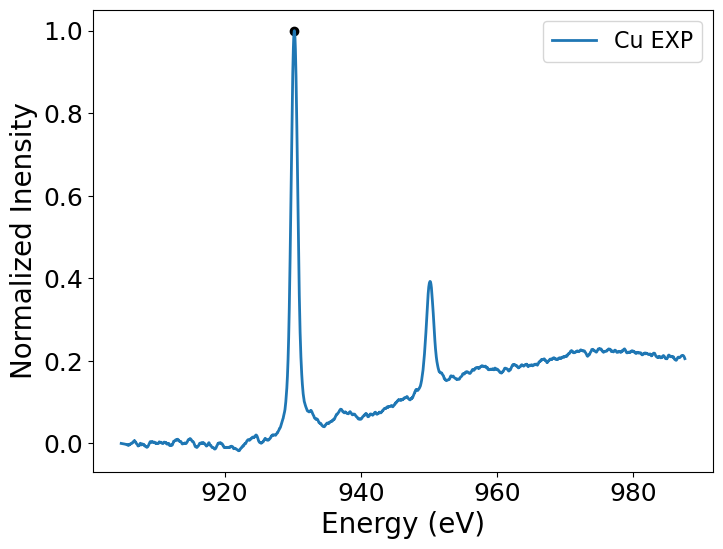

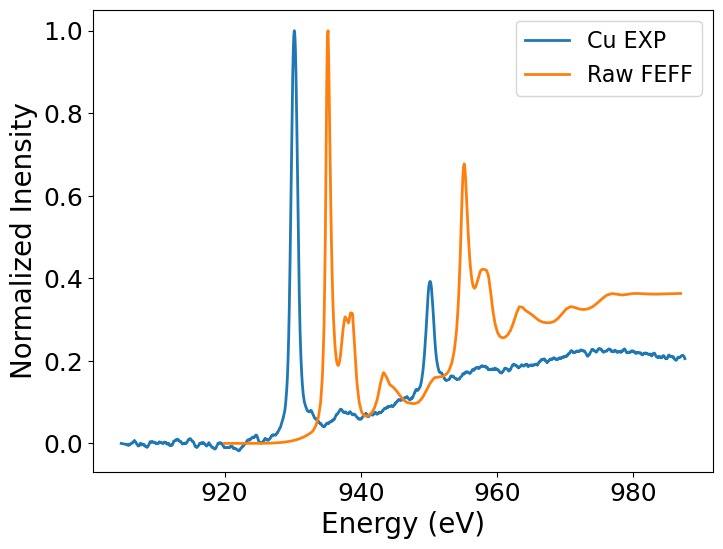

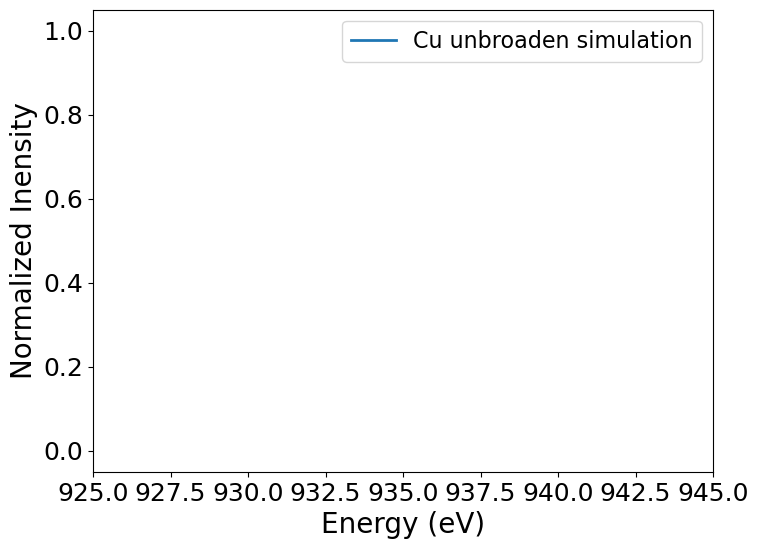

predicted shift = 2498.81051
sim peak = 930.25
exp peak = 930.25


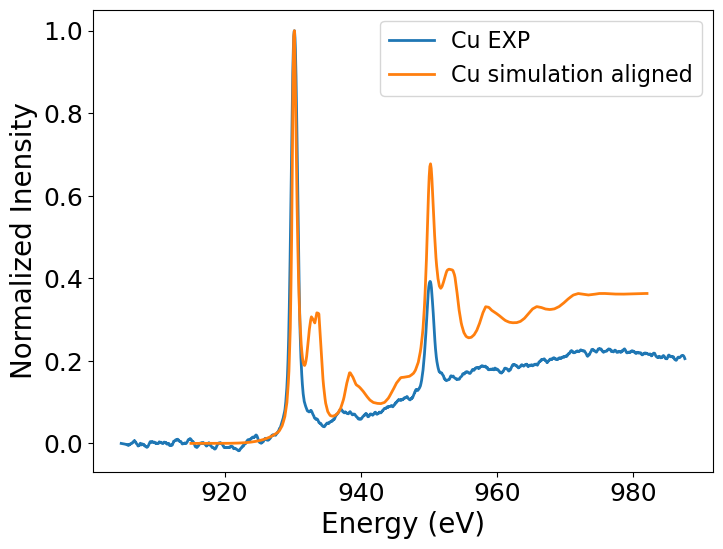

broaden_paras
[0.1, 50]
********Empirical shift initialized********


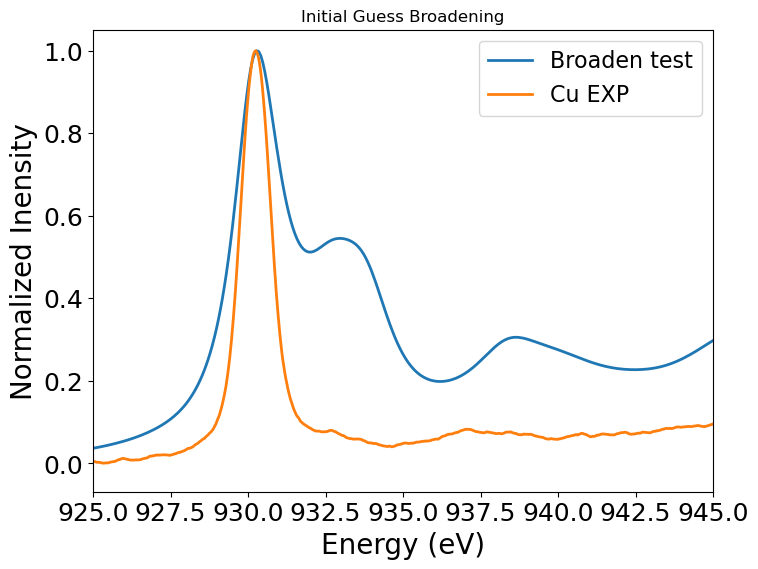

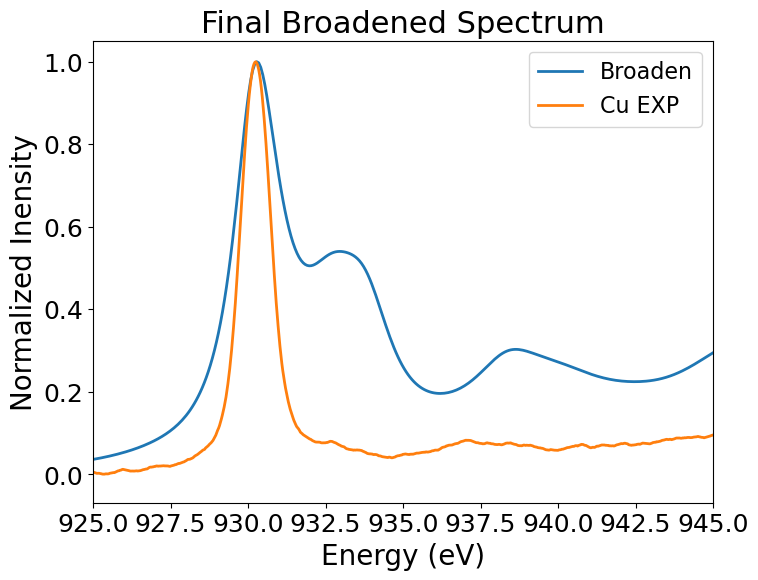

In [34]:
output_CuO = determine_broadening_params(-916.8226, 934.993, -1281.2664, -629.32149, 
                        'C:/Users/smgls/PycharmProjects/ML_XAS_EELS//Cu_deconvolved_spectra/CuO Deconvolved Spectrum.dm4', 
                                         cuo_index, 'TEAM I', scaled_final_df_no_3, fit_range = np.linspace(920,985, 1000, endpoint=True),
                                      manually_align_to_l3 = True, l3_range_simulations = [927,945], 
                                         l3_range_experiments = [927,945])

In [35]:
2498.81051 + -1281.2664 - (-629.32149)

1846.8655999999999

In [36]:
output_CuO[3] = output_CuO[3] + 0.2 # add empirical correction due to rounding errors

[920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920.6, 920.7, 920.8, 920.9, 921.0, 921.1, 921.2, 921.3, 921.4, 921.5, 921.6, 921.7, 921.8, 921.9, 922.0, 922.1, 922.2, 922.3, 922.4, 922.5, 922.6, 922.7, 922.8, 922.9, 923.0, 923.1, 923.2, 923.3, 923.4, 923.5, 923.6, 923.7, 923.8, 923.9, 924.0, 924.1, 924.2, 924.3, 924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925.0, 925.1, 925.2, 925.3, 925.4, 925.5, 925.6, 925.7, 925.8, 925.9, 926.0, 926.1, 926.2, 926.3, 926.4, 926.5, 926.6, 926.7, 926.8, 926.9, 927.0, 927.1, 927.2, 927.3, 927.4, 927.5, 927.6, 927.7, 927.8, 927.9, 928.0, 928.1, 928.2, 928.3, 928.4, 928.5, 928.6, 928.7, 928.8, 928.9, 929.0, 929.1, 929.2, 929.3, 929.4, 929.5, 929.6, 929.7, 929.8, 929.9, 930.0, 930.1, 930.2, 930.3, 930.4, 930.5, 930.6, 930.7, 930.8, 930.9, 931.0, 931.1, 931.2, 931.3, 931.4, 931.5, 931.6, 931.7, 931.8, 931.9, 932.0, 932.1, 932.2, 932.3, 932.4, 932.5, 932.6, 932.7, 932.8, 932.9, 933.0, 933.1, 933.2, 933.3, 933.4, 933.5, 933.6, 933.7, 933.8, 933.9, 934.0, 934.1, 934.2

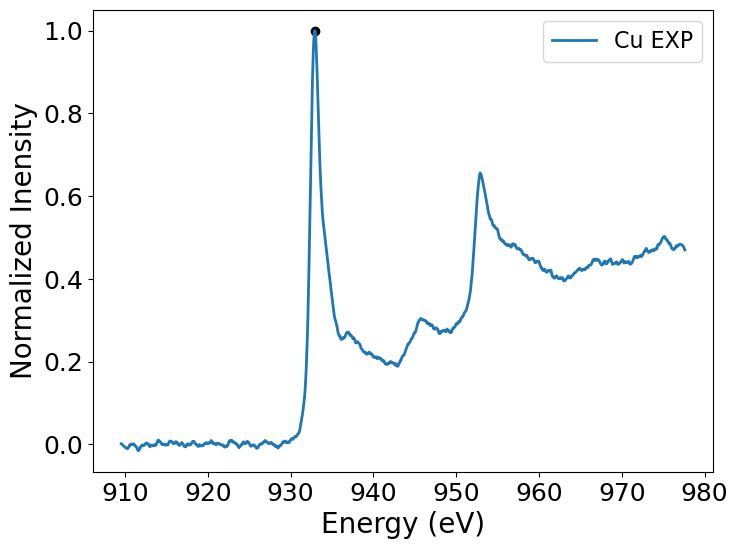

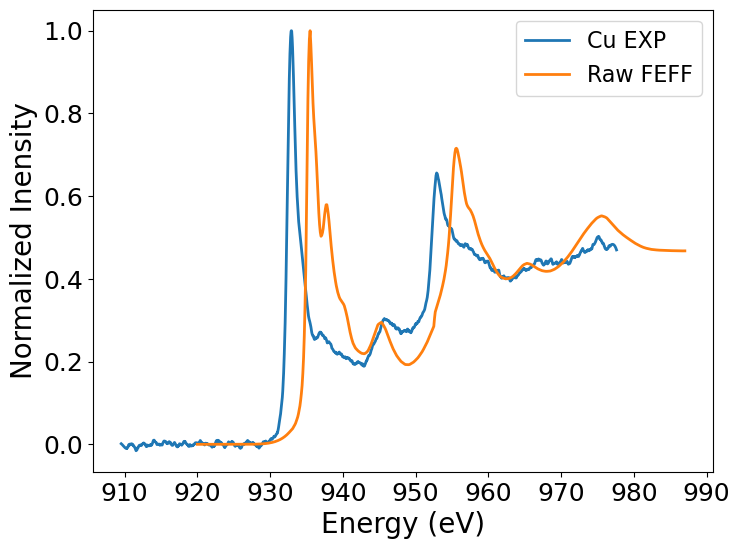

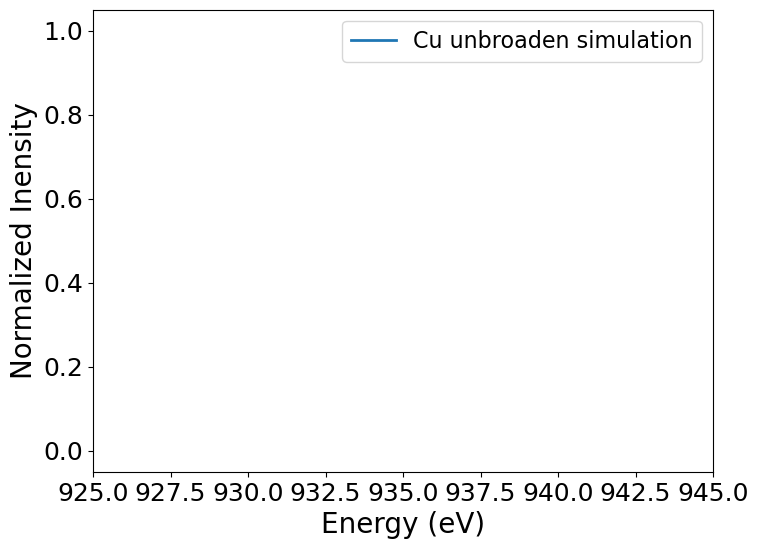

predicted shift = 2500.08344
sim peak = 932.94
exp peak = 932.94


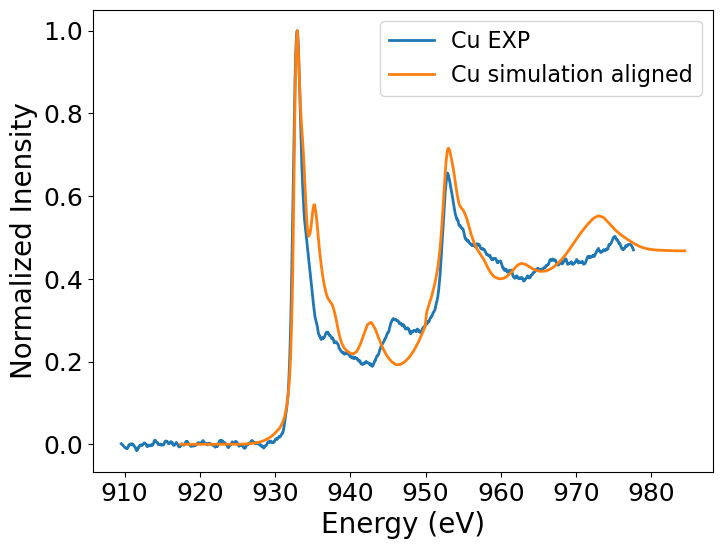

broaden_paras
[0.1, 50]
********Empirical shift initialized********


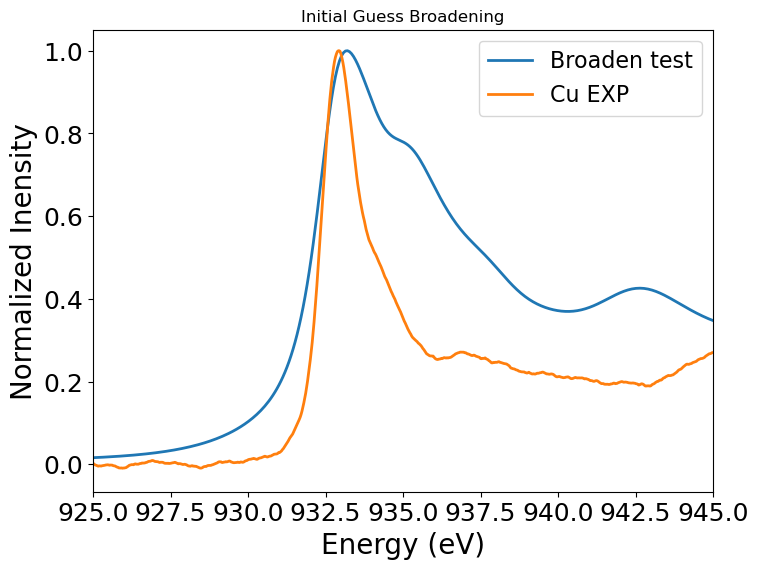

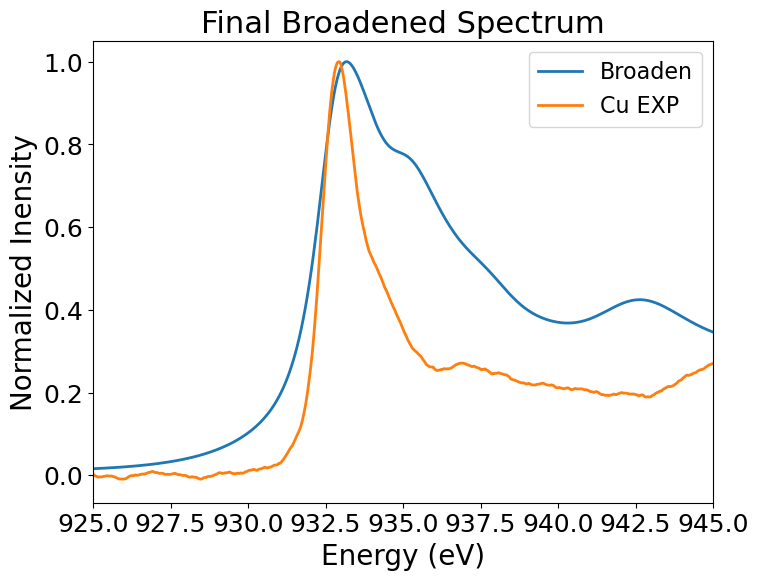

In [37]:
output_Cu2O = determine_broadening_params(-916.8226, 935.073,-1384.9112, -734.16336, 
                                          'C:/Users/smgls/Materials_database/Cu_deconvolved_spectra/Cu2O Deconvolved Spectrum.dm4', 
                                          cu2o_index, 'TEAM I', scaled_final_df_no_3, fit_range = np.linspace(920,985, 1000, endpoint=True),
                                          manually_align_to_l3 = True,  l3_range_simulations = [930,945], 
                                         l3_range_experiments = [930,945])

In [38]:
2500.08344 + -1384.9112 - (-734.16336)

1849.3355999999999

In [39]:
output_Cu2O[3] = output_Cu2O[3] + 0.1 # add empirical correction due to rounding errors

[920.0, 920.1, 920.2, 920.3, 920.4, 920.5, 920.6, 920.7, 920.8, 920.9, 921.0, 921.1, 921.2, 921.3, 921.4, 921.5, 921.6, 921.7, 921.8, 921.9, 922.0, 922.1, 922.2, 922.3, 922.4, 922.5, 922.6, 922.7, 922.8, 922.9, 923.0, 923.1, 923.2, 923.3, 923.4, 923.5, 923.6, 923.7, 923.8, 923.9, 924.0, 924.1, 924.2, 924.3, 924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925.0, 925.1, 925.2, 925.3, 925.4, 925.5, 925.6, 925.7, 925.8, 925.9, 926.0, 926.1, 926.2, 926.3, 926.4, 926.5, 926.6, 926.7, 926.8, 926.9, 927.0, 927.1, 927.2, 927.3, 927.4, 927.5, 927.6, 927.7, 927.8, 927.9, 928.0, 928.1, 928.2, 928.3, 928.4, 928.5, 928.6, 928.7, 928.8, 928.9, 929.0, 929.1, 929.2, 929.3, 929.4, 929.5, 929.6, 929.7, 929.8, 929.9, 930.0, 930.1, 930.2, 930.3, 930.4, 930.5, 930.6, 930.7, 930.8, 930.9, 931.0, 931.1, 931.2, 931.3, 931.4, 931.5, 931.6, 931.7, 931.8, 931.9, 932.0, 932.1, 932.2, 932.3, 932.4, 932.5, 932.6, 932.7, 932.8, 932.9, 933.0, 933.1, 933.2, 933.3, 933.4, 933.5, 933.6, 933.7, 933.8, 933.9, 934.0, 934.1, 934.2

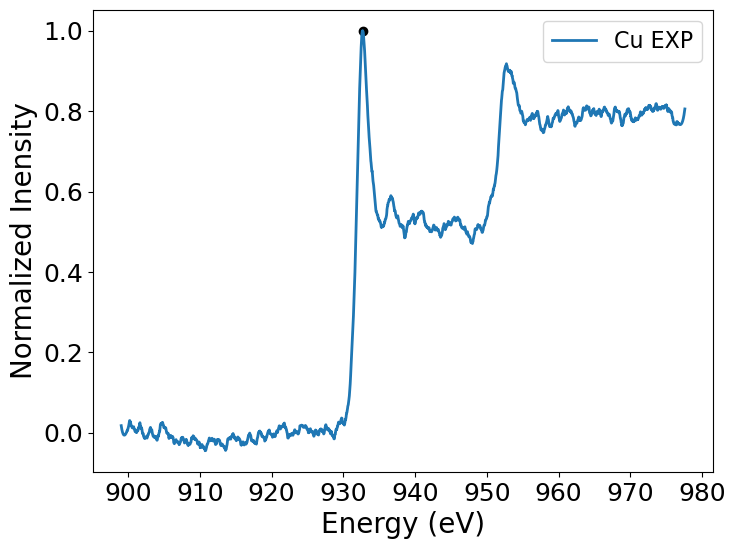

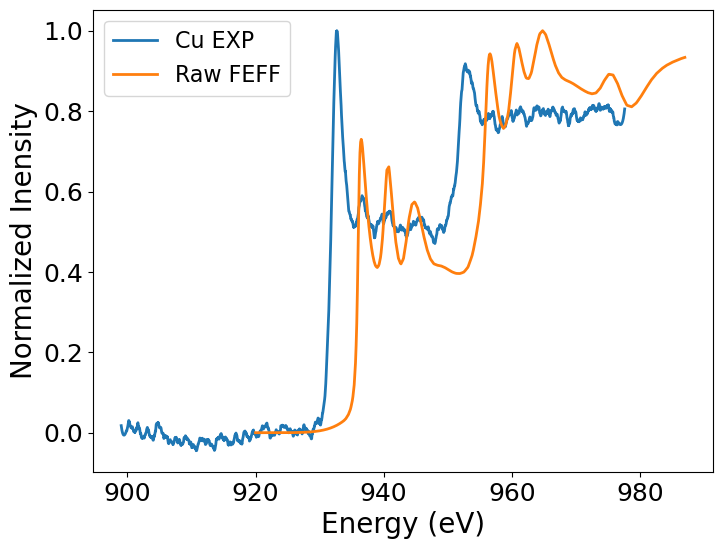

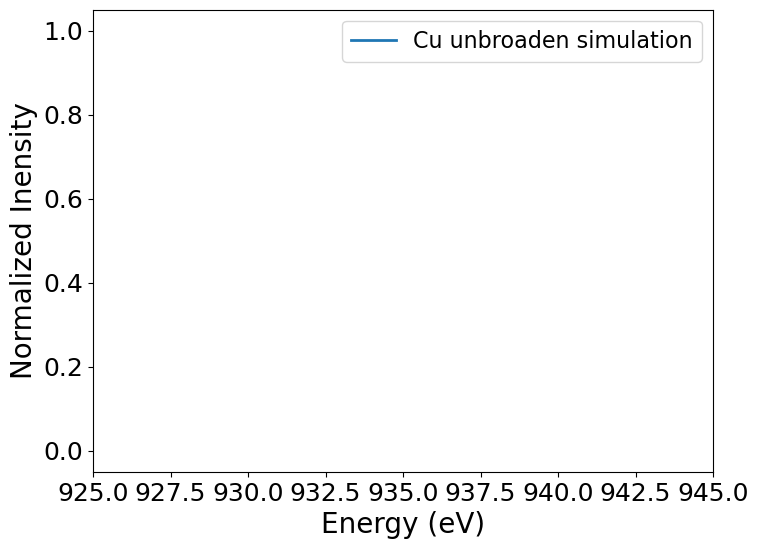

predicted shift = 2499.9477699999998
sim peak = 932.6999999999998
exp peak = 932.7


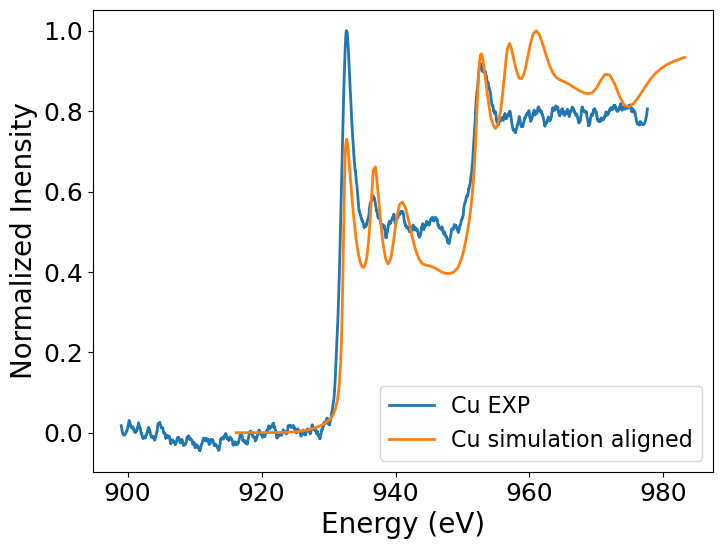

broaden_paras
[0.1, 50]
********Empirical shift initialized********


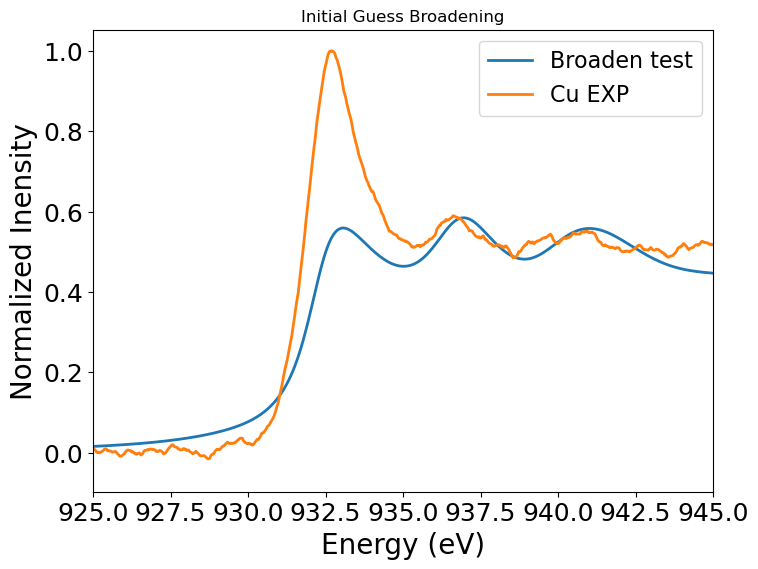

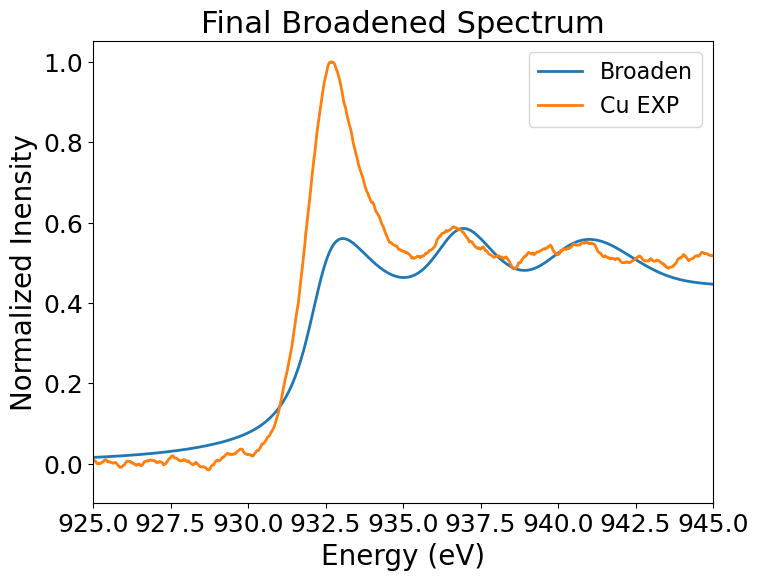

In [40]:
output_Cu_0 = determine_broadening_params(-916.8226, 936.037, -887.13568, -236.24751, 
                                          'C:/Users/smgls/Materials_database/Cu_deconvolved_spectra/Cu Metal Deconvolved Spectrum.dm4', 
                                          cu_metal_index, 'TEAM I', scaled_final_df_no_3, fit_range = np.linspace(920,985, 1000, endpoint=True),
                                          manually_align_to_l3 = True,  l3_range_simulations = [930,945], 
                                         l3_range_experiments = [930,945])

In [41]:
2499.94777 + -887.13568 - (-236.24751) 

1849.0596000000003

In [42]:
output_Cu_0[3] = output_Cu_0[3]+0.2 # add empirical correction due to rounding errors

In [43]:
full_output_params = [output_Cu_0, output_Cu2O, output_CuO]

In [48]:
# joblib.dump(full_output_params, 'full_output_params.joblib')

In [44]:
newer_aligned_df_test_with_zeros = align_by_valence(scaled_final_df_no_3, full_output_params)

0
bv int = 1.0
935.253
broaden_paras
[0.001, 0.1]
********Empirical shift initialized********
bv int less than 1.5 and greater than or equal to 0.5 1.0 shifted by 2500.18344
1
bv int = 0.0
936.068
broaden_paras
[0.001, 0.1]
********Empirical shift initialized********
bv int less than 0.5 0.0 shifted by 2500.1477699999996
2
bv int = 0.0
939.079
broaden_paras
[0.001, 0.1]
********Empirical shift initialized********
bv int less than 0.5 0.0 shifted by 2500.1477699999996
3
bv int = 0.0
936.107
broaden_paras
[0.001, 0.1]
********Empirical shift initialized********
bv int less than 0.5 0.0 shifted by 2500.1477699999996
4
bv int = 0.0
936.178
broaden_paras
[0.001, 0.1]
********Empirical shift initialized********
bv int less than 0.5 0.0 shifted by 2500.1477699999996
5
bv int = 0.0
936.452
broaden_paras
[0.001, 0.1]
********Empirical shift initialized********
bv int less than 0.5 0.0 shifted by 2500.1477699999996
6
bv int = 0.0
936.088
broaden_paras
[0.001, 0.1]
********Empirical shift initial

In [45]:
final_scaled_df = scale_spectra_flex(newer_aligned_df_test_with_zeros, zero_energy = 910, intensity_col = 'NEW Aligned intensities',
                                    energy_col = 'NEW Aligned Energies', output_col_energy = 'Scaled Aligned Energy', 
                                     output_col_intensity = 'Scaled Aligned Intensity')

[917.1599999999996, 916.1689999999996, 913.1579999999997, 916.1299999999997, 916.0589999999997, 915.7849999999996, 916.1489999999997, 916.1199999999997, 913.8379999999997, 915.4939999999997, 917.3529999999998, 915.2919999999995, 915.2139999999997, 916.7859999999998, 915.9339999999997, 916.9259999999995, 915.7729999999997, 915.6589999999997, 916.3869999999997, 915.7109999999998, 915.6979999999996, 915.9199999999996, 916.2319999999995, 916.0869999999995, 915.2659999999996, 916.2139999999995, 913.6709999999996, 915.9669999999996, 916.3469999999998, 915.9164999999996, 915.1399999999996, 915.6639999999998, 915.1309999999996, 916.6319999999996, 916.4249999999997, 916.1999999999996, 914.9094999999998, 915.0604999999996, 917.4779999999998, 916.3739999999996, 914.8649999999998, 916.6139999999998, 915.0789999999997, 915.6489999999997, 914.0939999999996, 911.3809999999996, 916.1734999999996, 914.1679999999997, 914.6739999999995, 915.4729999999995, 915.0359999999996, 915.2129999999997, 915.1099999

C:\Users\smgls\AppData\Local\Temp\ipykernel_42540\137824187.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  A = np.exp(np.log(y[0] / y[1]) / pw)
C:\Users\smgls\AppData\Local\Temp\ipykernel_42540\137824187.py:77: RuntimeWarning: invalid value encountered in scalar divide
  a = (x[0] - x[1] * A) / (A - 1)


interp min = 914.8
interp min = 915.5
interp min = 916.7
interp min = 915.1
interp min = 916.7
interp min = 916.9
interp min = 913.4
interp min = 917.3
interp min = 917.2
interp min = 916.7
interp min = 917.1
interp min = 914.6
interp min = 916.2
interp min = 916.8
interp min = 916.2
interp min = 917.1
interp min = 917.6
interp min = 913.7
interp min = 916.6
interp min = 916.9
interp min = 916.0
interp min = 915.4
interp min = 914.5
interp min = 915.4
interp min = 915.2
interp min = 913.5
interp min = 915.4
interp min = 915.3
interp min = 916.8
interp min = 915.1
interp min = 915.2
interp min = 917.2
interp min = 914.7
interp min = 914.8
interp min = 916.7
interp min = 915.0
interp min = 915.3
interp min = 916.5
interp min = 917.3
interp min = 914.8
interp min = 916.8
interp min = 915.3
interp min = 914.3
interp min = 917.1
interp min = 916.7
interp min = 917.5
interp min = 915.8
interp min = 914.8
interp min = 915.4
interp min = 916.1
interp min = 916.0
interp min = 916.9
interp min =

In [46]:
for i in range(0, len(final_scaled_df)):
    row = final_scaled_df.iloc[i]
    if np.isnan(np.max(row['Scaled Aligned Intensity'])):
        print(i)

In [47]:
spec = []
energies = []
for i in range(0, len(final_scaled_df)):
    spec_temp = np.asarray(final_scaled_df.iloc[i]['Scaled Aligned Intensity'])
    en = np.asarray(final_scaled_df.iloc[i]['Scaled Aligned Energy'])
    spec_temp = spec_temp[150:601]-min(spec_temp[150:601])
    spec_temp = spec_temp/spec_temp[len(spec_temp)-1]
    spec.append(spec_temp)
    energies.append(en[150:601])
final_scaled_df['TEAM_1_aligned_925_970'] = spec
final_scaled_df['new Scaled Energies use'] = energies

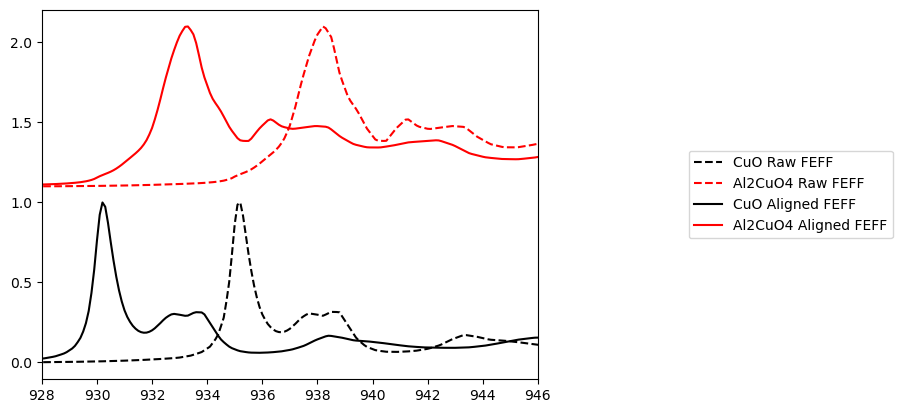

In [48]:
plt.plot(newer_aligned_df_test_with_zeros.iloc[cuo_index]['Scaled Energy (eV)'], newer_aligned_df_test_with_zeros.iloc[cuo_index]['Scaled Intensity']/max(newer_aligned_df_test_with_zeros.iloc[cuo_index]['Scaled Intensity']),
        color = 'k', linestyle = '--', label = 'CuO Raw FEFF')
plt.plot(newer_aligned_df_test_with_zeros.iloc[481]['Scaled Energy (eV)'], 1.1 + newer_aligned_df_test_with_zeros.iloc[481]['Scaled Intensity']/max(newer_aligned_df_test_with_zeros.iloc[481]['Scaled Intensity']),
        color = 'r', linestyle = '--', label = 'Al2CuO4 Raw FEFF')

plt.plot(final_scaled_df.iloc[cuo_index]['new Scaled Energies use'], final_scaled_df.iloc[cuo_index]['TEAM_1_aligned_925_970']/max(final_scaled_df.iloc[cuo_index]['TEAM_1_aligned_925_970']),
        color = 'k', label = 'CuO Aligned FEFF')
plt.plot(final_scaled_df.iloc[481]['new Scaled Energies use'], 1.1 + final_scaled_df.iloc[481]['TEAM_1_aligned_925_970']/max(final_scaled_df.iloc[481]['TEAM_1_aligned_925_970']),
        color = 'r', label = 'Al2CuO4 Aligned FEFF')
plt.legend(bbox_to_anchor = (1.29, 0.5))
plt.xlim([928,946])

plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Cu(II) Alignment.pdf', bbox_inches='tight', transparent=True)

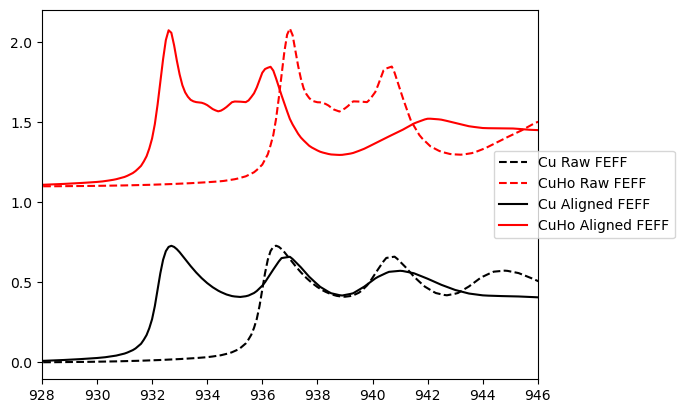

In [51]:
plt.plot(newer_aligned_df_test_with_zeros.iloc[cu_metal_index]['Scaled Energy (eV)'], newer_aligned_df_test_with_zeros.iloc[cu_metal_index]['Scaled Intensity']/max(newer_aligned_df_test_with_zeros.iloc[cu_metal_index]['Scaled Intensity']),
        color = 'k', linestyle = '--', label = 'Cu Raw FEFF')
plt.plot(newer_aligned_df_test_with_zeros.iloc[1556]['Scaled Energy (eV)'], 1.1 + newer_aligned_df_test_with_zeros.iloc[1556]['Scaled Intensity']/max(newer_aligned_df_test_with_zeros.iloc[1556]['Scaled Intensity']),
        color = 'r', linestyle = '--', label = 'CuHo Raw FEFF')

plt.plot(final_scaled_df.iloc[cu_metal_index]['new Scaled Energies use'], final_scaled_df.iloc[cu_metal_index]['TEAM_1_aligned_925_970']/max(final_scaled_df.iloc[cu_metal_index]['TEAM_1_aligned_925_970']),
        color = 'k', label = 'Cu Aligned FEFF')
plt.plot(final_scaled_df.iloc[1556]['new Scaled Energies use'], 1.1 + final_scaled_df.iloc[1556]['TEAM_1_aligned_925_970']/max(final_scaled_df.iloc[1556]['TEAM_1_aligned_925_970']),
        color = 'r', label = 'CuHo Aligned FEFF')
plt.legend(bbox_to_anchor = (1.29, 0.5))
plt.xlim([928,946])

plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Cu(0) Alignment.pdf', bbox_inches='tight', transparent=True)

In [53]:
# mp-704645

experimental spectrum peak location = 932.73
simulated spectrum peak location = 932.7


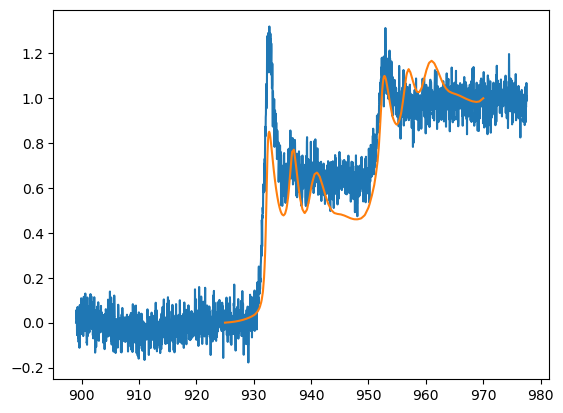

In [54]:
# Cu Metal - Confirm peaks are aligned to experimental spectra to nearest 0.1 eV 

mat_id = 'mp-30'

output = nio.dm.dmReader('C:/Users/smgls/Materials_database/Cu_deconvolved_spectra/Cu Metal Deconvolved Spectrum.dm4')
intens = output['data']/max(output['data'])
energies = output['coords'][0]
x_loc_min = list(energies).index(927)
x_loc_max = list(energies).index(945)
y_max = max(intens[x_loc_min:x_loc_max])
y_max_index = list(intens).index(y_max)
x_peak_loc = energies[y_max_index]
print('experimental spectrum peak location = ' + str(x_peak_loc))
plt.plot(energies, intens/intens[len(intens)-1])

energies1 = np.asarray(final_scaled_df.loc[final_scaled_df['mp_id'] == mat_id]['new Scaled Energies use'])[0]
spec1 = np.asarray(final_scaled_df.loc[final_scaled_df['mp_id'] == mat_id]['TEAM_1_aligned_925_970'])[0]
plt.plot(energies1, spec1)

# energies2 = np.asarray(test_df.loc[test_df['mpid_string'] == mat_id]['new Scaled Energies use'])[0]
# spec2 = np.asarray(test_df.loc[test_df['mpid_string'] == mat_id]['TEAM_1_aligned_925_970'])[0]
# plt.plot(energies2, spec2)

                                                                                                        
x_loc_min = list(energies1).index(930)
x_loc_max = list(energies1).index(945)
y_max = max(spec1[x_loc_min:x_loc_max])
y_max_index = list(spec1).index(y_max)
x_peak_loc = energies1[y_max_index]
print('simulated spectrum peak location = ' + str(x_peak_loc))

                                                                                                        
# x_loc_min = list(energies2).index(930)
# x_loc_max = list(energies2).index(945)
# y_max = max(spec2[x_loc_min:x_loc_max])
# y_max_index = list(spec2).index(y_max)
# x_peak_loc = energies2[y_max_index]
# print(x_peak_loc)

experimental spectrum peak location = 932.82
simulated spectrum peak location = 932.8


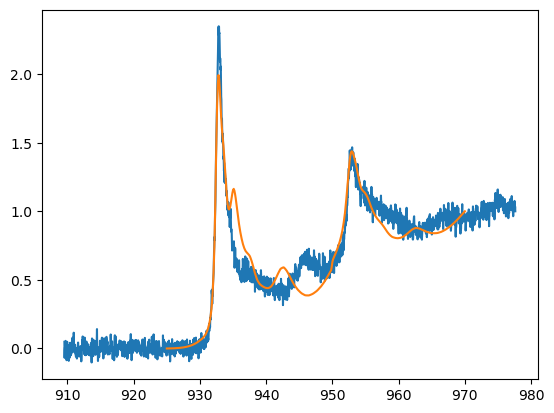

In [55]:
# Cu2O - Confirm peaks are aligned to experimental spectra to nearest 0.1 eV 

mat_id = 'mp-361'


output = nio.dm.dmReader('C:/Users/smgls/Materials_database/Cu_deconvolved_spectra/Cu2O Deconvolved Spectrum.dm4')
intens = output['data']/max(output['data'])
energies = output['coords'][0]
x_loc_min = list(energies).index(927)
x_loc_max = list(energies).index(945)
y_max = max(intens[x_loc_min:x_loc_max])
y_max_index = list(intens).index(y_max)
x_peak_loc = energies[y_max_index]
print('experimental spectrum peak location = ' + str(x_peak_loc))
plt.plot(energies, intens/intens[len(intens)-1])

energies1 = np.asarray(final_scaled_df.loc[final_scaled_df['mp_id'] == mat_id]['new Scaled Energies use'])[0]
spec1 = np.asarray(final_scaled_df.loc[final_scaled_df['mp_id'] == mat_id]['TEAM_1_aligned_925_970'])[0]
plt.plot(energies1, spec1)

# energies2 = np.asarray(test_df.loc[test_df['mpid_string'] == mat_id]['new Scaled Energies use'])[0]
# spec2 = np.asarray(test_df.loc[test_df['mpid_string'] == mat_id]['TEAM_1_aligned_925_970'])[0]
# plt.plot(energies2, spec2)

                                                                                                        
x_loc_min = list(energies1).index(930)
x_loc_max = list(energies1).index(945)
y_max = max(spec1[x_loc_min:x_loc_max])
y_max_index = list(spec1).index(y_max)
x_peak_loc = energies1[y_max_index]
print('simulated spectrum peak location = ' + str(x_peak_loc))

                                                                                                        
# x_loc_min = list(energies2).index(930)
# x_loc_max = list(energies2).index(945)
# y_max = max(spec2[x_loc_min:x_loc_max])
# y_max_index = list(spec2).index(y_max)
# x_peak_loc = energies2[y_max_index]
# print(x_peak_loc)

experimental spectrum peak location = 930.22
simulated spectrum peak location = 930.2


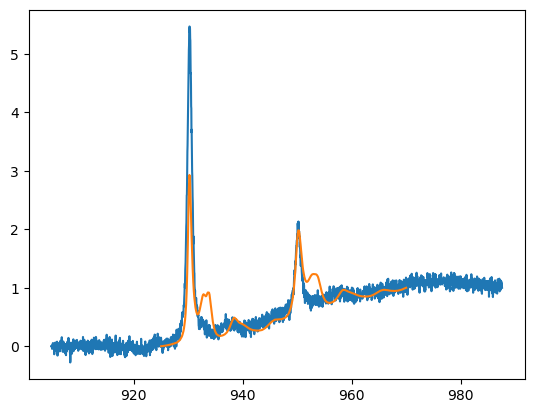

In [56]:
# CuO - Confirm peaks are aligned to experimental spectra to nearest 0.1 eV 

mat_id = 'mp-704645'

output = nio.dm.dmReader('C:/Users/smgls/Materials_database/Cu_deconvolved_spectra/CuO Deconvolved Spectrum.dm4')
intens = output['data']/max(output['data'])
energies = output['coords'][0]
x_loc_min = list(energies).index(927.01)
x_loc_max = list(energies).index(945.01)
y_max = max(intens[x_loc_min:x_loc_max])
y_max_index = list(intens).index(y_max)
x_peak_loc = energies[y_max_index]
print('experimental spectrum peak location = ' + str(x_peak_loc))
plt.plot(energies, intens/intens[len(intens)-1])

energies1 = np.asarray(final_scaled_df.loc[final_scaled_df['mp_id'] == mat_id]['new Scaled Energies use'])[0]
spec1 = np.asarray(final_scaled_df.loc[final_scaled_df['mp_id'] == mat_id]['TEAM_1_aligned_925_970'])[0]
plt.plot(energies1, spec1)

# energies2 = np.asarray(test_df.loc[test_df['mpid_string'] == mat_id]['new Scaled Energies use'])[0]
# spec2 = np.asarray(test_df.loc[test_df['mpid_string'] == mat_id]['TEAM_1_aligned_925_970'])[0]
# plt.plot(energies2, spec2)

                                                                                                        
x_loc_min = list(energies1).index(930)
x_loc_max = list(energies1).index(945)
y_max = max(spec1[x_loc_min:x_loc_max])
y_max_index = list(spec1).index(y_max)
x_peak_loc = energies1[y_max_index]
print('simulated spectrum peak location = ' + str(x_peak_loc))

                                                                                                        
# x_loc_min = list(energies2).index(930)
# x_loc_max = list(energies2).index(945)
# y_max = max(spec2[x_loc_min:x_loc_max])
# y_max_index = list(spec2).index(y_max)
# x_peak_loc = energies2[y_max_index]
# print(x_peak_loc)

In [57]:
def build_cumulative_spectrum(df, column_to_transform= 'TEAM_1_aligned_925_970',
                energy_col = 'new Scaled Energies use'):
    full_cum_spectra = []
    for i in range(0, len(df)):
        # print(i)
        row = df.iloc[i]
        spectrum = np.asarray(row[column_to_transform])
        energies = np.asarray(row[energy_col])
        cum_spectrum = []
        for k in range(0, len(spectrum)):
            cum_spectrum.append(sum(spectrum[0:k]))
        
        # plt.figure(figsize=(8, 7))
        # plt.title(' Spectrum', fontsize = 30)
        # plt.xticks(fontsize=28)
        # plt.yticks(fontsize=28)
        # plt.ylabel('Intensity', fontsize=30)
        # plt.xlabel('Energy (eV)', fontsize=30)
        # plt.plot(energies, spectrum, label = 'Pre Transformation', linewidth = 3)        
        # plt.plot(energies, np.asarray(cum_spectrum)/100, label = 'Cumulative Spectrum', linewidth = 3)
        # plt.legend(fontsize = 16)
        # plt.show()
        full_cum_spectra.append(cum_spectrum/max(cum_spectrum))
        
    df['Cumulative_Spectra_TEAM_1_aligned_925_970'] = full_cum_spectra
    return df

In [58]:
final_scaled_df = build_cumulative_spectrum(final_scaled_df)

In [59]:
final_scaled_df.drop('index', axis = 1, inplace = True)

In [60]:
final_scaled_df.reset_index(inplace = True)

In [61]:
final_scaled_df.columns

Index(['index', 'mp_id', 'Energies', 'Spectrum', 'pretty_formula', 'L3_Fermis',
       'L2_Fermis', 'L3_avg_Fermi', 'L2_avg_Fermi', 'Absorbing_indicies',
       'bv_sum', 'avg_bv_sum', 'bv_sum_0.975', 'avg_bv_sum_0.975',
       'bv_sum_0.95', 'avg_bv_sum_0.95', 'Integer_BV', 'is_stable',
       'theoretical', 'from_mat_proj', 'potential_error', 'full_ox_states',
       'avg_bv_int', 'Scaled Energy (eV)', 'Scaled Intensity',
       'NEW Aligned Energies', 'NEW Aligned intensities',
       'NEW Aligned Broadened', 'NEW BV Used For Alignment',
       'Scaled Aligned Energy', 'Scaled Aligned Intensity',
       'TEAM_1_aligned_925_970', 'new Scaled Energies use',
       'Cumulative_Spectra_TEAM_1_aligned_925_970'],
      dtype='object')

In [62]:
final_scaled_df

index       mp_id                                           Energies  \
0         0    mp-10092  [933.0, 933.1, 933.2, 933.3, 933.4, 933.5, 933...   
1         1  mp-1018685  [933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...   
2         2  mp-1018723  [936.8, 936.9, 937.0, 937.1, 937.2, 937.3, 937...   
3         3  mp-1018724  [933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...   
4         4  mp-1018741  [933.9, 934.0, 934.1, 934.2, 934.3, 934.4, 934...   
...     ...         ...                                                ...   
3434   3434   mp-554097  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3435   3435   mp-569764  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3436   3436   mp-560601  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3437   3437     mp-6090  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3438   3438   mp-545525  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   

                                               Spectrum pretty_formula  \
0     [0.04649283458275886, 0.04829645531248924, 0.0...        KCu4Se3   
1     [0.056876610683152605, 0.0595111463612618, 0.0...         ErCuSn   
2     [0.08242481734137702, 0.08690201565992121, 0.0...       HoCo3Cu2   
3     [0.05905130722742862, 0.061863812668146785, 0....         HoCuSn   
4     [0.06627432876379193, 0.06958478139169977, 0.0...         LaCuPb   
...                                                 ...            ...   
3434  [0.0, 1.091595222533806e-10, 3.034799821635035...      Sm3CuSiS7   
3435  [0.0, 1.1532060619855456e-10, 3.24990569902943...        RbCu2I3   
3436  [0.0, 1.1927709884694547e-10, 3.39019127677229...   K2CuS(ClO2)2   
3437  [0.0, 1.2710747673178537e-10, 3.67270359225144...    Na2Cu(CO3)2   
3438  [0.0, 1.2953609988460249e-10, 3.76162262109277...        NbCuO3F   

      L3_Fermis  L2_Fermis L3_avg_Fermi L2_avg_Fermi Absorbing_indicies  ...  \
0     [935.253]  [955.221]      935.253      955.221                [1]  ...   
1     [936.068]  [956.037]      936.068      956.037                [2]  ...   
2     [939.079]  [959.047]      939.079      959.047                [4]  ...   
3     [936.107]  [956.075]      936.107      956.075                [2]  ...   
4     [936.178]  [956.146]      936.178      956.146                [2]  ...   
...         ...        ...          ...          ...                ...  ...   
3434  [935.726]       None      935.726         None                  6  ...   
3435  [935.026]       None      935.026         None                  4  ...   
3436  [934.996]       None      934.996         None                  8  ...   
3437  [935.006]       None      935.006         None                 20  ...   
3438  [934.873]       None      934.873         None                  7  ...   

                                       Scaled Intensity  \
0     [0.0, 2.0829691853547365e-10, 6.95280520017721...   
1     [0.0, 2.0059781836944448e-10, 6.61613859804468...   
2     [0.0, 1.6493164955755022e-10, 5.12435329755384...   
3     [0.0, 2.0256765867375462e-10, 6.70179539577931...   
4     [0.0, 2.0688473621141926e-10, 6.89067648712017...   
...                                                 ...   
3434  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3435  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3436  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3437  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3438  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                   NEW Aligned Energies  \
0     [917.1599999999996, 917.2599999999995, 917.359...   
1     [916.1689999999996, 916.2689999999996, 916.368...   
2     [913.1579999999997, 913.2579999999996, 913.357...   
3     [916.1299999999997, 916.2299999999998, 916.329...   
4     [916.0589999999997, 916.1589999999999, 916.258...   
...                                                 ...   
3434  [916.6869999999997, 916.7869999999996, 916.886...   
3435  [917.387, 917.4869999999999, 917

In [69]:
# final_scaled_df.drop('level_0', axis = 1, inplace = True)
# final_scaled_df.drop('index', axis = 1, inplace = True)

In [71]:
# final_scaled_df.drop(['Energies', 'Spectrum',
#         'L3_avg_Fermi', 'L2_avg_Fermi',
#        'Absorbing_indicies', 'bv_sum', 'avg_bv_sum', 'bv_sum_0.975',
#        'avg_bv_sum_0.975', 'bv_sum_0.95', 'avg_bv_sum_0.95', 'Integer_BV',
#        'is_stable', 'theoretical', 'from_mat_proj', 'potential_error',
#        'full_ox_states', 'avg_bv_int', 'Scaled Energy (eV)',
#        'Scaled Intensity', 'NEW Aligned Energies', 'NEW Aligned intensities',
#        'NEW Aligned Broadened', 
#        'Scaled Aligned Energy', 'Scaled Aligned Intensity'],
#                     axis = 1, inplace=True)

In [63]:
joblib.dump(final_scaled_df, 'test_deyu_alignment.joblib')
# joblib.dump(final_scaled_df, 'does_this_work.joblib')
# joblib.dump(final_scaled_df, 'Cu_reproducable_alignment_df_extracted_110222.joblib')

['test_deyu_alignment.joblib']

In [81]:
# joblib.dump(final_scaled_df, '920_start_Cu_reproducable_alignment_df_extracted_110222.joblib')

['920_start_Cu_reproducable_alignment_df_extracted_110222.joblib']

In [73]:
# test_rf_obj = eels_rf_setup('temp_cu_paper_test.joblib')
# test_rf_obj = eels_rf_setup('does_this_work.joblib')
test_rf_obj = eels_rf_setup('test_deyu_alignment.joblib')

NameError: name 'eels_rf_setup' is not defined

In [71]:
test_rf_obj.load_spectra_df()

In [72]:
test_rf_obj.spectra_df

index       mp_id                                           Energies  \
0         0    mp-10092  [933.0, 933.1, 933.2, 933.3, 933.4, 933.5, 933...   
1         1  mp-1018685  [933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...   
2         2  mp-1018723  [936.8, 936.9, 937.0, 937.1, 937.2, 937.3, 937...   
3         3  mp-1018724  [933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...   
4         4  mp-1018741  [933.9, 934.0, 934.1, 934.2, 934.3, 934.4, 934...   
...     ...         ...                                                ...   
3434   3434   mp-554097  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3435   3435   mp-569764  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3436   3436   mp-560601  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3437   3437     mp-6090  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   
3438   3438   mp-545525  [924.4, 924.5, 924.6, 924.7, 924.8, 924.9, 925...   

                                               Spectrum  \
0     [0.04649283458275886, 0.04829645531248924, 0.0...   
1     [0.056876610683152605, 0.0595111463612618, 0.0...   
2     [0.08242481734137702, 0.08690201565992121, 0.0...   
3     [0.05905130722742862, 0.061863812668146785, 0....   
4     [0.06627432876379193, 0.06958478139169977, 0.0...   
...                                                 ...   
3434  [0.0, 1.091595222533806e-10, 3.034799821635035...   
3435  [0.0, 1.1532060619855456e-10, 3.24990569902943...   
3436  [0.0, 1.1927709884694547e-10, 3.39019127677229...   
3437  [0.0, 1.2710747673178537e-10, 3.67270359225144...   
3438  [0.0, 1.2953609988460249e-10, 3.76162262109277...   

                                              Structure pretty_formula  \
0     [[2.0039155 2.0039155 4.933876 ] K, [2.0039155...        KCu4Se3   
1     [[0.       0.       3.629002] Er, [0. 0. 0.] E...         ErCuSn   
2     [[0. 0. 0.] Ho, [2.440826  0.        2.0339395...       HoCo3Cu2   
3     [[0.        0.        3.6503785] Ho, [0. 0. 0....         HoCuSn   
4     [[0.        0.        4.0634445] La, [0. 0. 0....         LaCuPb   
...                                                 ...            ...   
3434  [[-0.53962793  3.11652222  4.31700832] Sm, [2....      Sm3CuSiS7   
3435  [[1.35008175 5.78164817 2.58743721] Rb, [ 1.35...        RbCu2I3   
3436  [[ 1.554829    2.98389227 14.98347538] K, [1.5...   K2CuS(ClO2)2   
3437  [[-1.24237856  4.95259874  5.9645451 ] C, [2.9...    Na2Cu(CO3)2   
3438  [[4.05763107 5.28354083 7.45600884] F, [3.7876...        NbCuO3F   

      L3_Fermis  L2_Fermis L3_avg_Fermi L2_avg_Fermi  ...  \
0     [935.253]  [955.221]      935.253      955.221  ...   
1     [936.068]  [956.037]      936.068      956.037  ...   
2     [939.079]  [959.047]      939.079      959.047  ...   
3     [936.107]  [956.075]      936.107      956.075  ...   
4     [936.178]  [956.146]      936.178      956.146  ...   
...         ...        ...          ...          ...  ...   
3434  [935.726]       None      935.726         None  ...   
3435  [935.026]       None      935.026         None  ...   
3436  [934.996]       None      934.996         None  ...   
3437  [935.006]       None      935.006         None  ...   
3438  [934.873]       None      934.873         None  ...   

                                       Scaled Intensity  \
0     [0.0, 2.0829691853547365e-10, 6.95280520017721...   
1     [0.0, 2.0059781836944448e-10, 6.61613859804468...   
2     [0.0, 1.6493164955755022e-10, 5.12435329755384...   
3     [0.0, 2.0256765867375462e-10, 6.70179539577931...   
4     [0.0, 2.0688473621141926e-10, 6.89067648712017...   
...                                                 ...   
3434  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3435  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3436  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3437  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3438  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                             

In [73]:
test_rf_obj.spectra_df['BV Used For Alignment'] = np.asarray(test_rf_obj.spectra_df['NEW BV Used For Alignment'])

In [74]:
test_rf_obj.spectra_df['mpid_string'] = np.asarray(test_rf_obj.spectra_df['mp_id'])

In [75]:
test_rf_obj.augment_df_with_mixtures()

In [76]:
test_rf_obj.spectra_df.drop('level_0', axis = 1, inplace = True)
test_rf_obj.spectra_df.drop('index', axis = 1, inplace = True)

In [77]:
test_rf_obj.spectra_df

mp_id                                           Energies  \
0       mp-10092  [933.0, 933.1, 933.2, 933.3, 933.4, 933.5, 933...   
1     mp-1018685  [933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...   
2     mp-1018723  [936.8, 936.9, 937.0, 937.1, 937.2, 937.3, 937...   
3     mp-1018724  [933.8, 933.9, 934.0, 934.1, 934.2, 934.3, 934...   
4     mp-1018741  [933.9, 934.0, 934.1, 934.2, 934.3, 934.4, 934...   
...          ...                                                ...   
9433         NaN                                                NaN   
9434         NaN                                                NaN   
9435         NaN                                                NaN   
9436         NaN                                                NaN   
9437         NaN                                                NaN   

                                               Spectrum  \
0     [0.04649283458275886, 0.04829645531248924, 0.0...   
1     [0.056876610683152605, 0.0595111463612618, 0.0...   
2     [0.08242481734137702, 0.08690201565992121, 0.0...   
3     [0.05905130722742862, 0.061863812668146785, 0....   
4     [0.06627432876379193, 0.06958478139169977, 0.0...   
...                                                 ...   
9433                                                NaN   
9434                                                NaN   
9435                                                NaN   
9436                                                NaN   
9437                                                NaN   

                                              Structure  \
0     [[2.0039155 2.0039155 4.933876 ] K, [2.0039155...   
1     [[0.       0.       3.629002] Er, [0. 0. 0.] E...   
2     [[0. 0. 0.] Ho, [2.440826  0.        2.0339395...   
3     [[0.        0.        3.6503785] Ho, [0. 0. 0....   
4     [[0.        0.        4.0634445] La, [0. 0. 0....   
...                                                 ...   
9433                                                NaN   
9434                                                NaN   
9435                                                NaN   
9436                                                NaN   
9437                                                NaN   

                            pretty_formula  L3_Fermis  L2_Fermis L3_avg_Fermi  \
0                                  KCu4Se3  [935.253]  [955.221]      935.253   
1                                   ErCuSn  [936.068]  [956.037]      936.068   
2                                 HoCo3Cu2  [939.079]  [959.047]      939.079   
3                                   HoCuSn  [936.107]  [956.075]      936.107   
4                                   LaCuPb  [936.178]  [956.146]      936.178   
...                                    ...        ...        ...          ...   
9433  [Ga4Cu9, Cu6Hg3(AsS3)4, Cs2CuSi5O12]        NaN        NaN          NaN   
9434  [Ga4Cu9, Cu6Hg3(AsS3)4, Cs2CuSi5O12]        NaN        NaN          NaN   
9435  [Ga4Cu9, Cu6Hg3(AsS3)4, Cs2CuSi5O12]        NaN        NaN          NaN   
9436  [Ga4Cu9, Cu6Hg3(AsS3)4, Cs2CuSi5O12]        NaN        NaN          NaN   
9437  [Ga4Cu9, Cu6Hg3(AsS3)4, Cs2CuSi5O12]        NaN        NaN          NaN   

     L2_avg_Fermi Absorbing_indicies  ...  \
0         955.221                [1]  ...   
1         956.037                [2]  ...   
2         959.047                [4]  ...   
3         956.075                [2]  ...   
4         956.146                [2]  ...   
...           ...                ...  ...   
9433          NaN                NaN  ...   
9434          NaN                NaN  ...   
9435          NaN                NaN  ...   
9436          NaN                NaN  ...   
9437          NaN                NaN  ...   

                                  NEW Aligned Broadened  \
0     [0.00016803669180811838, 0.0001693675611498534...   
1     [0.0001675051183793197, 0.00016881482662546755...   
2     [0.0001384592899834398, 0.00013944069863970

In [78]:
test_rf_obj.random_forest_train_bond_valance(bv_column='BV Used For Alignment',
                           spectra_to_predict = 'Cumulative_Spectra_TEAM_1_aligned_925_970',
                        energy_col = 'new Scaled Energies use', 
                                             max_features = 'auto')

len training data = 7076
Using column: Cumulative_Spectra_TEAM_1_aligned_925_970 to predict: BV Used For Alignment
model accuracy (R^2) on simulated test data 0.9022495244182239


num spectra = 2359
model accuracy (R^2) on simulated test data 0.9022495244182239


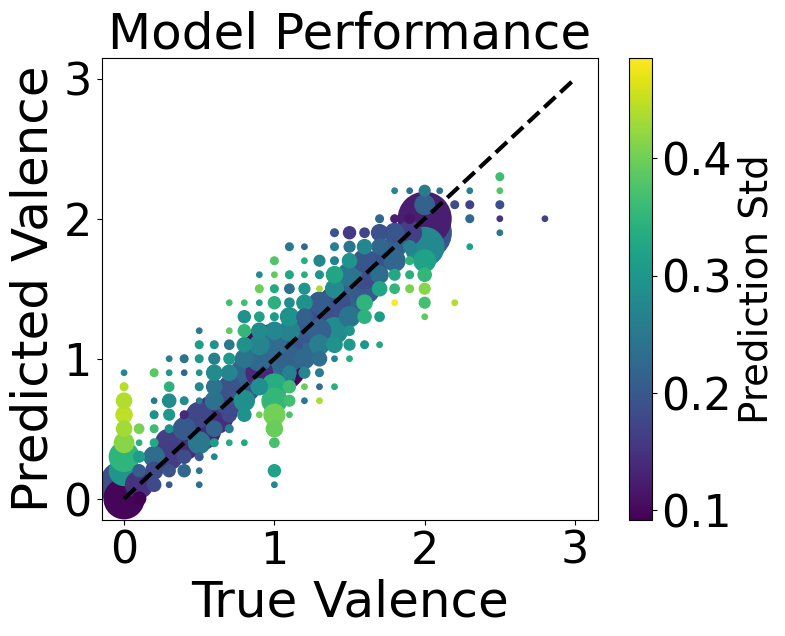

In [79]:
test_rf_obj.show_r2(savefigure=False)

RMSE 0.19588902366615205


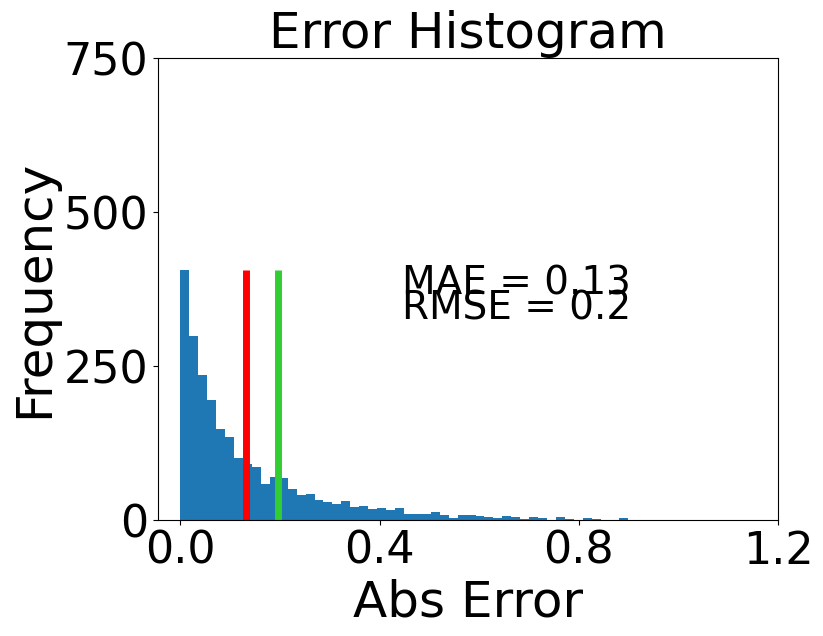

In [80]:
test_rf_obj.show_errors_histogram(savefigure=False)

Predicting From Cu_deconvolved_spectra\Cu Metal Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


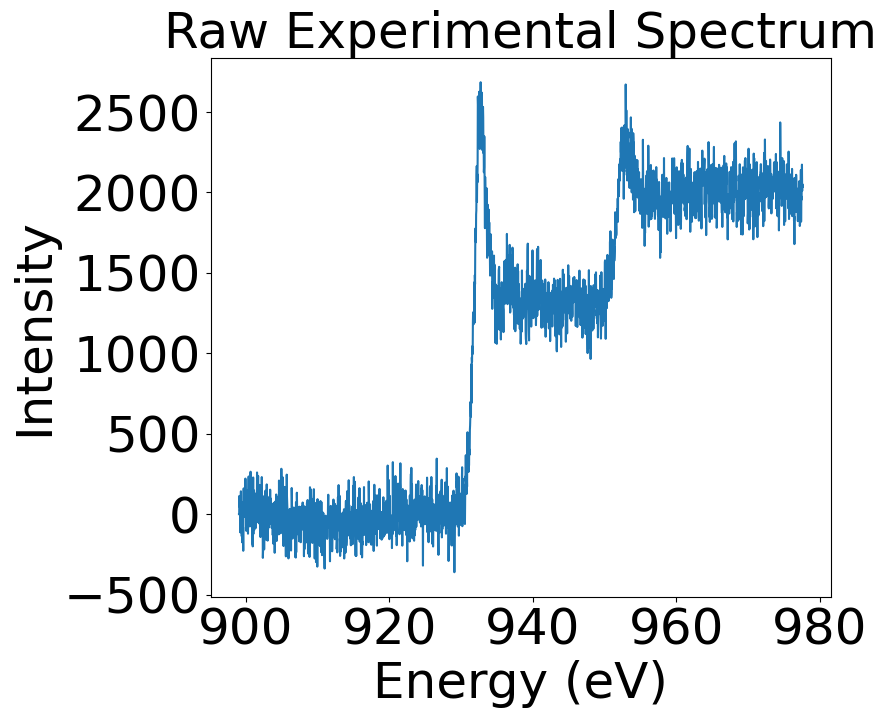

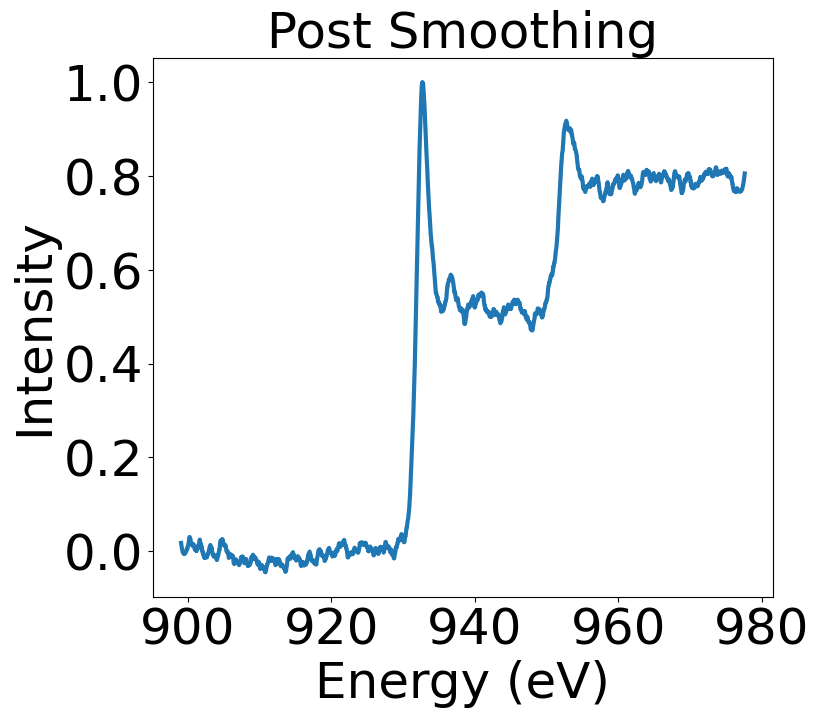

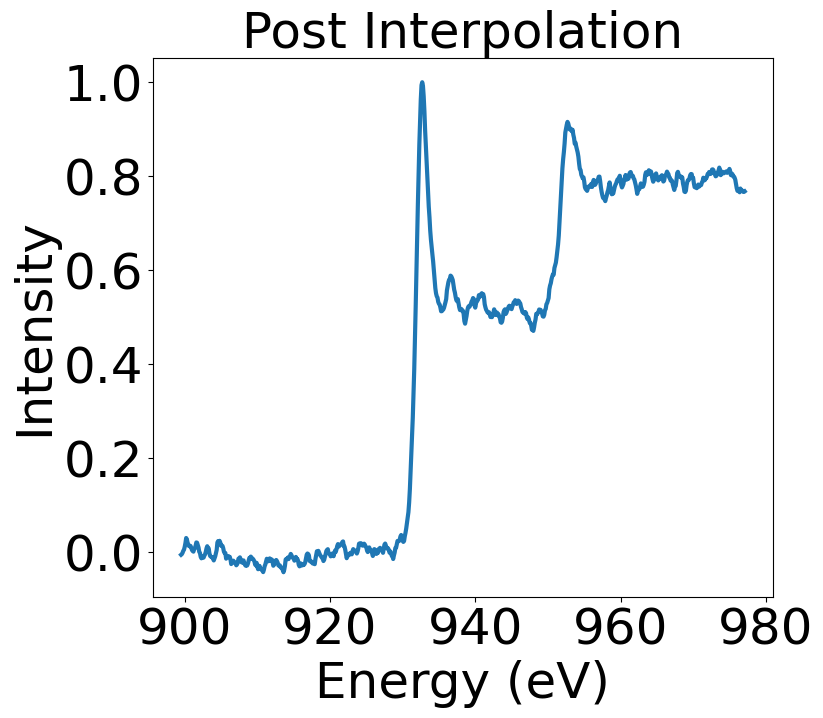

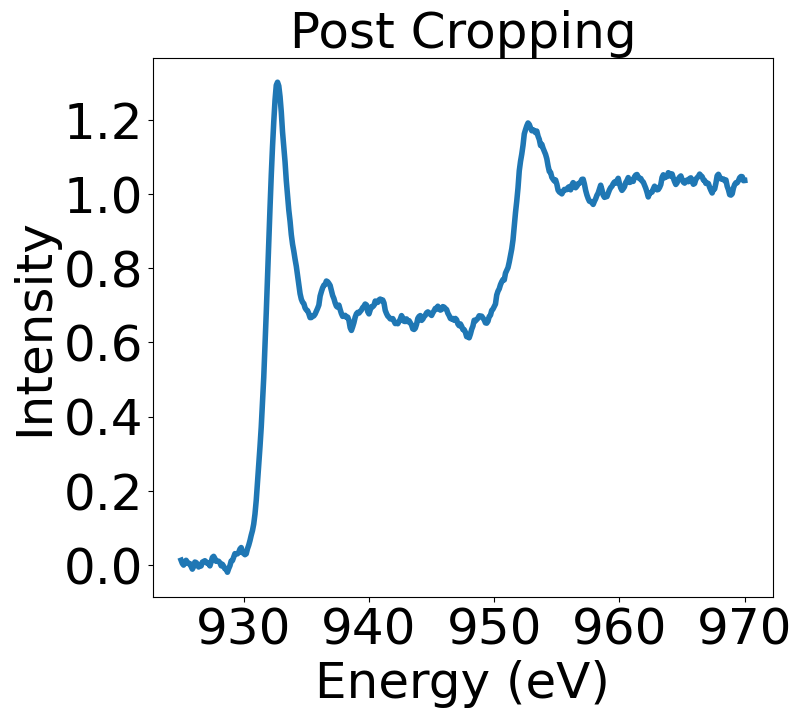

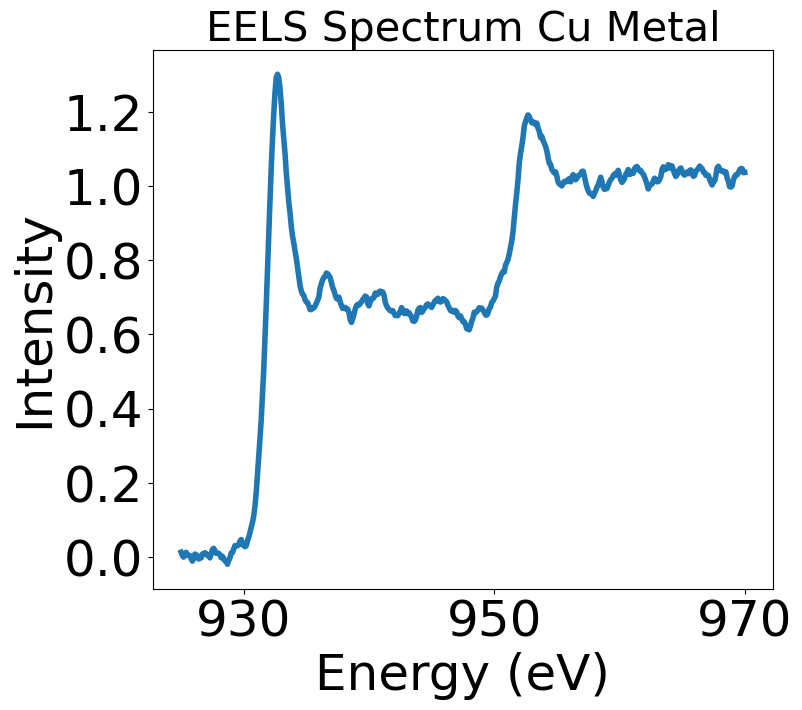

prediction = 0.31
prediction std = 0.35
 


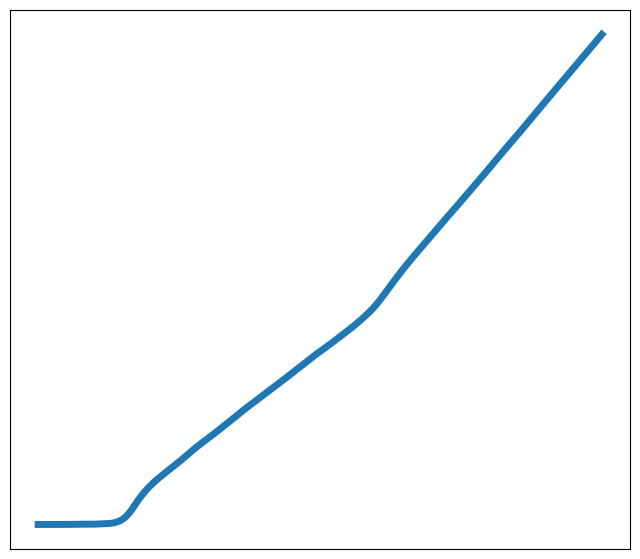

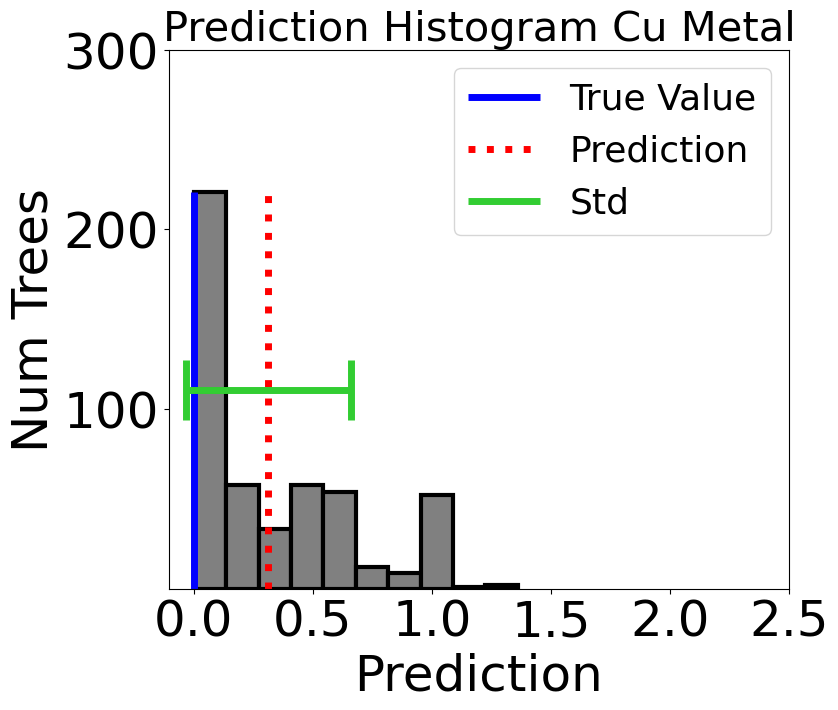

Predicting From Cu_deconvolved_spectra\Cu2O Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


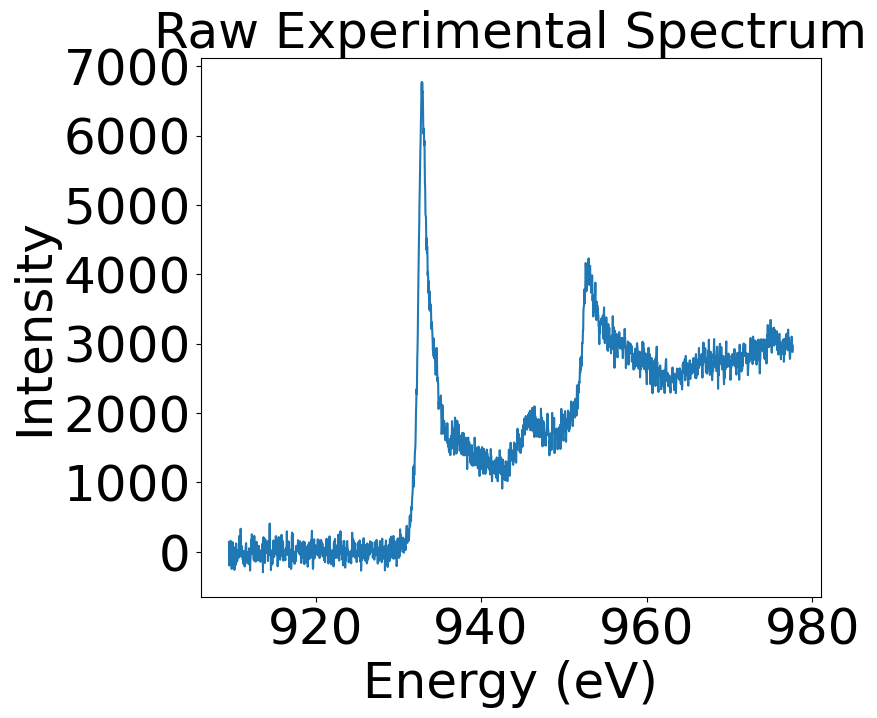

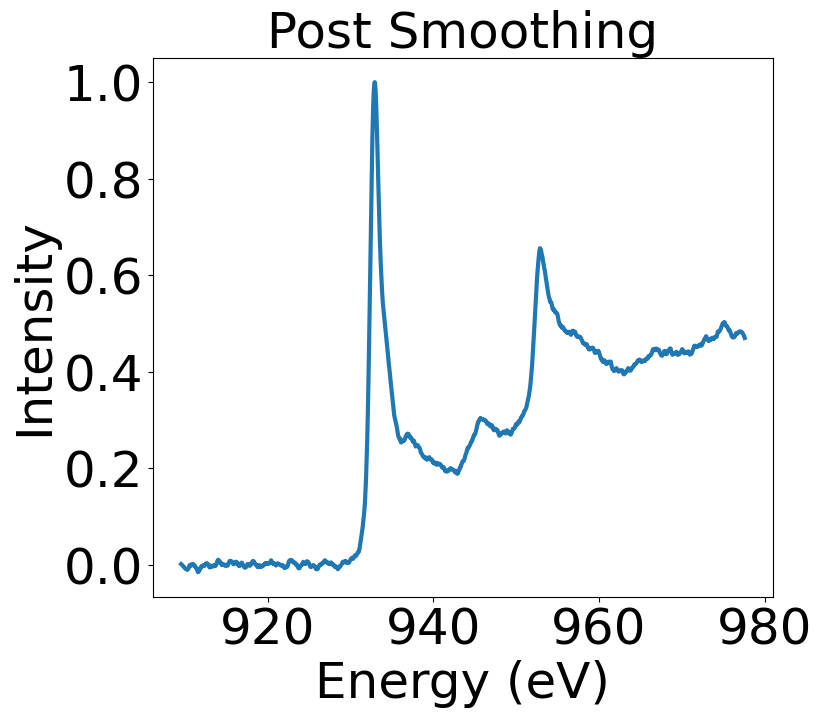

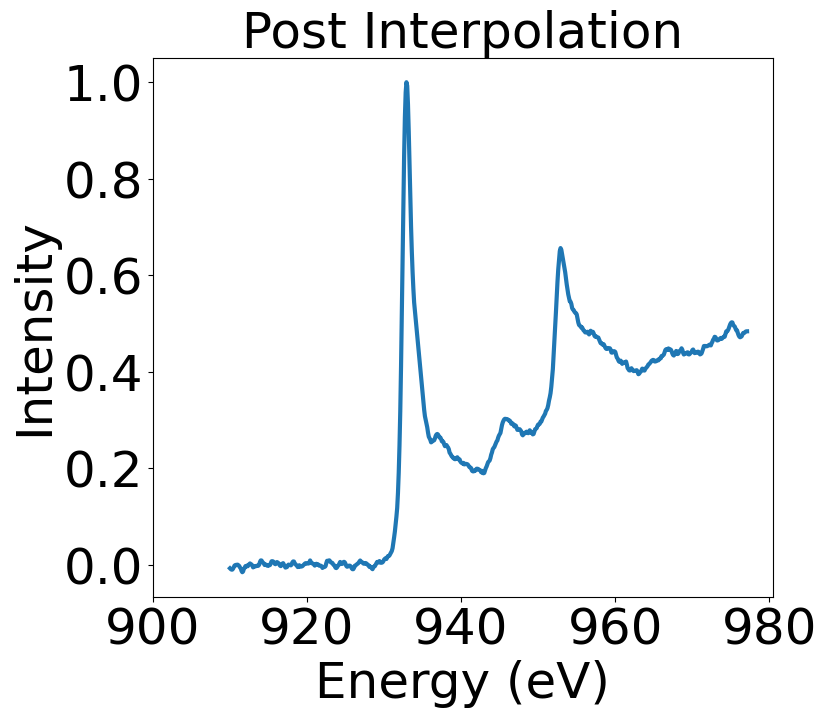

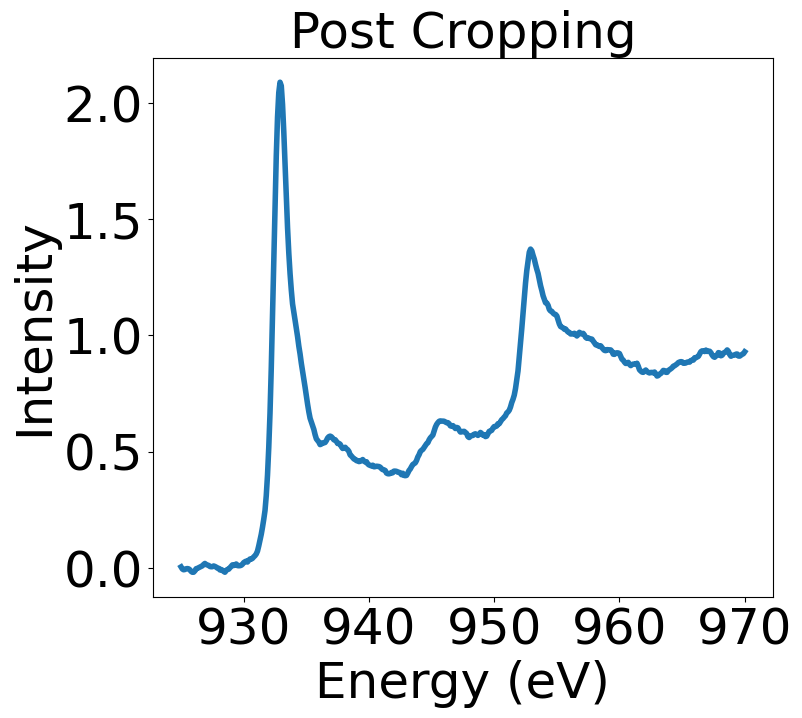

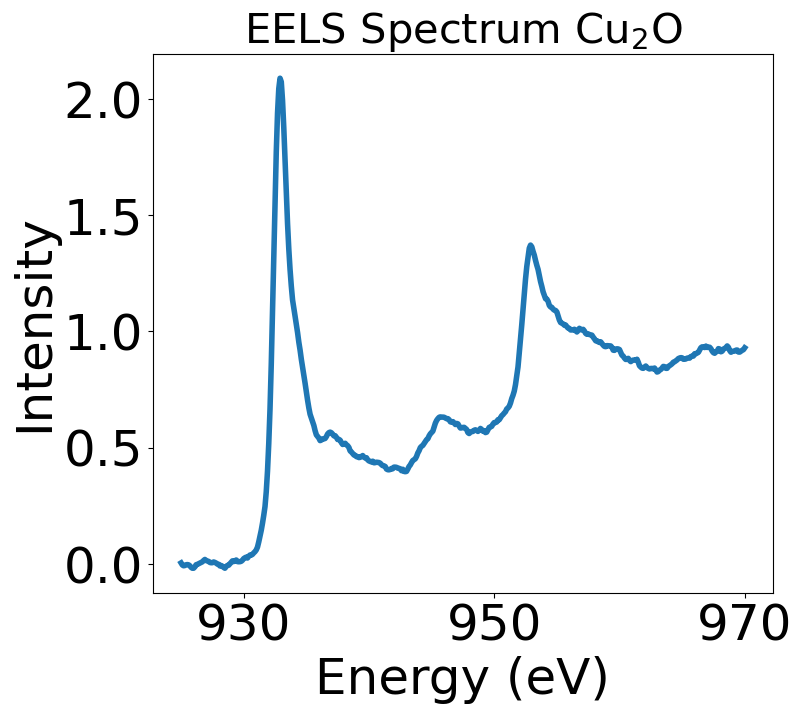

prediction = 1.07
prediction std = 0.19
 


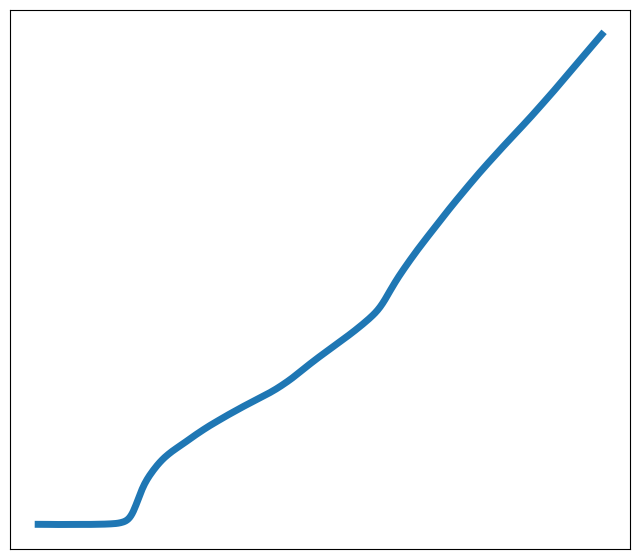

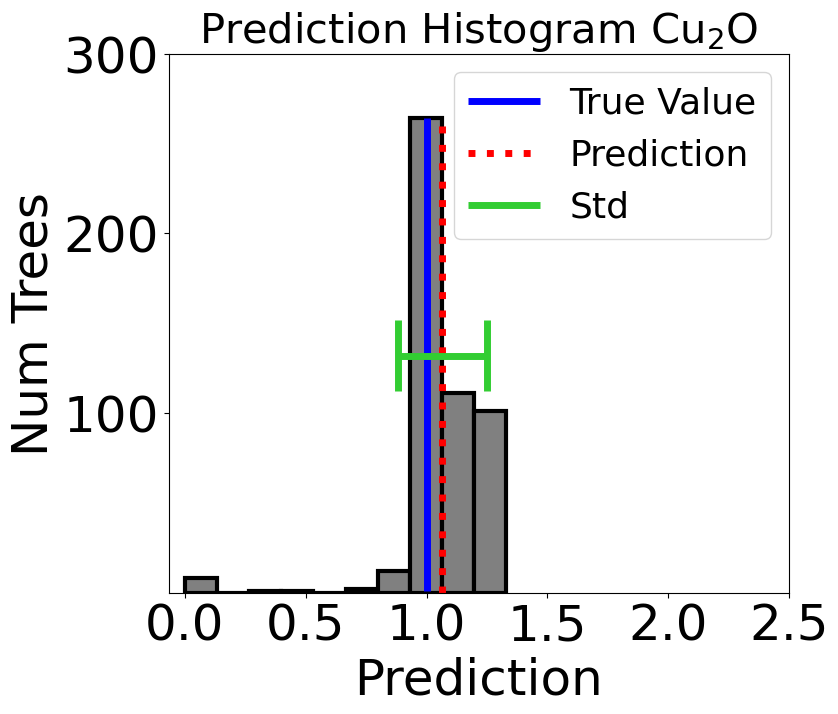

Predicting From Cu_deconvolved_spectra\CuO Deconvolved Spectrum.dm4
Energy Axis Shift = 0
Smoothing Parameters = [51, 3]


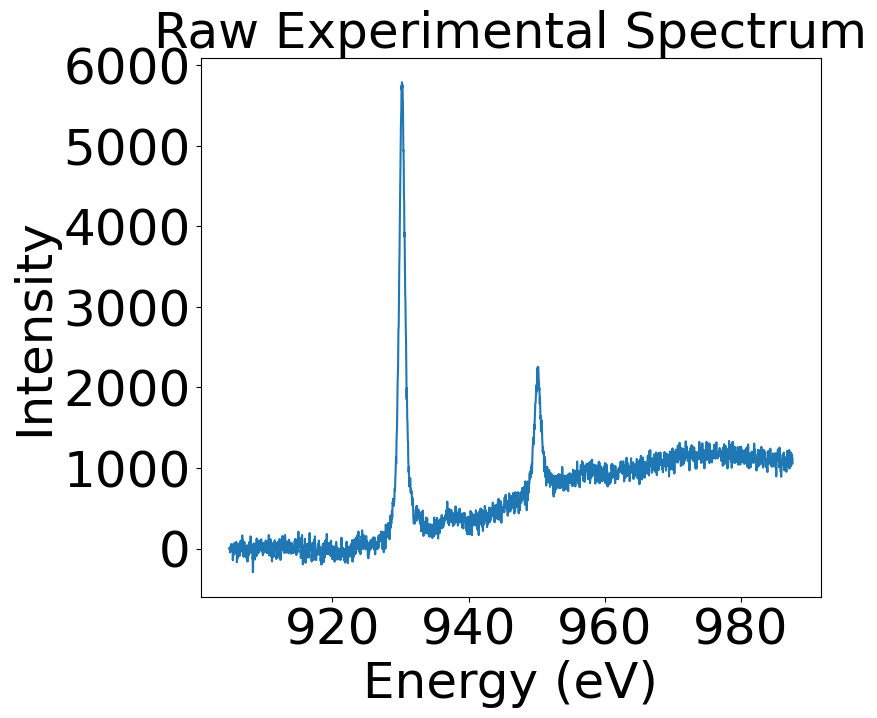

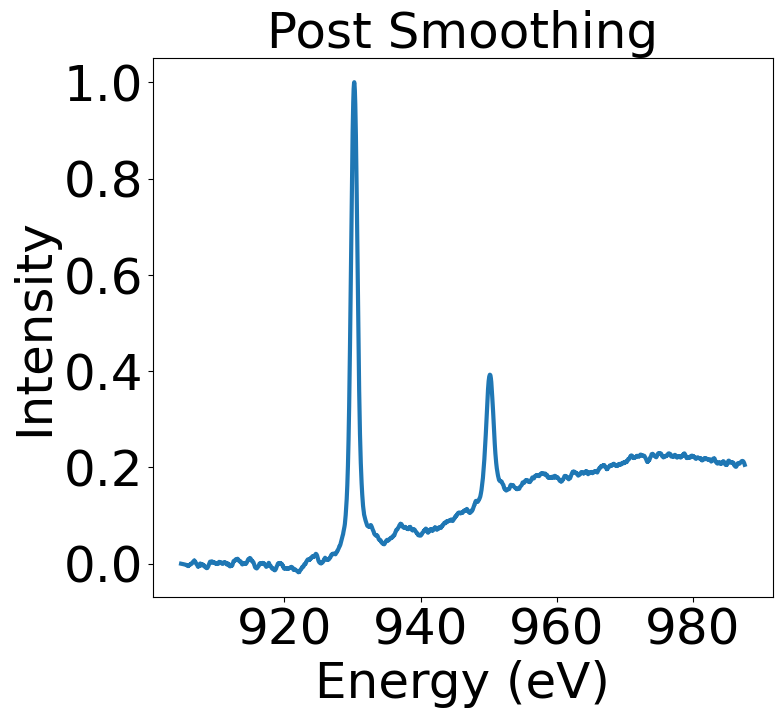

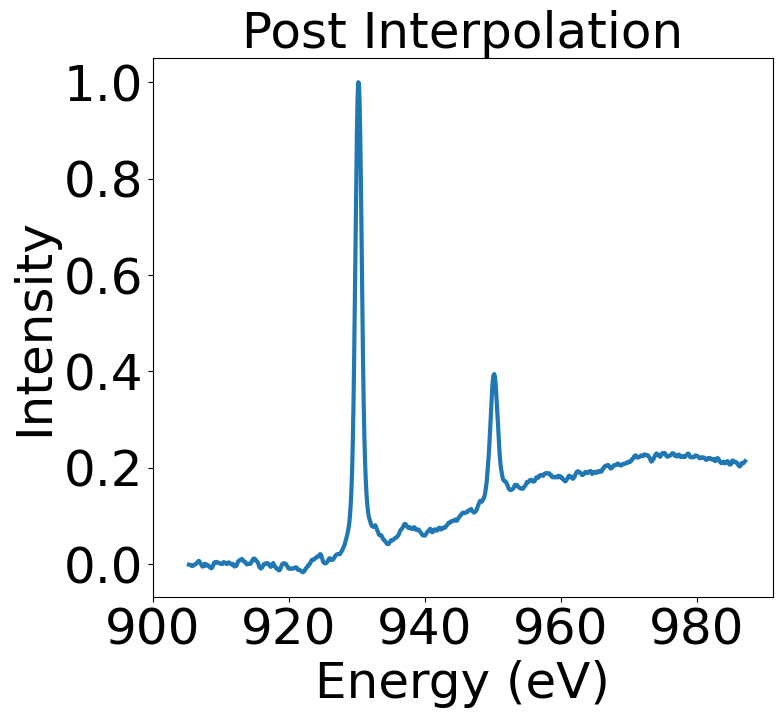

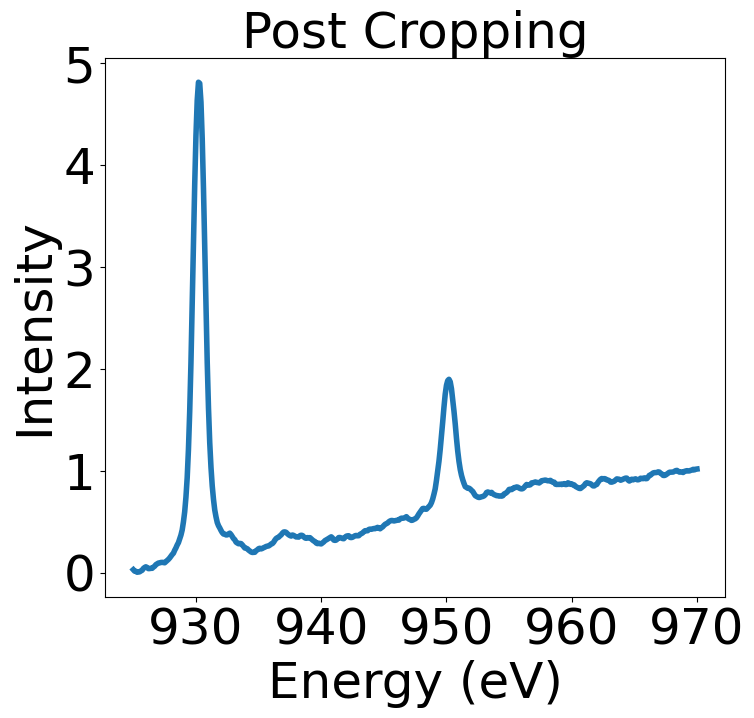

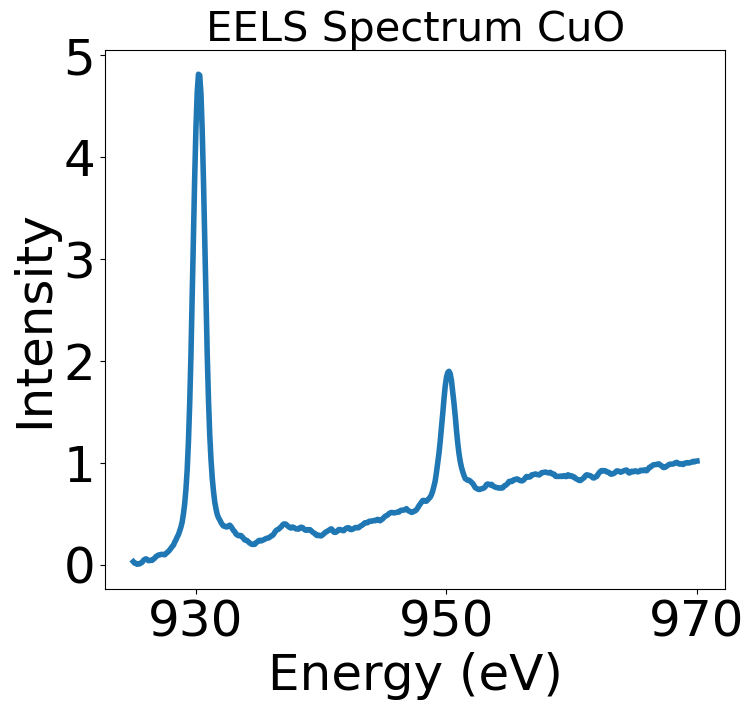

prediction = 2.11
prediction std = 0.2
 


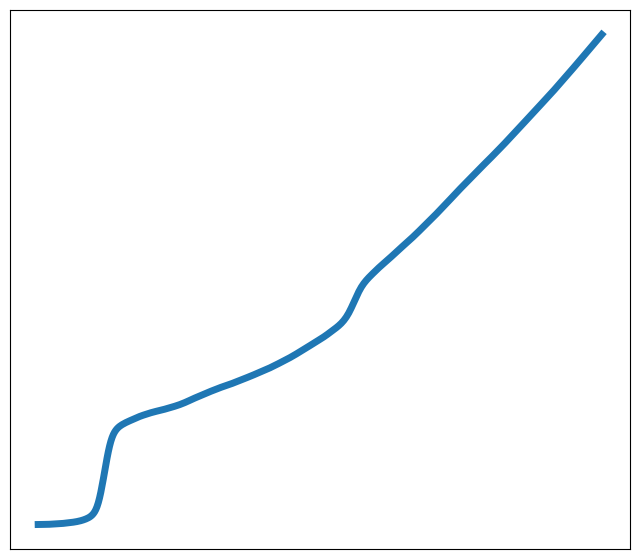

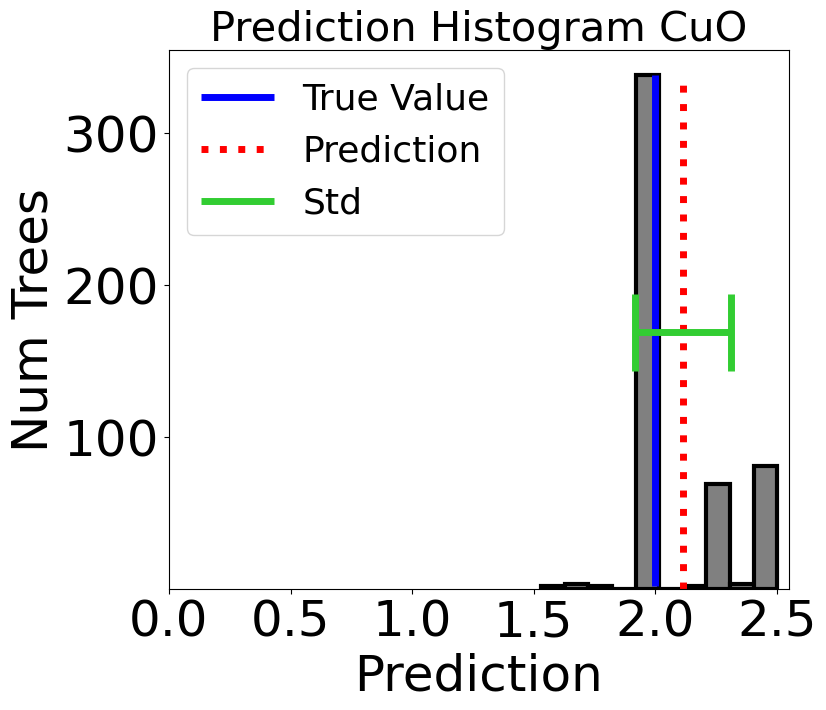

In [81]:
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = [0], theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]], 
                                      show_hist=True, show_inputted_spectrum=True, print_details = True, show_plots=True,
                                     savefigure=False)

In [82]:
shifts = np.linspace(-1.5,1.5,31)

In [83]:
# shift the experimental spectra energy axis and visualize how that impacts prediction 
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', 
                                      shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[51,3]],
                                     print_details = False)

╒══════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Shift (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞══════════════╪══════════════╪══════════════════╪════════════════════════╡
│         -1.5 │         1.9  │             0.41 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.4 │         1.83 │             0.42 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.3 │         1.78 │             0.46 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.2 │         1.74 │             0.47 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.1 │         1.7  │             0.47 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1

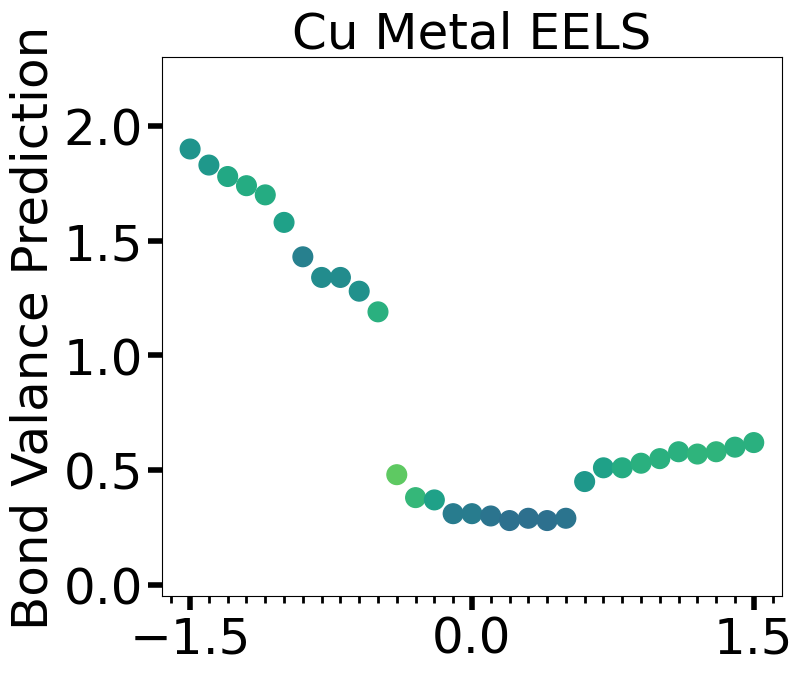

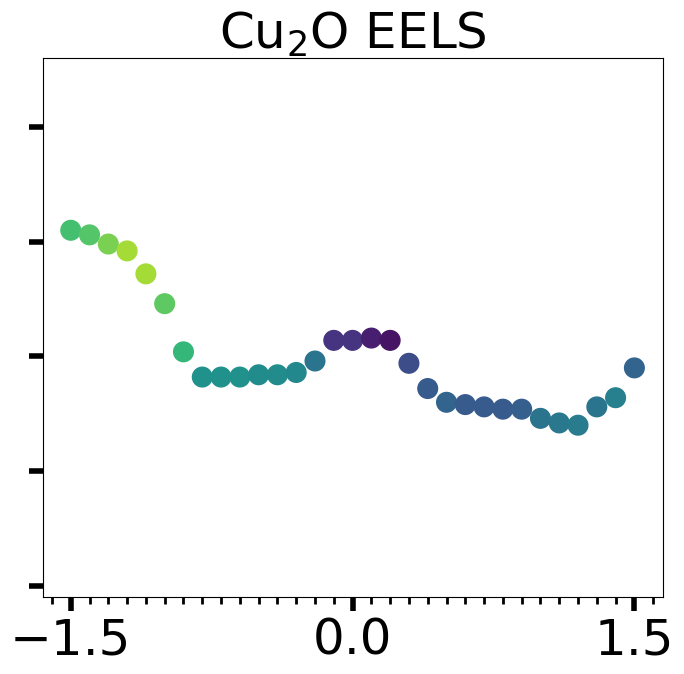

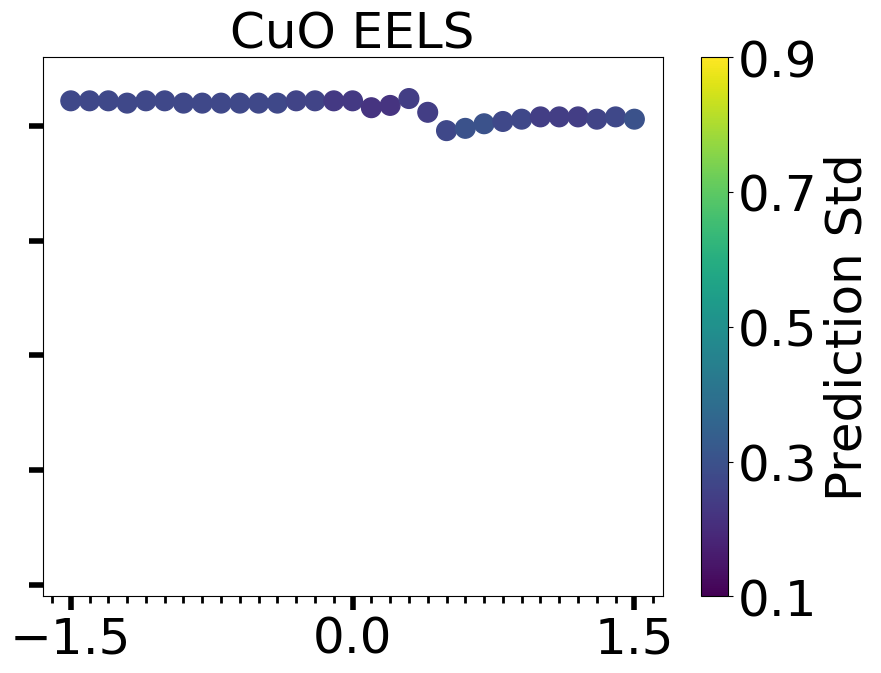

In [84]:
test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = True, savefigure=False, spectrum_type = 'EELS')

In [85]:
# shift the literature spectra energy axis and visualize how that impacts prediction 
# smoothing window is 15 rather than 51 because the extracted literature spectra aren't on an even spacing and need to be 
# interpolated before they can be smoothed. Therefore they are interpolated to 0.1 eV spacing first and then smoothed, 
# so the smoothing window must be correspondingly adjusted to make sure the energy window size remains at 1.5 eV 
test_rf_obj.predict_experiment_folder('xas paper/', spectra_type = 'csv', 
                                      shifts = shifts, theory_column = 'TEAM_1_aligned_925_970', smoothings = [[15,3]],
                                     print_details = False, show_hist=False, show_plots=False)

╒══════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Shift (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞══════════════╪══════════════╪══════════════════╪════════════════════════╡
│         -1.5 │         1.04 │             0.46 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.4 │         0.74 │             0.57 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.3 │         0.53 │             0.56 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.2 │         0.43 │             0.53 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1.1 │         0.39 │             0.45 │                      0 │
├──────────────┼──────────────┼──────────────────┼────────────────────────┤
│         -1

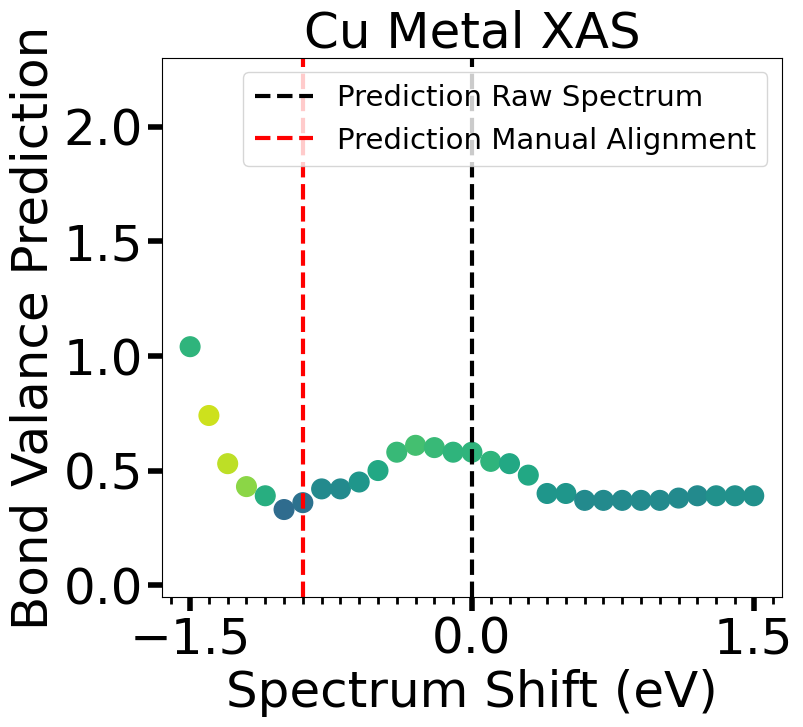

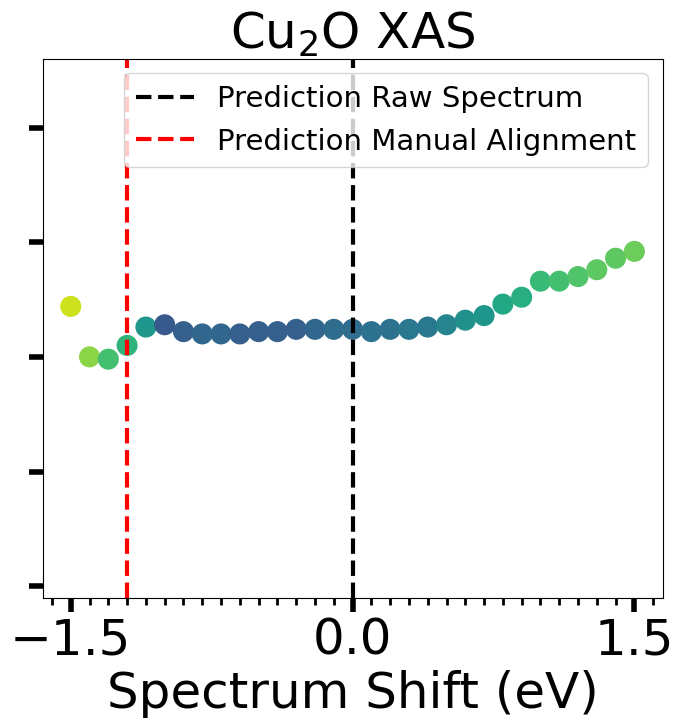

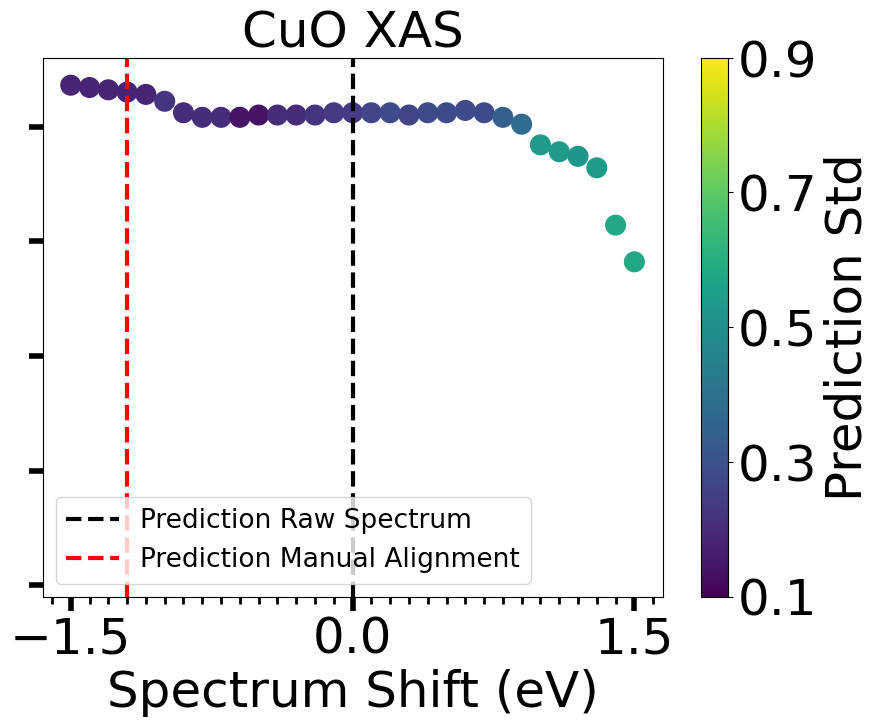

In [86]:
test_rf_obj.visualize_shift(material = 'All', show_stds = False, show_table = True, savefigure=False, show_shift_labels = True,
                                     shift_labels = [-0.9, -1.2, -1.2], spectrum_type = 'XAS')

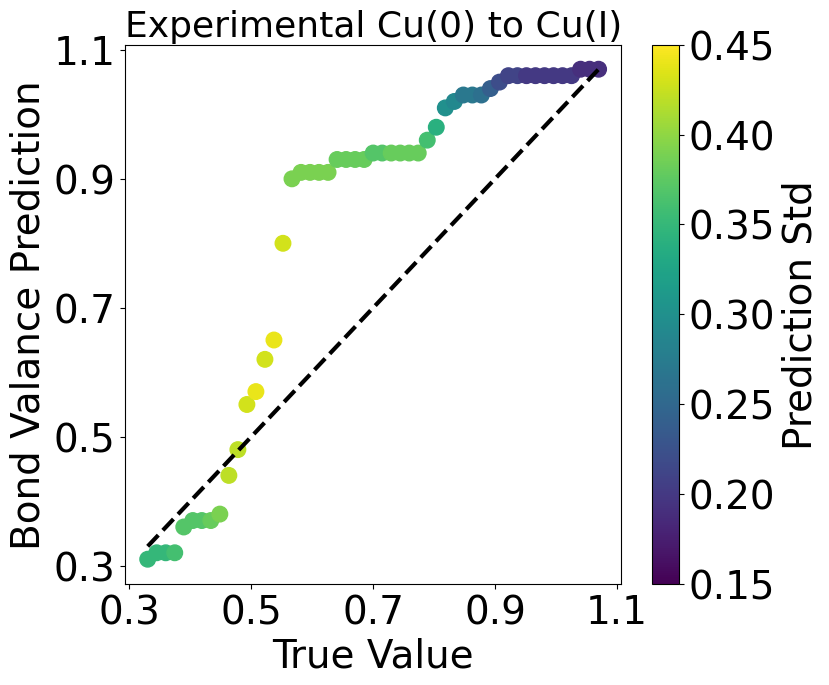

In [87]:
test_rf_obj.experimental_mixed_valent(catagory = '0-1', colorbar_range = [0.15, 0.45], savefigure = False)

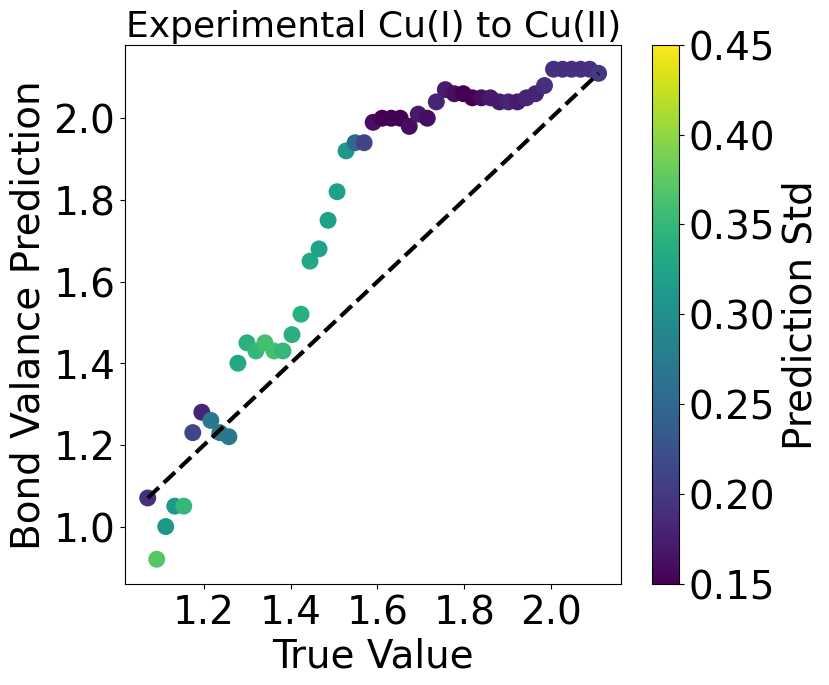

In [88]:
test_rf_obj.experimental_mixed_valent(catagory = '1-2', colorbar_range = [0.15, 0.45], savefigure = False)

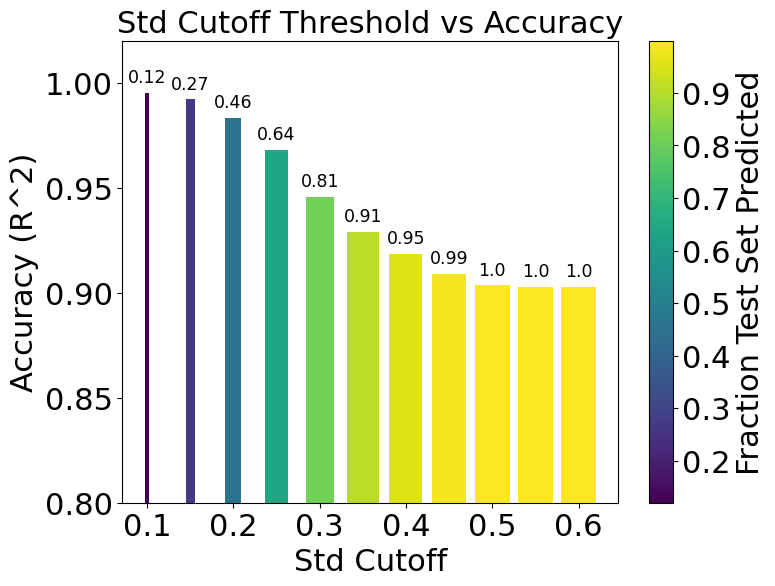

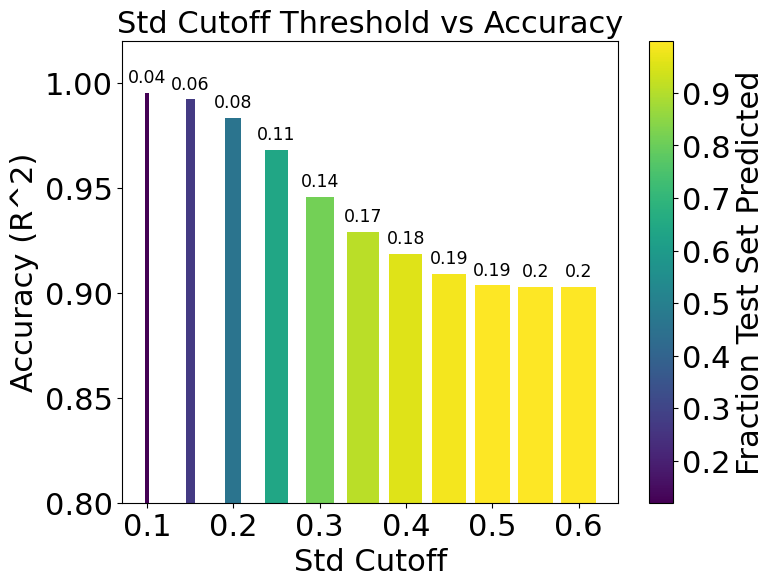

In [89]:
thresholds = np.arange(0.1, 0.65, 0.05)
test_rf_obj.visualize_all_thresholds(thresholds, ylims = [0.8, 1.02], text_fontsize = 12.5, show_type = 'percentage_predicted', 
                                    color_scheme = 'viridis', yticks_to_use = [0.8, 0.85, 0.9, 0.95, 1.0], savefigure=False)
test_rf_obj.visualize_all_thresholds(thresholds, ylims = [0.8, 1.02], text_fontsize = 12.5, show_type = 'RMSE', 
                                    color_scheme = 'viridis', yticks_to_use = [0.8, 0.85, 0.9, 0.95, 1.0], savefigure=False)

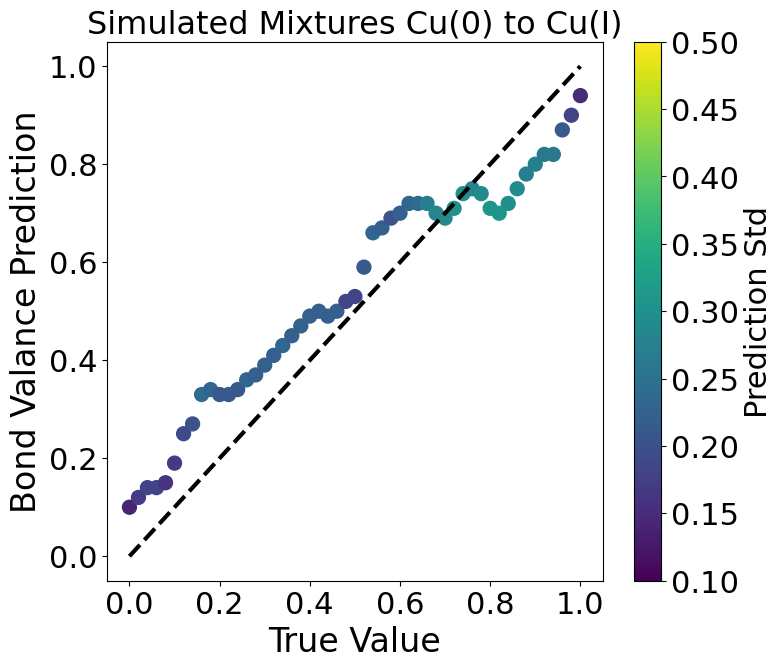

In [90]:
test_rf_obj.simulated_mixed_valent(catagory = '0-1', savefigure=False)

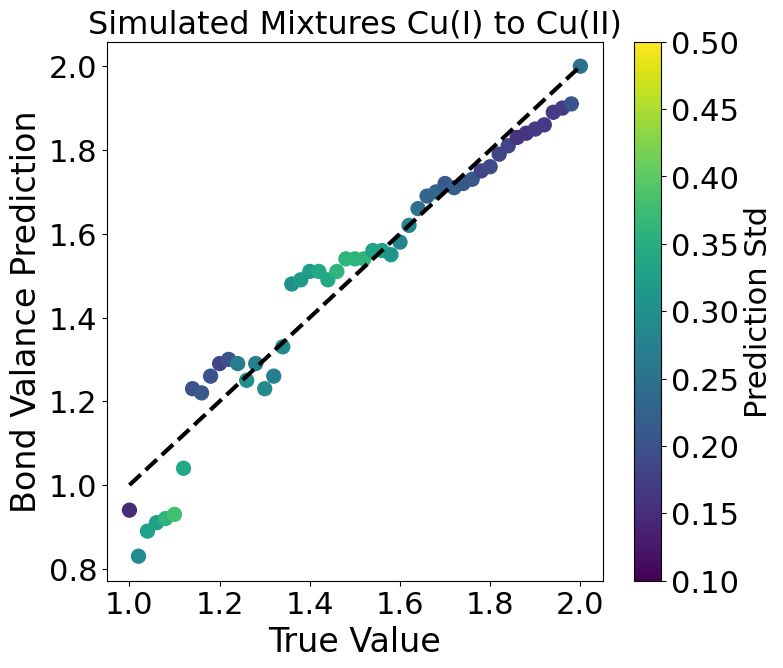

In [91]:
test_rf_obj.simulated_mixed_valent(catagory = '1-2', savefigure=False)

In [92]:
smoothings = [[5,3], [21,3], [35,3], [51,3], [75,3], [101,3], [125,3], [151,3]]

In [93]:
test_rf_obj.predict_experiment_folder('Cu_deconvolved_spectra/', spectra_type = 'TEAM I', show_plots=False,
                                      shifts = [0.0], theory_column = 'TEAM_1_aligned_925_970', smoothings = smoothings, 
                                      show_hist=False, show_inputted_spectrum=False, savefigure=False, print_details=False)

╒═════════════════════════╤══════════════╤══════════════════╤════════════════════════╕
│   Smoothing Window (eV) │   Prediction │   Prediction STD │   True Oxidation State │
╞═════════════════════════╪══════════════╪══════════════════╪════════════════════════╡
│                    0.15 │         0.37 │             0.4  │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    0.63 │         0.32 │             0.36 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    1.05 │         0.3  │             0.34 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    1.53 │         0.31 │             0.35 │                      0 │
├─────────────────────────┼──────────────┼──────────────────┼────────────────────────┤
│                    2.25 │         0.3  │ 

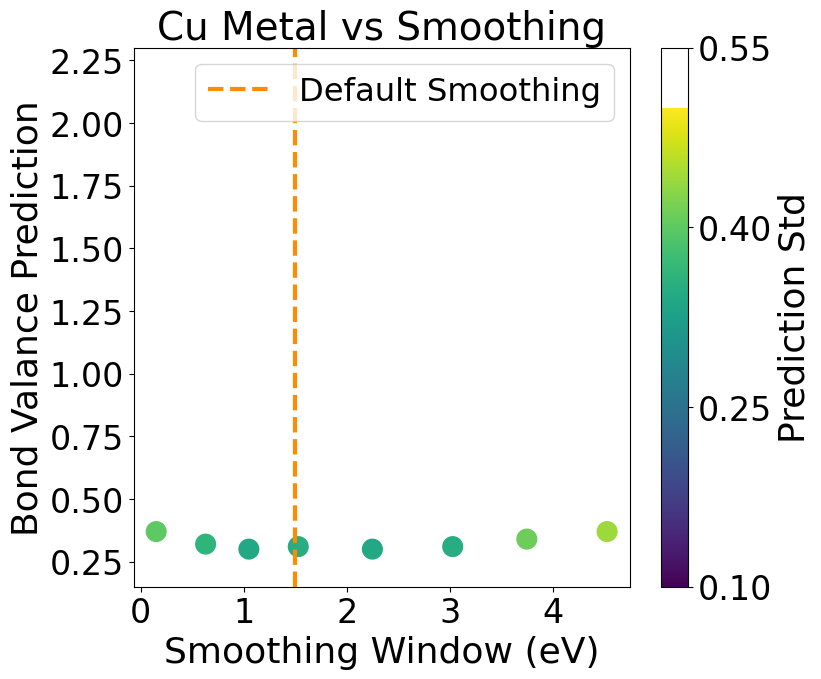

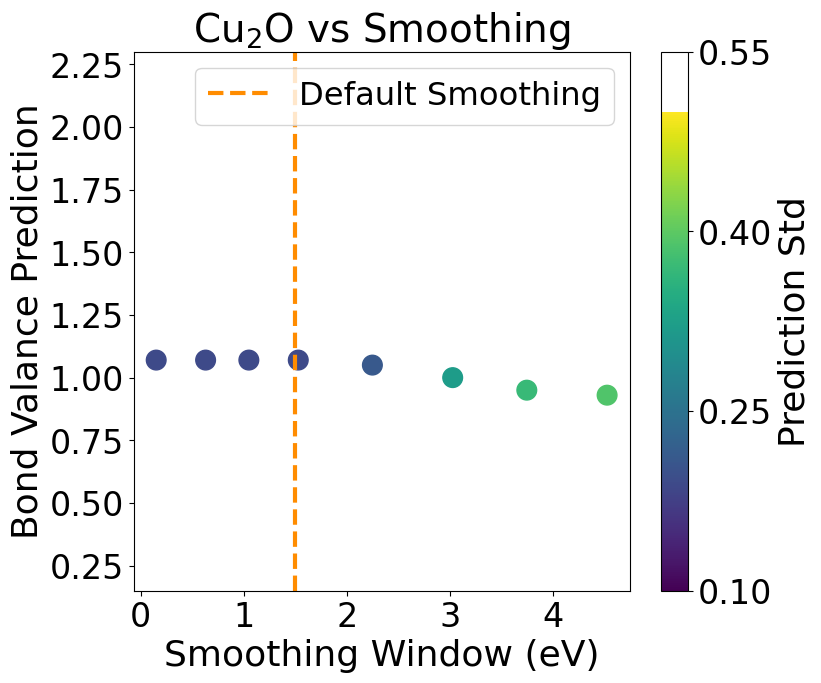

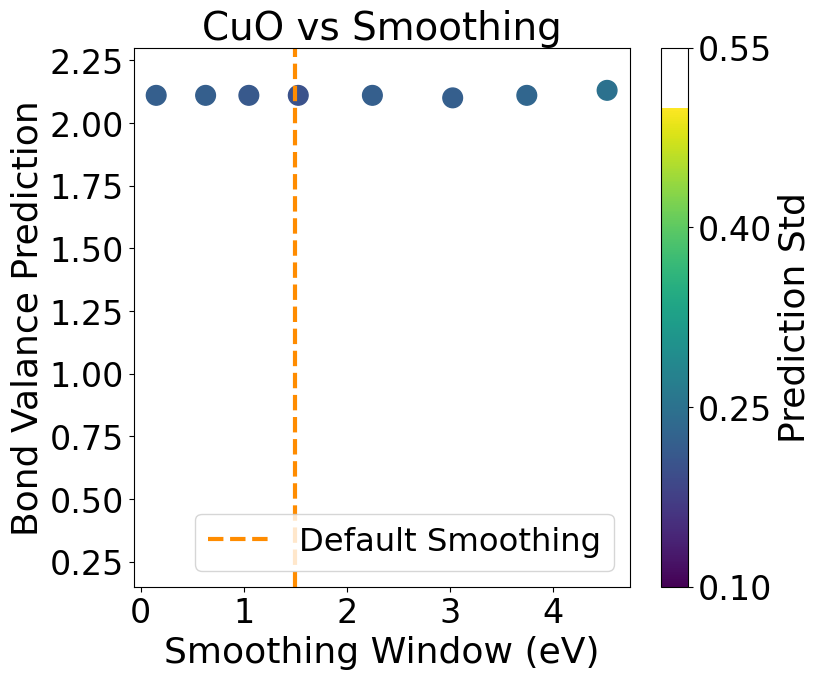

In [94]:
test_rf_obj.visualize_smoothings(show_table=True, savefigure=False)

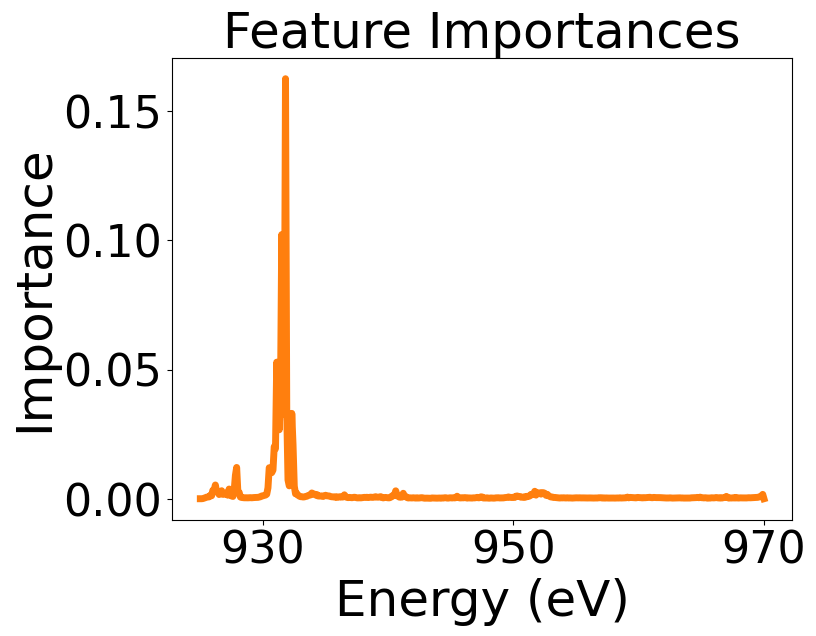

In [95]:
test_rf_obj.show_feature_importances('Cu', savefigure=True)

In [96]:
test_rf_obj.add_interp_spec_to_ERROR_df([0.005, 0.01, 0.03, 0.05], False,925)


0.005
0.01
0.03
0.05


In [97]:
def full_noise_setup(column, energy_col, interp_range, smoothing_window, filename=None, 
                     show_plots = False, baseline_subtract = False):
    full_noise_analysis_output = []
    accuracies = []
    rmses = []
    count = 0
    count_1 = 0
    for random_seed in np.linspace(0,99,100):
        random_seed = int(random_seed)
        print(random_seed)
        # for std in [0.01, 0.05, 0.1, 0.2]:
        for std in [1000, 500, 100, 50]:
            print(std)
            noisy_test = []
            interp_spec = np.asarray(test_rf_obj.rf_error_df[column])
            
            energy = np.arange(925,970.1, 0.1)[0:451]
            energy[450] = 970
            interp_energies = np.arange(925, 970 + interp_range, interp_range)
            
            smooth_interp_spec = []
            interp_energies_final = []
            for en in interp_energies:
                en_rounded = round(en, 2)
                if en_rounded <= 970:
                    interp_energies_final.append(en_rounded)
            if count == 0:
                plt.plot(interp_spec[0])
                plt.title('Interpolate Spectra ' + str(interp_range) + ' eV', fontsize = 18)
                plt.show()

            for spec in interp_spec:
                noisy_test.append(poisson(spec, std, random_seed))
            

            # interp_energies_further = np.arange(925, 970 + 0.001, 0.001)
            for noisy_spec in noisy_test:
                # print(count)
                if count_1 == 0:
                    plt.plot(test_rf_obj.rf_error_df.iloc[0][energy_col], noisy_spec)
                    plt.title('add noise original')
                    plt.show()
                    count_1 +=1
                # print(len(test_rf_obj.rf_error_df.iloc[0][energy_col]))
                # f = interpolate.interp1d(test_rf_obj.rf_error_df.iloc[0][energy_col], noisy_spec)

                # print(interp_energies_final)
                # interped_noisy_spec = f(interp_energies_final)
                

                
                smoothed_spec = savgol_filter(noisy_spec, smoothing_window, 3)

                # print(len(interp_energies_final))
                # print(len(smoothed_spec))
                f = interpolate.interp1d(interp_energies_final, smoothed_spec)
                smoothed_spec = f(energy)
                if baseline_subtract:   
                    smoothed_spec = smoothed_spec - min(smoothed_spec)
                smooth_interp_spec.append(smoothed_spec)
            if count == 0:

                plt.plot(interp_energies_final[0:100], noisy_spec[0:100])
                plt.plot(energy[0:30], smoothed_spec[0:30])
                plt.title('Zoom in on baseline')
                plt.show()


                plt.figure(figsize=(8, 7))
                plt.xlabel('Energy (eV)', fontsize = 36, fontweight='bold')
                plt.ylabel(' Intensty', fontsize = 36, fontweight='bold')
                plt.xticks([930, 950, 970], fontsize = 36, fontweight='bold')
                plt.yticks([0,0.5, 1, 1.5], fontsize = 36, fontweight='bold')
                plt.plot(test_rf_obj.rf_error_df.iloc[0][energy_col], noisy_test[0], linewidth = 3, label = 'Noisy Spec')
                plt.title('Add Noise std = ' + str(std), fontsize = 36, fontweight='bold')
                # plt.show()
                plt.plot(energy, smooth_interp_spec[0], linewidth = 3, label = 'Smoothed')
                # plt.title('Smooth Using Same Window As Exp', fontsize = 18)
                plt.legend(fontsize = 21)
                # plt.savefig('Example Noisy Spec' + str(std) + '.pdf',  bbox_inches='tight', transparent=True)
                plt.show()

            # plt.figure(figsize=(8,7))

            # plt.plot(noisy_test[0], linewidth = 3, label = 'Noisy Spectra')
            # plt.plot(energy, smooth_interp_spec[0], linewidth = 2, label = 'Smoothed')

            # plt.title('Noisy Spectra', fontsize = 36, fontweight='bold')

            # font = font_manager.FontProperties(
            #                                    weight='bold',
            #                                    style='normal', size=22)
            # plt.xlabel('Energy (eV)', fontsize = 36, fontweight='bold')
            # plt.ylabel(' Intensty', fontsize = 36, fontweight='bold')
            # plt.xticks([930, 950, 970], fontsize = 36, fontweight='bold')
            # plt.yticks([0,1], fontsize = 36, fontweight='bold')
            # plt.legend(fontsize = 21)
            # plt.show()

            noisy_test_cum = []
            for spec in smooth_interp_spec:
                temp_intens = []
                for k in range(0, len(spec)):
                    temp_intens.append(sum(spec[0:k]))
                noisy_test_cum.append(temp_intens/max(temp_intens))
            if count == 0:
                plt.plot(noisy_test_cum[0])
                plt.show()

            accuracy = test_rf_obj.rf_model.score(noisy_test_cum, test_rf_obj.rf_error_df['Labels Test'])
            
            
            
            # noisy_spectra_test_pre = np.stack(noisy_test_cum).astype(np.float32)
            # noisy_spectra_test = preprocessing.scale(noisy_spectra_test_pre, axis = 1)
            
            # plt.plot(noisy_spectra_test[0])
            # plt.plot(preprocessing.scale(noisy_spectra_test_pre[0]))
            # plt.show()

            # predictions = dnn_test[1].predict(noisy_spectra_test)
            # print(predictions)
            # labels_test = np.asarray(test_rf_obj.rf_error_df['Labels Test'])
            # accuracy = r2_score(np.asarray(labels_test), np.asarray(predictions))

            # print(accuracy)

            predictions = test_rf_obj.rf_model.predict(noisy_test_cum)
            # predictions_full = []
            # trees = test_rf_obj.rf_model.estimators_
            # for tree in trees:
            #     predictions_full.append(tree.predict(np.asarray(noisy_test_cum)))
            # predictions_ordered = np.asarray(predictions_full).T
            # predictions_std = []
            # count = 0
            # for prediction in predictions_ordered:
            #     predictions_std.append(np.std(prediction))
            #     count += 1
                # print(predictions_std)

            predictions_rounded = []
            predictions_clean = []
            for pred in predictions:
                predictions_rounded.append(round(pred,1))
            for pred in predictions:
                predictions_clean.append(pred)
            predictions = predictions_clean

            errors_noisy = np.abs(test_rf_obj.rf_error_df['Labels Test'] - predictions)
            # test_rf_obj.rf_error_df['Predictions_noisy_std'] = predictions_std
            test_rf_obj.rf_error_df['Predictions_noisy'] = predictions_rounded

            scatter_spot_multiplier = 15

            print('model accuracy (R^2) on simulated test data ' + str(accuracy))

            # plt.figure(figsize=(8, 6))
            true = []
            pred = []
            count_list = []
            # condensed_stds = []
            for i in np.asarray(test_rf_obj.rf_error_df[['Predictions_noisy', 'Labels Test Rounded']].value_counts().index):
                pred.append(round(i[0], 1))
                true.append(round(i[1], 1))
                # condensed_stds.append(np.mean(test_rf_obj.rf_error_df.loc[
                #                                   (test_rf_obj.rf_error_df['Predictions_noisy'] == round(i[0], 1)) & (
                #                                           test_rf_obj.rf_error_df['Labels Test Rounded'] == round(i[1], 1))][
                #                                   'Predictions_noisy_std']))

            for k in np.asarray(test_rf_obj.rf_error_df[['Predictions_noisy', 'Labels Test Rounded']].value_counts()):
                count_list.append(k)
            count_list = np.asarray(count_list)
            
            # plt.figure(figsize=(8, 6))
            # plt.scatter(true, pred, s=count_list * scatter_spot_multiplier, c=count_list)

            # cb = plt.colorbar(label='Num Predictions')
            # ax = cb.ax
            # text = ax.yaxis.label
            # font = matplotlib.font_manager.FontProperties(size=22)
            # text.set_font_properties(font)
            # for t in cb.ax.get_yticklabels():
            #     t.set_fontsize(22)
            # min_plot = round(min(test_rf_obj.rf_error_df['Labels Test']) - 0.5, 0)
            # max_plot = round(max(test_rf_obj.rf_error_df['Labels Test']) + 1.5, 0)
            # plt.plot(np.arange(min_plot, max_plot, 1), np.arange(min_plot, max_plot, 1), color='k', linewidth=3,
            #          linestyle='--')
            # plt.title('Predicted vs True', fontsize=24)
            # plt.xticks(fontsize=18)
            # plt.yticks(fontsize=18)

            # plt.ylabel('Bond Valance Prediction', fontsize=22)
            # plt.xlabel('True Bond Valance', fontsize=22)
            # plt.show()

            # plt.figure(figsize=(8, 6))
            # plt.title('Predicted vs True', fontsize=28)
            # plt.xticks(fontsize=24)
            # plt.yticks(fontsize=24)
            # plt.ylabel('Bond Valance Prediction', fontsize=28)
            # plt.xlabel('True Bond Valance', fontsize=28)
            # min_plot = round(min(test_rf_obj.rf_error_df['Labels Test']) - 0.5, 0)
            # max_plot = round(max(test_rf_obj.rf_error_df['Labels Test']) + 1.5, 0)
            # plt.plot(np.arange(min_plot, max_plot, 1), np.arange(min_plot, max_plot, 1), color='k', linewidth=3,
            #          linestyle='--')
            # plt.scatter(true, pred, s=count * scatter_spot_multiplier, c=condensed_stds)
            # cb = plt.colorbar(label='Prediction Std')
            # ax = cb.ax
            # text = ax.yaxis.label
            # font = matplotlib.font_manager.FontProperties(size=28)
            # text.set_font_properties(font)
            # for t in cb.ax.get_yticklabels():
            #     t.set_fontsize(24)

            # plt.savefig('r^2 noisy plot.pdf',  bbox_inches='tight', transparent=True)

            # show_type = 'Abs Error'
            # nbins=20
            # show_rmse = True

            MSE = np.square(errors_noisy).mean()
            RMSE = math.sqrt(MSE)
            print('RMSE ' + str(RMSE))
            # plt.figure(figsize=(8, 6))
            # plt.title('Error Histogram', fontsize=24)
            # if show_type == 'Abs Error':
            #     hist = plt.hist(errors_noisy, bins=nbins)
            # elif show_type == 'MSE':
            #     hist = plt.hist(np.square(errors_noisy), bins=nbins)

            # if show_rmse:
            #     plt.vlines(RMSE, max(hist[0]), min(hist[0]), color='limegreen', linewidth=5, label='RMSE')
            #     plt.text(RMSE + 0.25, max(hist[0]) - 0.1 * max(hist[0]), 'RMSE = ' + str(round(RMSE, 3)),
            #              horizontalalignment='center', fontsize=16)
            # plt.xticks(fontsize=24)
            # plt.yticks(fontsize=24)
            # plt.xlabel(show_type, fontsize=28)
            # plt.ylabel('Frequency', fontsize=28)
            # plt.savefig('Error Histogram.pdf',  bbox_inches='tight', transparent=True)
            # plt.show()
            # mp_ids = np.asarray(test_rf_obj.rf_error_df['Materials Ids'])


            # full_noise_analysis_output.append([labels_test, mp_ids, predictions, predictions_ordered, predictions_std, 
            #                                    errors_noisy, interp_spec, noisy_test, smooth_interp_spec, 
            #                                    noisy_test_cum, std, random_seed, accuracy, RMSE])
            # accuracies.append(accuracy)
            # rmses.append(RMSE)
            
            # print('mean accuracy  = ' + str(np.mean(accuracies)))
            # print('std accuracy = ' + str(np.std(accuracies)))

            # print('mean RMSE = ' + str(np.mean(rmses)))
            # print('std RMSE = ' + str(np.std(rmses)))

            
            full_noise_analysis_output.append([std, random_seed, accuracy, RMSE])
        count += 1
    full_noise_df = pd.DataFrame(full_noise_analysis_output, columns = ['noise_std', 'random_state', 'R2', 'RMSE'])
    if filename!= None:
        joblib.dump(full_noise_df, filename)

In [98]:
def visualize_full_noise_test_set(noise_dfs, interp_ranges, show_err = True):
    if type(noise_dfs) != list:
        noise_dfs = [noise_dfs]
    if type(interp_ranges) != list:
        interp_ranges = [interp_ranges]
    for vis in ['R2', 'RMSE']:
        count = -1
        plt.figure(figsize=(8,7))    
        for noise_df in noise_dfs:
            count += 1
            mean_01 = np.mean(np.asarray(noise_df.loc[noise_df['noise_std'] == 1000][vis]))
            mean_05 = np.mean(np.asarray(noise_df.loc[noise_df['noise_std'] == 500][vis]))
            mean_1 = np.mean(np.asarray(noise_df.loc[noise_df['noise_std'] == 100][vis]))
            mean_2 = np.mean(np.asarray(noise_df.loc[noise_df['noise_std'] == 50][vis]))

            std_01 = np.std(np.asarray(noise_df.loc[noise_df['noise_std'] == 1000][vis]))
            std_05 = np.std(np.asarray(noise_df.loc[noise_df['noise_std'] == 500][vis]))
            std_1 = np.std(np.asarray(noise_df.loc[noise_df['noise_std'] == 100][vis]))
            std_2 = np.std(np.asarray(noise_df.loc[noise_df['noise_std'] == 50][vis]))     


            if vis == 'R2':
                plt.title('R2 vs Noise', fontsize = 36, fontweight='bold')
                plt.xlabel('Noise STD', fontsize = 36, fontweight='bold')
                plt.ylabel('R2', fontsize = 36, fontweight='bold')
                plt.xticks([0,0.1, 0.2], fontsize = 36, fontweight='bold')
                plt.yticks([0.3,0.6,0.9], fontsize = 36, fontweight='bold')
                plt.ylim([0.28, 0.95])
                plt.xlim([-0.01, 0.225])
                plt.scatter([0, 0.01, 0.05, 0.1, 0.2], [0.88, mean_01, mean_05, mean_1, mean_2], color = 'k', s=200, zorder=5)

                if show_err:
                    plt.plot([0, 0.01, 0.05, 0.1, 0.2], [0.88, mean_01, mean_05, mean_1, mean_2], color = 'k')
                    eb1 = plt.errorbar([0, 0.01, 0.05, 0.1, 0.2], [0.88, mean_01, mean_05, mean_1, mean_2], yerr=[0, std_01, std_05, std_1, std_2], 
                                 ecolor='k', errorevery=1, capsize=15, linewidth = 4, label = str(interp_ranges[count]))
                    eb1[-1][0].set_linestyle(':') 
                    plt.savefig('R2 Noise Profile '+str(interp_ranges[count])+'.pdf',  bbox_inches='tight', transparent=True)

                else:
                    plt.plot([0, 0.01, 0.05, 0.1, 0.2], [0.88, mean_01, mean_05, mean_1, mean_2],
                             linewidth = 4, label = str(interp_ranges[count]))

            if vis == 'RMSE':
                plt.title('RMSE vs Noise', fontsize = 36, fontweight='bold')
                plt.xlabel('Noise STD', fontsize = 36, fontweight='bold')
                plt.ylabel('RMSE', fontsize = 36, fontweight='bold')
                plt.xticks([0,0.1, 0.2], fontsize = 36, fontweight='bold')
                plt.yticks([0.2,0.35,0.5], fontsize = 36, fontweight='bold')
                plt.ylim([0.19, 0.525])
                plt.xlim([-0.01, 0.225])
                plt.scatter([0, 0.01, 0.05, 0.1, 0.2], [0.214, mean_01, mean_05, mean_1, mean_2], color = 'k', s=200, zorder=5)

                if show_err:
                    plt.plot([0, 0.01, 0.05, 0.1, 0.2], [0.214, mean_01, mean_05, mean_1, mean_2], color = 'k')
                    eb1 = plt.errorbar([0, 0.01, 0.05, 0.1, 0.2], [0.214, mean_01, mean_05, mean_1, mean_2], yerr=[0, std_01, std_05, std_1, std_2], 
                                 ecolor='k', errorevery=1, capsize=15, linewidth = 4, label = str(interp_ranges[count]))
                    eb1[-1][0].set_linestyle(':') 
                    plt.savefig('RMSE Noise Profile '+str(interp_ranges[count])+'.pdf',  bbox_inches='tight', transparent=True)

                else:
                    plt.plot([0, 0.01, 0.05, 0.1, 0.2], [0.214, mean_01, mean_05, mean_1, mean_2],
                             linewidth = 4, label = str(interp_ranges[count]))
        if show_err == False:
            plt.legend(fontsize = 22, title="Sampling Interval (eV)", title_fontsize = 22)
            if vis == 'RMSE':
                plt.savefig('RMSE Noise Profile'+str(' all')+'.pdf',  bbox_inches='tight', transparent=True)
            if vis == 'R2':
                plt.savefig('R2 Noise Profile'+str(' all')+'.pdf',  bbox_inches='tight', transparent=True)


0
1000


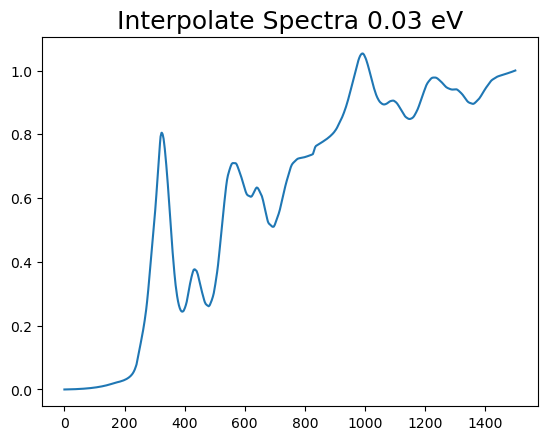

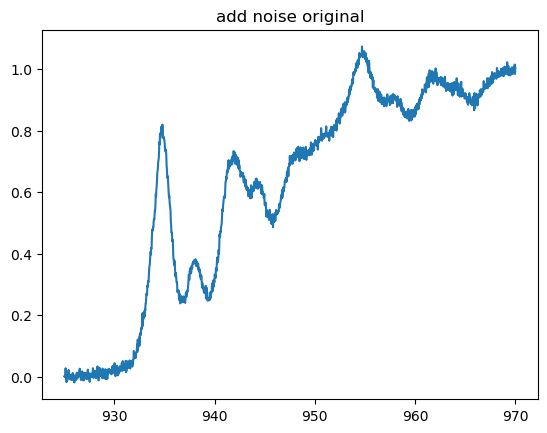

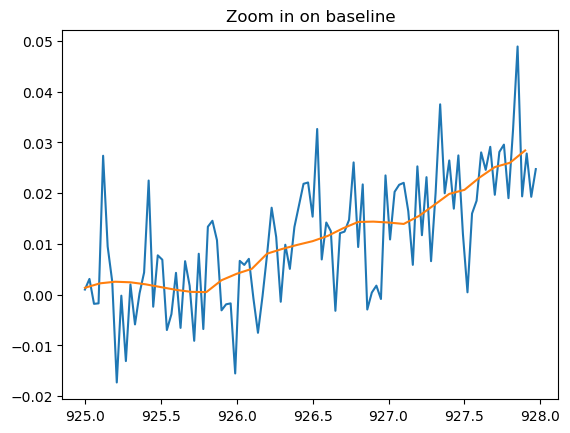

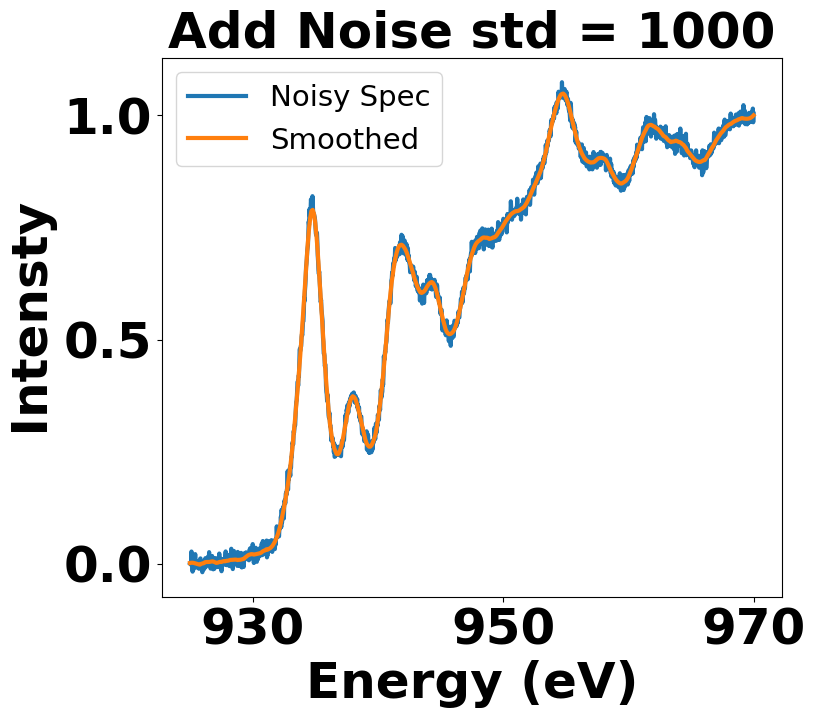

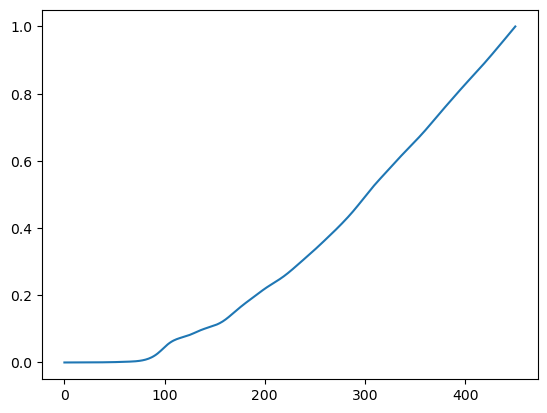

model accuracy (R^2) on simulated test data 0.8667240252236619
RMSE 0.2287318254404247
500


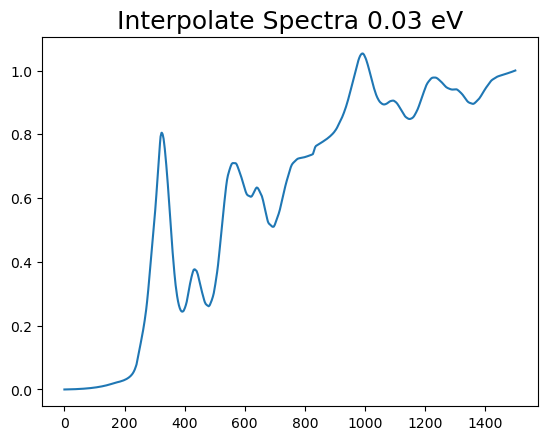

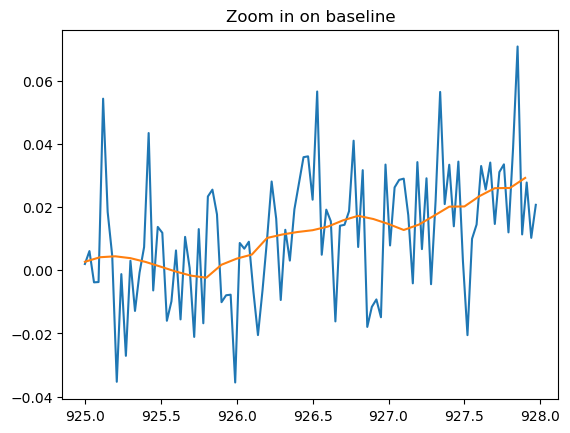

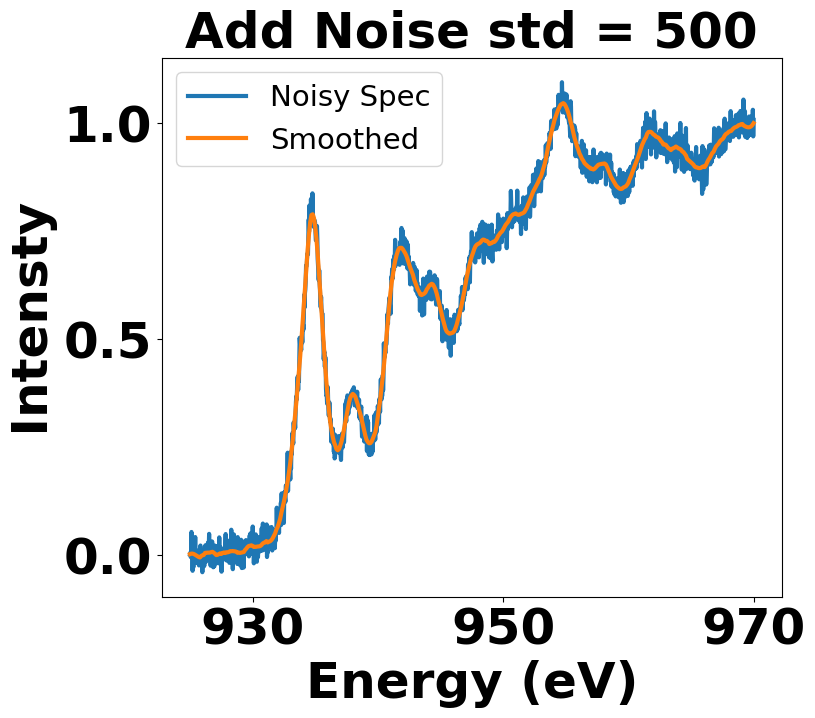

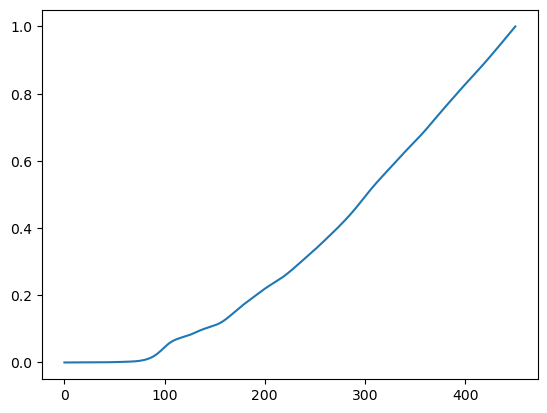

model accuracy (R^2) on simulated test data 0.8426395555475616
RMSE 0.2485412332327807
100


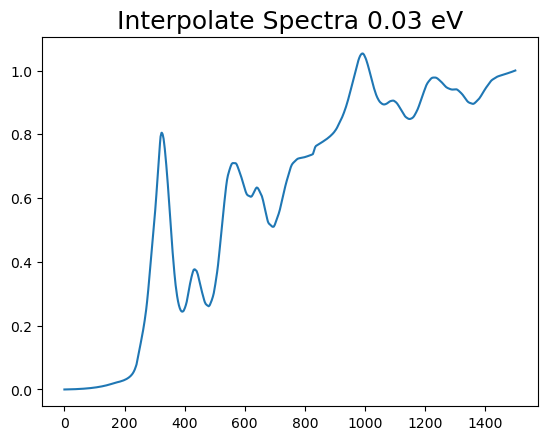

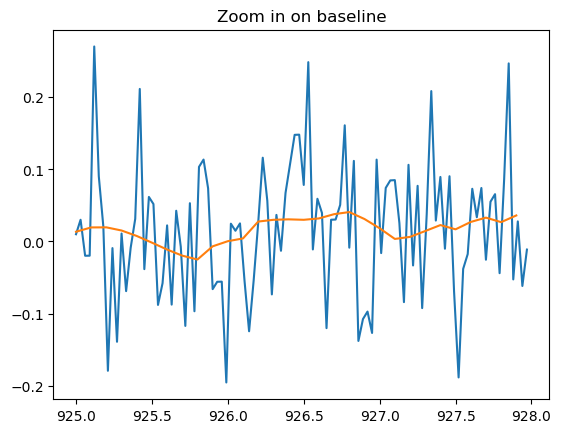

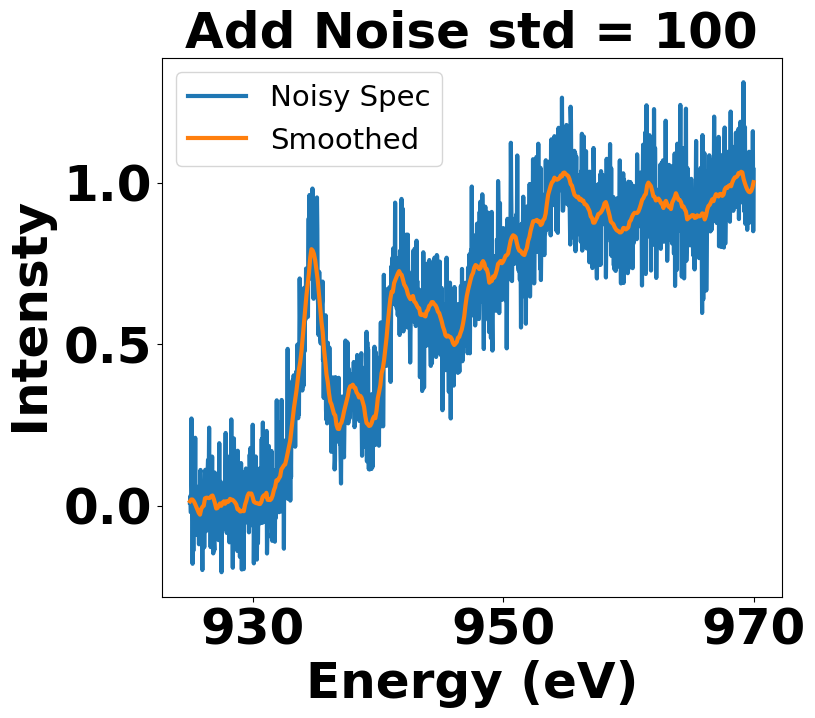

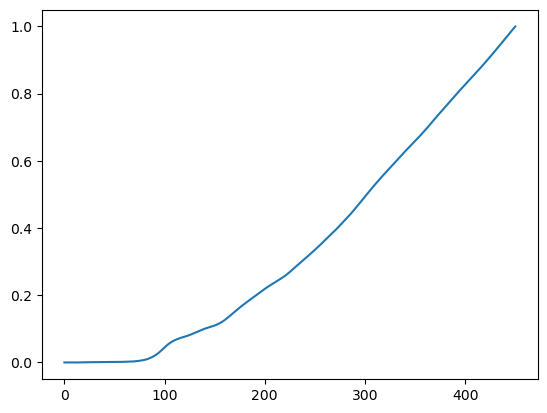

model accuracy (R^2) on simulated test data 0.7898825223178454
RMSE 0.28719822504177683
50


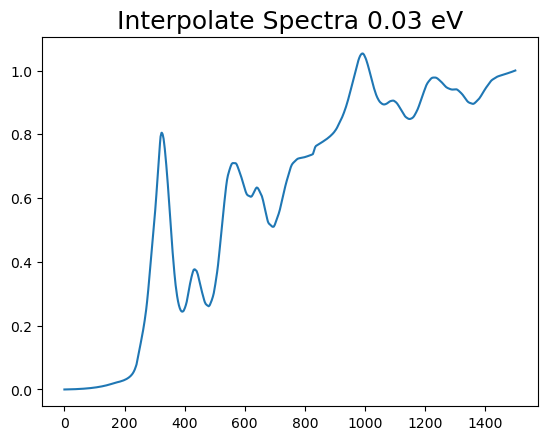

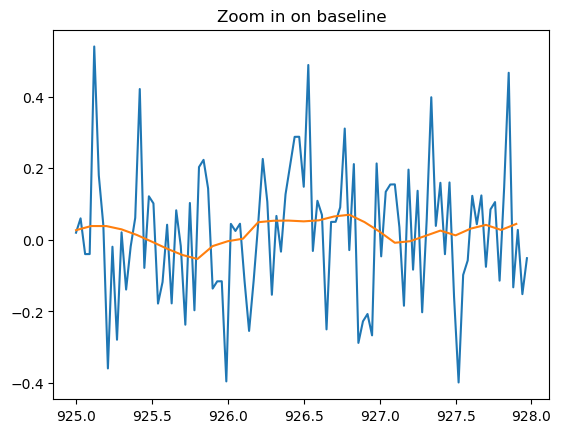

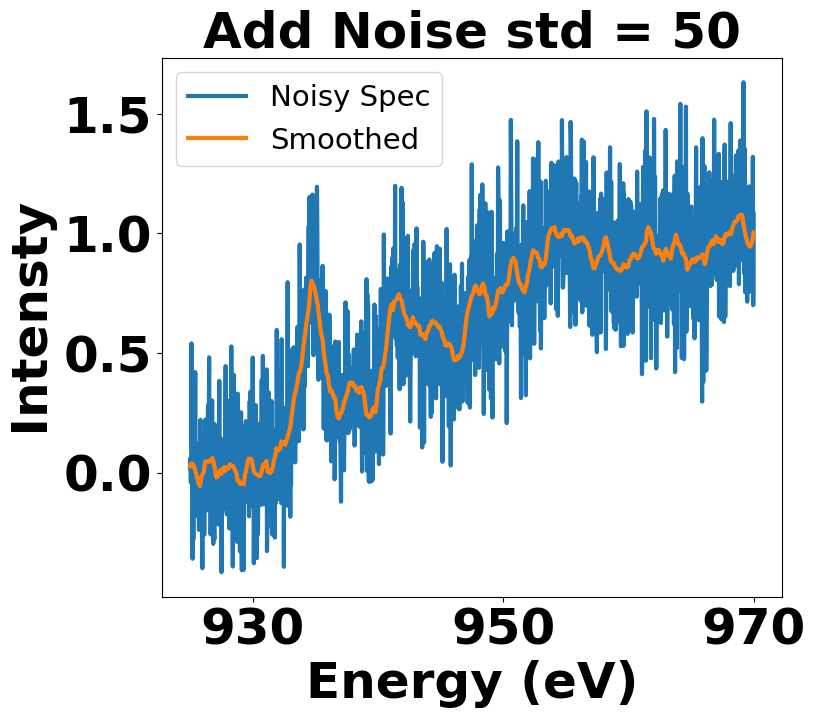

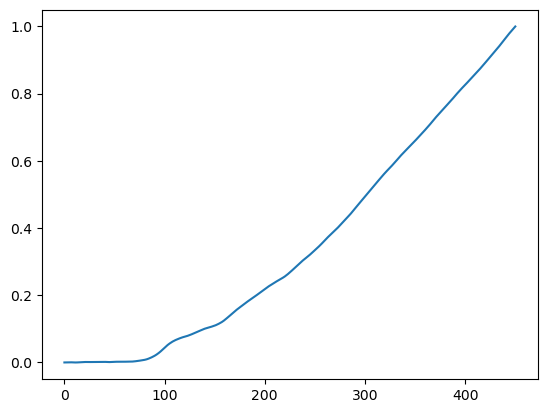

model accuracy (R^2) on simulated test data 0.7781333778954029
RMSE 0.2951186447312245
1
1000
model accuracy (R^2) on simulated test data 0.7933975421173276
RMSE 0.28478584812672836
500
model accuracy (R^2) on simulated test data 0.689500583152737
RMSE 0.34912508671798004
100
model accuracy (R^2) on simulated test data 0.5674945564354146
RMSE 0.412046710245323
50
model accuracy (R^2) on simulated test data 0.545148104848987
RMSE 0.42255735599608363
2
1000
model accuracy (R^2) on simulated test data 0.8208683299575277
RMSE 0.26517760847519894
500
model accuracy (R^2) on simulated test data 0.7508275999282933
RMSE 0.31275238472783246
100
model accuracy (R^2) on simulated test data 0.5799562922666709
RMSE 0.40606719343026326
50
model accuracy (R^2) on simulated test data 0.5395053025727179
RMSE 0.42517035819789084
3
1000
model accuracy (R^2) on simulated test data 0.7164231393873821
RMSE 0.33364610349736457
500
model accuracy (R^2) on simulated test data 0.6058620680384064
RMSE 0.39334603

In [99]:
full_noise_setup('Interpolated_spec_0.03', 'Interpolated_spec_energies_0.03', 0.03, 51, filename='reproducable_alignment_model_full_noise_df_poisson_03.joblib')

In [100]:
poisson_noise_df_03 = joblib.load('reproducable_alignment_model_full_noise_df_poisson_03.joblib')

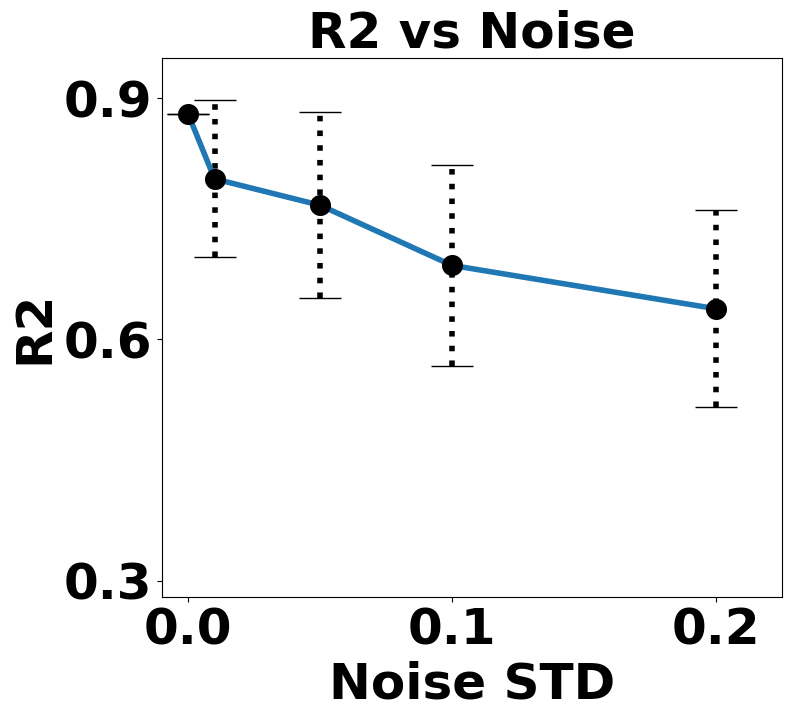

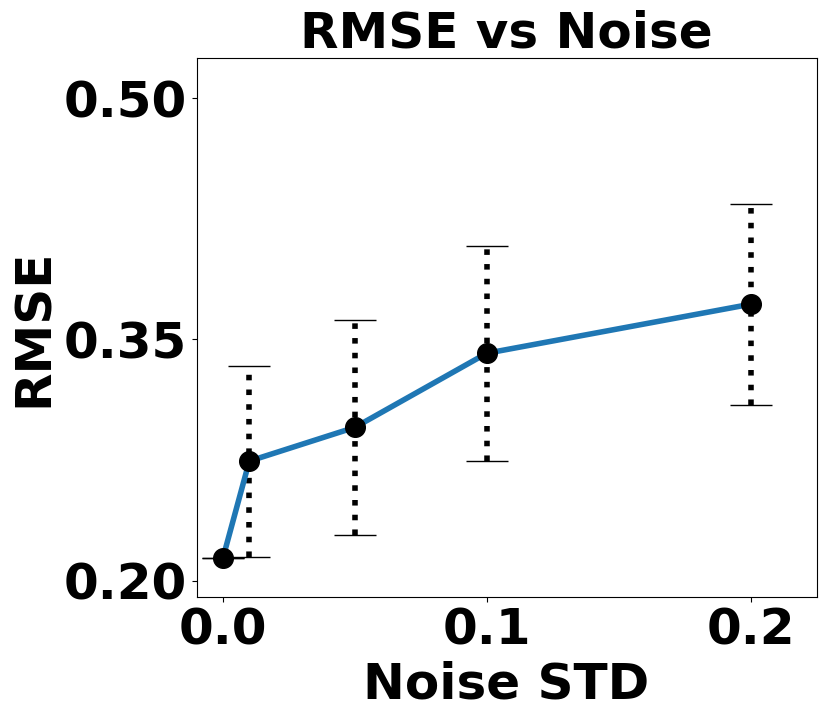

In [101]:
visualize_full_noise_test_set([poisson_noise_df_03], [0.03])